# Water Mission, IBM

## Baseline/Midline surveys comparison 

This Notebook offers comparison of responses between surveys for households in the rural communities Lulembela, Chanhomba and Gidewari of Tanzania. You can find list of the report sections created using this notebook in The Table of Content section below.

The Notebook processes the dataset from Tanzania's districts. Dataset might be in the CSV or EXCEL format.

## Table of Content
* [Library Imports and Settings](#settings)
 * [Global Variables](#variables)
 * [Library Imports](#imports)
* [DataFrames creation and Data Pre-processing](#preprocessing)
 * [Functions](#functions)
 * [Baseline survey's DataFrames creation](#bl_df_creation) 
 * [Midline survey's DataFrames creation](#ml_df_creation)
* [Comparing Baseline and Midline surveys](#bl_ml_comparing)
 * [Find matching](#find_matching)
   * [Lulembela](#matching_lulembela)
   * [Chanhomba](#matching_chanhomba)
   * [Gidewari](#matching_gidewari)
 * [Baseline/Midline surveys comparison in Lulembela](#comparing_lulembela)
   * [Difference on the clusters/groups level](#comparing_lulembela_groups)
   * [Difference on the community level](#comparing_lulembela_comm)
 * [Baseline/Midline surveys comparison in Chanhomba](#comparing_chanhomba)
   * [Difference on the clusters/groups level](#comparing_chanhomba_groups)
   * [Difference on the community level](#comparing_chanhomba_comm)
 * [Baseline/Midline surveys comparison in Gidewari](#comparing_gidewari)
   * [Difference on the clusters/groups level](#comparing_gidewari_groups)
   * [Difference on the community level](#comparing_gidewari_comm)

<a id="settings"></a>
# Library Imports and Settings

This section contains import statements for all the libraries used in the notebook and various configuration settings we rely on.

<a id="variables"></a>
## Global Variables

The notebook allows you switching your environment between local environment and Bluemix cloud.

If you run the notebook on your local system set **environment** variable to local and the path to the data file using **root** variable. If using Data Science Experience, set **environment** variable to any value different from **_local_** (for example, you may use **_bluemix_** value to make it more clear).


In [1]:
environment = 'bluemix'
root = 'c:\\datasets\\'

If using Data Science Experience, the dataset file is stored on the Bluemix cloud and we need to define credeantials for accessing it.

If you need to use another Object storage in Data Science Experience, you have to change **credentials** variable below. You may create an empty cell, click **_Find and Add Data_** menu (at the top right side), then choose **_Insert to code_** for any file and pick out **_Insert Credentials_**. New credentials will appear in the active cell. You may rename the fragment JSON to **credentials** and drop or comment the older one.

In [2]:
# @hidden_cell
credentials = {
  'auth_url':'https://identity.open.softlayer.com',
  'project':'object_storage_a2fb7d55_67e7_4258_a192_04215bdfe373',
  'project_id':'dbb445bcb1014178ba6b418a8d14c2e4',
  'region':'dallas',
  'user_id':'2e7ed539b10c4b939a08b476167196de',
  'domain_id':'33dfa34c5bad4cf5b34da9def543de97',
  'domain_name':'907035',
  'username':'member_8d133283f3260061be9bb8a15c4cebfc424d2a41',
  'password':"""yLnZVC1BG&]-X7Y?""",
  'container':'WaterMissionWorldBank',
  'tenantId':'undefined',
  'filename':'Rural_ML_Master.xlsx'
}

<a id="imports"></a>
## Library Imports

In [3]:
import pandas as pd
import csv
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import numpy as np
from collections import OrderedDict
import math
import types
from sklearn import cluster
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import scale
from itertools import cycle
from io import StringIO, BytesIO
import requests
import json
try:
    import seaborn as sns
except:
    import pip    
    pip.main(['install', 'seaborn'])    
    import seaborn as sns

<a id="preprocessing"></a>
# DataFrames creation and Data Pre-processing
This section aggregates code to load data, definitions of functions used to pre-process data, and code to prepare data.

<a id="functions"></a>
## Functions
This section defines functions used for data processing.

In [4]:
# @hidden_cell
# This function accesses a file in your Object Storage using 'credentials' variable defined above.
def get_object_storage_file_with_credentials(filename, credentials):
    """This functions returns a BytesIO object containing the file content from Bluemix Object Storage."""

    url1 = ''.join([credentials['auth_url'], '/v3/auth/tokens'])
    data = {'auth': {'identity': {'methods': ['password'],
            'password': {'user': {'name': credentials['username'],'domain': {'id': credentials['domain_id']},
            'password': credentials['password']}}}}}
    headers1 = {'Content-Type': 'application/json'}
    resp1 = requests.post(url=url1, data=json.dumps(data), headers=headers1)
    resp1_body = resp1.json()
    for e1 in resp1_body['token']['catalog']:
        if(e1['type']=='object-store'):
            for e2 in e1['endpoints']:
                        if(e2['interface']=='public'and e2['region']=='dallas'):
                            url2 = ''.join([e2['url'],'/', credentials['container'], '/', filename])
    s_subject_token = resp1.headers['x-subject-token']
    headers2 = {'X-Auth-Token': s_subject_token, 'accept': 'application/json'}
    resp2 = requests.get(url=url2, headers=headers2)
    return BytesIO(resp2.content)

def get_file_content(filename):
    if(environment == 'local'):
        return root + filename
    else:
        return get_object_storage_file_with_credentials(filename, credentials)

In [5]:
def floatExt(val):
    try:
        res = float(val)
    except ValueError:
        if val == '':
            res = float('nan')
        else:
            res = float(val.replace(',','.'))
    return res
    

In [6]:
def find_clusters(df):
    sliced = df.iloc[0:, 1:].dropna()
    x_array = sliced.values    
    bandwidth = estimate_bandwidth(x_array, quantile = 0.3)
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(x_array)
    labels = ms.labels_
    cluster_centers = ms.cluster_centers_    
    return x_array, labels, cluster_centers   

  
pos_to_char = lambda idx: chr(int(idx) + 65)

def get_age_group(age):
    group = 'Unknown'   
    if (18 <= age <= 29):
        group = '18-29 years'
    elif (30 <= age <= 39):
        group = '30-39 years'
    elif (40 <= age <= 49):
        group = '40-49 years'
    elif (50 <= age <= 59):
        group = '50-59 years'
    elif (age >= 60):
        group = '60+ years'
    return group


In [7]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 7

def show_diff_between_surveys_clusters(df1, df2, c_name, f_name, surveys, title, y_label, box_anchor=(1.15, 1.0)):    
    df_pt1 = df1[['Group', c_name]]
    df_pt2 = df2[['Group', c_name]]  
    aggregations = {        
         c_name: {
                '': f_name

            }        
    }
    df_g1 = df_pt1.groupby(['Group']).agg(aggregations).reset_index()    
    df_g2 = df_pt2.groupby(['Group']).agg(aggregations).reset_index()    
    df_g1.rename(inplace=True, columns={c_name: surveys[0]})
    df_g2.rename(inplace=True, columns={c_name: surveys[1]})
    
    del df_g2['Group']
    
    df_g1 = df_g1.join(df_g2)   
    
    group_names = df_g1['Group']
    df_g1.plot(subplots=False, figsize=(23, 10),  kind='bar')  
    L = plt.legend(loc='upper right', bbox_to_anchor=box_anchor, fontsize=20)
    for i in range(len(surveys)):
        L.get_texts()[i].set_text(surveys[i])
    plt.title(title, fontsize=29)    
    plt.rcParams.update({'font.size': 16})
    plt.tick_params(axis='both', which='major', labelsize=20)  
    plt.xticks(range(len(group_names)), group_names)
    plt.ylabel(y_label, fontsize=25)
    plt.xlabel('Group', fontsize=25)
    axes = plt.gca()
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=0)
    plt.show()
    
    
def show_diff_for_surveys_clusters(surveys, c_name, title, legend_labels, box_anchor=(1.15, 1.0), width = 0.35 , pad=2.5 ):
    
    clusters = ['A', 'B', 'C', 'D', 'E']    
    #fig, ax = plt.subplots(nrows=1,ncols=2)
    #fig.subplots_adjust(bottom=0.5)
    
    ind = np.arange(len(clusters))
    xlen = len(legend_labels)
    
    #colors = 'bgrcmykbgrcmykbgrcmykbgrcmyk'
    colors = ('b', 'g', 'r', 'c', 'm', 'y', 'salmon', 'k', 'slateblue', 'mediumseagreen')
    cols_2_colors = {}
    for col, color in zip(legend_labels.keys(), colors):
        cols_2_colors[col] = color
    
    idx = 1
    legend = {}
    for k, v in surveys.items():
        df = v        
        plt.subplot(1, 2, idx)        
        pt_countr_all = df.pivot_table(values='Count', index=['Group'], columns=[c_name], aggfunc=np.sum, fill_value=0)
        pt_countr_all['sum'] = pt_countr_all.sum(axis=1)
        pt_countr_all = pt_countr_all.div(pt_countr_all.iloc[:,-1], axis=0 ).mul(100)
        del pt_countr_all['sum']       
        cols = pt_countr_all.columns.get_values()
        j = 0 
        for col in cols:
            val = pt_countr_all[col].as_matrix()
            color = cols_2_colors.get(col, 'pink')
            rects = plt.bar(ind + j * width, val, width, color=color)
            leg_val = legend.get(col, None)
            if leg_val is None:
                legend[col] = rects[0]
            j += 1;
        
        plt.tick_params(axis='both', which='major')          
        ax = plt.gca()        
        ax.set_xlabel('Group', fontsize=14)
        ax.set_ylabel('Percent', fontsize=14)        
        ax.set_title(k, fontsize=14)
        ax.set_xticks(ind + xlen*width / 4)
        ax.set_xticklabels(clusters, fontsize=14)
        ax.set_ylim([0,100])
        idx += 1
        
    
    marks = []
    texts = []
    for label, mark in legend.items():
        text = legend_labels.get(label, label)
        marks.append(mark)
        texts.append(text)
    
    ax.legend(marks, texts, loc='upper right', bbox_to_anchor=box_anchor)
    fig = plt.gcf()
    fig.suptitle(title, fontsize=24, ) 
    fig.tight_layout(pad = pad)
         
    plt.show
    
    
def show_diff_props_surveys_clusters(surveys, c_names, title, legend_labels, box_anchor=(1.15, 1.0), width = 0.35 , pad=2.5 ):
    clusters = ['A', 'B', 'C', 'D', 'E']    
    fig, ax = plt.subplots(nrows=1,ncols=2)    
    
    ind = np.arange(len(clusters))
    xlen = len(legend_labels)
    
    colors = ('b', 'g', 'r', 'c', 'm', 'y', 'salmon', 'k', 'slateblue', 'mediumseagreen')  
    
    idx = 1
    legend = {}
    for k, v in surveys.items():
        df = v        
        df_res = df.groupby('Group').agg({'Count': {'': 'sum'}}).reset_index()
        plt.subplot(1, 2, idx)
        cols = c_names.get(k)
        for i in range(len(cols)):
            df_tmp = df.pivot_table(values='Count', index=['Group'],
                                    columns=[cols[i]],
                                    aggfunc=np.sum, fill_value=0).reset_index()
            try:
                vals = df_tmp[1]
            except:
                vals = pd.Series( data=0, dtype=int, index = df_tmp.index )
                
            df_res[cols[i]] = vals / df_res['Count'] * 100
        j = 0 
        for col, color in zip(cols, colors):
            val = df_res[col].as_matrix()
            rects = plt.bar(ind + j * width, val, width, color=color)
            leg_val = legend.get(col, None)
            if leg_val is None:
                legend[col] = rects[0]
            j += 1;
        
        plt.tick_params(axis='both', which='major')          
        ax = plt.gca()        
        ax.set_xlabel('Group', fontsize=14)
        ax.set_ylabel('Percent', fontsize=14)        
        ax.set_title(k, fontsize=14)
        ax.set_xticks(ind + xlen*width / 4)
        ax.set_xticklabels(clusters, fontsize=14)
        ax.set_ylim([0,100])
        idx += 1
        
    
    marks = []
    texts = []
    for label, mark in legend.items():
        text = legend_labels.get(label, label)
        marks.append(mark)
        texts.append(text)
    
    ax.legend(marks, texts, loc='upper right', bbox_to_anchor=box_anchor)
    fig = plt.gcf()
    fig.suptitle(title, fontsize=24, ) 
    fig.tight_layout(pad = pad)
         
    plt.show

In [8]:
def show_diff_between_surveys(df1, df2, c_name, f_name, surveys, title, y_label, box_anchor=(1.15, 1.0)):
    res1 = f_name(df1[[c_name]])
    res2 = f_name(df2[[c_name]])
    df_res = pd.DataFrame(data={'Survey': surveys, c_name: [res1.values[0], res2.values[0]]})
    barlist = df_res.plot(subplots=False, figsize=(23, 10),  kind='bar',  legend=None)  
    plt.title(title, fontsize=29)    
    plt.rcParams.update({'font.size': 16})
    plt.tick_params(axis='both', which='major', labelsize=20)  
    plt.xticks(range(len(surveys)), surveys)
    plt.ylabel(y_label, fontsize=25)
    plt.xlabel('Surveys', fontsize=25)
    axes = plt.gca()   
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=0)
    plt.show()
    
    
def show_diff_for_surveys(surveys, c_name, title, legend_labels, box_anchor=(1.15, 1.0), width = 0.35 , pad=2.5 ):    
    clusters = ['A', 'B', 'C', 'D', 'E']    
    fig, ax = plt.subplots(nrows=1,ncols=2)    
    
    ind = 1
    xlen = len(legend_labels)    
    
    colors = ('b', 'g', 'r', 'c', 'm', 'y', 'salmon', 'k', 'slateblue', 'mediumseagreen')
    cols_2_colors = {}
    for col, color in zip(legend_labels.keys(), colors):
        cols_2_colors[col] = color
    
    idx = 1
    legend = {}    
    for k, v in surveys.items():
        df = v        
        plt.subplot(1, 2, idx)        
        pt_countr_all = df.pivot_table(values='Count', index=['CommName'], columns=[c_name], aggfunc=np.sum, fill_value=0)
        pt_countr_all['sum'] = pt_countr_all.sum(axis=1)
        pt_countr_all = pt_countr_all.div(pt_countr_all.iloc[:,-1], axis=0 ).mul(100)
        del pt_countr_all['sum']       
        cols = pt_countr_all.columns.get_values()
        j = 0 
        for col in cols:           
            color = cols_2_colors.get(col, 'pink')            
            val = pt_countr_all[col].as_matrix()
            rects = plt.bar(ind + j * width, val, width, color=color)
            leg_val = legend.get(col, None)          
            if leg_val is None:
                legend[col] = rects[0]
            j += 1;
        
        plt.tick_params(axis='both', which='major')          
        ax = plt.gca()
        ax.set_ylabel('Percent', fontsize=14)        
        ax.set_title(k, fontsize=14)
        ax.set_xticklabels('', fontsize=14)
        ax.set_ylim([0,100])
        idx += 1
        
    
    marks = []
    texts = []
    for label, mark in legend.items():
        text = legend_labels.get(label, label)
        marks.append(mark)
        texts.append(text)
    
    ax.legend(marks, texts, loc='upper right', bbox_to_anchor=box_anchor)
    fig = plt.gcf()
    fig.suptitle(title, fontsize=24, ) 
    fig.tight_layout(pad = pad)
         
    plt.show
    

def show_diff_props_surveys(surveys, c_names, title, legend_labels, box_anchor=(1.15, 1.0), width = 0.35 , pad=2.5 , xlabel=''):
         
    fig, ax = plt.subplots(nrows=1,ncols=2)
    xlen = len(legend_labels)    
    colors = 'bgrcmykbgrcmykbgrcmykbgrcmyk'
    idx = 1
    legend = {}
    for k, v in surveys.items():
        df = v
        respondents = np.sum(df['Count'])         
        plt.subplot(1, 2, idx)
        cols = c_names.get(k)               
        j = 0 
        ind = np.arange(len(cols))
        emp_arr = [0,0,0,0,0,0,0,0,0]
        cols_len = len(cols)
        for col, color in zip(cols, colors): 
            answers = np.sum(df[df[cols[j]] == 1][cols[j]])         
            val = answers / respondents * 100
            vals = emp_arr[:cols_len]
            vals[j] = val
            rects = plt.bar(ind + j * width/cols_len, vals, width, color=color)
            leg_val = legend.get(col, None)
            if leg_val is None:
                legend[col] = rects[0]
            j += 1;        
        plt.tick_params(axis='both', which='major')          
        ax = plt.gca()        
        ax.set_xlabel(xlabel, fontsize=14)
        ax.set_ylabel('Percent', fontsize=14)        
        ax.set_title(k, fontsize=14)        
        ax.set_xticklabels('', fontsize=14)
        ax.set_ylim([0,100])
        idx += 1
        
    
    marks = []
    texts = []
    for label, mark in legend.items():
        text = legend_labels.get(label, label)
        marks.append(mark)
        texts.append(text)
    
    ax.legend(marks, texts, loc='upper right', bbox_to_anchor=box_anchor)
    fig = plt.gcf()
    fig.suptitle(title, fontsize=24 ) 
    fig.tight_layout(pad = pad)
         
    plt.show


Converter for the column PrimarySource 

In [9]:
def ps_to_int(val):
    if val=='other':
        return 8
    else:
        return int(val)
    

In [10]:
def get_group_measurements_rural(df):    
    df_pt = df[['Group','Count', 'WaterExpenditure','AmountOfWater']]
    aggregations = {
        'Count': {
                'Respondents': 'sum'

            },
        'WaterExpenditure': {
                'Average value': 'mean'

            },
        'AmountOfWater': {
                'Average value': 'mean'
            }
    }
    df_g = df_pt.groupby(['Group']).agg(aggregations)
    df_g = df_g.apply(lambda x: np.round(x,2))    
    return df_g

<a id="bl_df_creation"></a>
## Baseline survey's DataFrames creation

Load dataset from the Baseline survey file and create DataFrame instance. In this case we use CSV file.

In [12]:

df_survey = pd.read_csv(get_file_content('BL_PhoneSurveyData_Rura_2l.csv'), sep=';',
                        converters={'Phone_Number': str, 'do_you_currently_live_in_commname_': str, 'Farming': floatExt,
                                   'AnimalRaising': floatExt, 'WaterExpenditure': floatExt, 'AmountOfWater': floatExt})

Add column 'Count' and leave only required columns for analysis

In [13]:
df_survey['Count'] = 1
df_survey.columns = ['Phone_Number', 'CommName', 'Mode',
       'do_you_currently_live_in_commname_', 'children', 'adults',
       'hh_mem', 'BirthYear', 'Age', 'Gender', 'Farming',
       'AnimalRaising', 'PrimarySource', 'Reason', 'Reason/Cost',
       'Reason/Availability', 'Reason/Time_Distance', 'Reason/Quality',
       'Reason/Other', 'WatCost20', 'WaterExpenditure', 'AmountOfWater',
       'WaterAvailability', 'AvailReason', 'AvailReason/1', 'AvailReason/2',
       'AvailReason/3', 'AvailReason/4', 'AvailReason/5', 'PowerSource',
       'BankAccount', 'FloorMaterial', 'SourceOfLighting', 'Lighting', 'RudWI',
       'Count']

Rename Availability reasons columns

In [14]:
df_survey.rename(inplace=True, columns={'AvailReason/1': 'AvailReason/Cost', 
                                        'AvailReason/2': 'AvailReason/Availability',
                                        'AvailReason/3': 'AvailReason/Time_Distance',
                                        'AvailReason/4': 'AvailReason/Quality',
                                        'AvailReason/5': 'AvailReason/Other'})

Showing number of respondents in each community

In [15]:
df_bl = df_survey.groupby(['CommName']).Phone_Number.count().reset_index()
df_bl.columns = ['CommName', 'Count']
df_bl['Percent'] = (df_bl.Count / len(df_survey) * 100).round(2)
df_bl

,CommName,Count,Percent
0,Chanhomba,205,33.83
1,Gidewari,122,20.13
2,Lulembela,279,46.04


### Lulembela
Create DataFrame inctance for **Lulembela** community

In [16]:
df_Lulembela = df_survey[df_survey.CommName == 'Lulembela']
df_Lulembela.shape

(279, 36)

Find clusters in **Lulembela** community

In [17]:
df10 = df_Lulembela.copy()
df11 = df10[['Phone_Number', 'AmountOfWater', 'WaterExpenditure', 'Gender', 'Farming', 'AnimalRaising', 'PrimarySource', 'WaterAvailability', 'PowerSource', 'BankAccount', 'FloorMaterial', 'RudWI']]
df12 = df11.dropna()
x_array1, labels1, cluster_centers1 = find_clusters(df12)
df12.shape

(275, 12)

In [18]:
df_processed1 = df12.copy()
df_processed1['ClusterClass'] = pd.Series(labels1, index=df_processed1.index)
df_cc1 = df_processed1[['Phone_Number','ClusterClass']]
df_cluster1 = df10.merge(df_cc1, left_index=True, right_index=True, how = 'left')
df_cluster1 = df_cluster1[~np.isnan(df_cluster1.ClusterClass)]
df_cluster1 = df_cluster1[df_cluster1.ClusterClass != 5]
df_cluster1['Group'] = df_cluster1.ClusterClass.apply(lambda a: pos_to_char(a))
df_cluster1['AgeGroup'] = df_cluster1.Age.apply(lambda a: get_age_group(a))
df_cluster1.shape

(274, 40)

### Chanhomba
Create DataFrame inctance for **Chanhomba** community

In [19]:
df_Chanhomba = df_survey[df_survey.CommName == 'Chanhomba']
df_Chanhomba.shape

(205, 36)

Find clusters in **Chanhomba** community

In [20]:
df20 = df_Chanhomba.copy()
df21 = df20[['Phone_Number', 'AmountOfWater', 'WaterExpenditure', 'Gender', 'Farming', 'AnimalRaising', 'PrimarySource', 'WaterAvailability', 'PowerSource', 'BankAccount', 'FloorMaterial', 'RudWI']]
df22 = df21.dropna()
x_array2, labels2, cluster_centers2 = find_clusters(df22)
df22.shape

(204, 12)

In [21]:
df_processed2 = df22.copy()
df_processed2['ClusterClass'] = pd.Series(labels2, index=df_processed2.index)
df_cc2 = df_processed2[['Phone_Number','ClusterClass']]
df_cluster2 = df20.merge(df_cc2, left_index=True, right_index=True, how = 'left')
df_cluster2 = df_cluster2[~np.isnan(df_cluster2.ClusterClass)]
df_cluster2 = df_cluster2[df_cluster2.ClusterClass != 5]
df_cluster2['Group'] = df_cluster2.ClusterClass.apply(lambda a: pos_to_char(a))
df_cluster2['AgeGroup'] = df_cluster2.Age.apply(lambda a: get_age_group(a))
df_cluster2.shape

(203, 40)

### Gidewari
Create DataFrame inctance for **Chanhomba** community

In [22]:
df_Gidewari = df_survey[df_survey.CommName == 'Gidewari']
df_Gidewari.shape

(122, 36)

Find clusters in **Chanhomba** community

In [23]:
df30 = df_Gidewari.copy()
df31 = df30[['Phone_Number', 'AmountOfWater', 'WaterExpenditure', 'Gender', 'Farming', 'AnimalRaising', 'PrimarySource', 'WaterAvailability', 'PowerSource', 'BankAccount', 'FloorMaterial', 'RudWI']]
df32 = df31.dropna()
x_array3, labels3, cluster_centers3 = find_clusters(df32)
df32.shape

(121, 12)

In [24]:
df_processed3 = df32.copy()
df_processed3['ClusterClass'] = pd.Series(labels3, index=df_processed3.index)
df_cc3 = df_processed3[['Phone_Number','ClusterClass']]
df_cluster3 = df30.merge(df_cc3, left_index=True, right_index=True, how = 'left')
df_cluster3 = df_cluster3[~np.isnan(df_cluster3.ClusterClass)]
df_cluster3 = df_cluster3[df_cluster3.ClusterClass != 5]
df_cluster3 = df_cluster3[df_cluster3.ClusterClass != 6]
df_cluster3.loc[df_cluster3['ClusterClass'] == 3, 'ClusterClass'] = 33
df_cluster3.loc[df_cluster3['ClusterClass'] == 4, 'ClusterClass'] = 44
df_cluster3.loc[df_cluster3['ClusterClass'] == 44, 'ClusterClass'] = 3
df_cluster3.loc[df_cluster3['ClusterClass'] == 33, 'ClusterClass'] = 4
df_cluster3['Group'] = df_cluster3.ClusterClass.apply(lambda a: pos_to_char(a))
df_cluster3['AgeGroup'] = df_cluster3.Age.apply(lambda a: get_age_group(a))
df_cluster3.shape

(119, 40)

<a id="ml_df_creation"></a>
## Midline survey's DataFrames creation

Load Midline survey from the Microsoft Excel file and create DataFrame instance. For loading .xls(.xlsx) file need set up **_sheetname_** parameter. In our case this is **Rural_MLdata**

In [25]:
df_survey_apr = pd.read_excel(get_file_content('Rural_ML_Master.xlsx'), sheetname='Rural_MLdata', header=0, 
                              converters={'Phone_Number': str, 'WaterExpenditure': floatExt, 'AmountOfWater': floatExt,
                                          'PrimarySource': ps_to_int})

Rename Winote columns understandable names

In [26]:
df_survey_apr.rename(columns={'Q1': 'TVSet', 'Q2': 'Iron', 'Q3': 'MobilePhone', 'Q4': 'BankAccount',
                              'Q5': 'EnergyForCooking', 'Q6': 'FloorMaterial', 'Q7': 'RoofMaterial', 
                              'Q8': 'SourceOfLighting'}, inplace=True)
df_survey_apr['Count'] = 1

Normalize FloorMaterial values to Baseline survey's answers

In [27]:
df_survey_apr.loc[df_survey_apr['FloorMaterial'] == 1, 'FloorMaterial'] = 0
df_survey_apr.loc[df_survey_apr['FloorMaterial'] == 2, 'FloorMaterial'] = 1

Normalize BankAccount values to Baseline survey's answers

In [28]:
df_survey_apr.loc[df_survey_apr['BankAccount'] == 2, 'BankAccount'] = 0

Adding country code to the phone numbers for matching answers between surveys these came from Chanhomba and Gidewari

In [29]:
df_survey_apr['Phone_Number_ext'] = '255' + df_survey_apr['Phone_Number']

Showing number of respondents in each community

In [30]:
df_ml = df_survey_apr.groupby(['CommName']).Phone_Number.count().reset_index()
df_ml.columns = ['CommName', 'Count']
df_ml['Percent'] = (df_ml.Count / len(df_survey_apr) * 100).round(2)
df_ml

,CommName,Count,Percent
0,Chanhumba,178,33.58
1,Gidewari,105,19.81
2,Lulembela,247,46.60


### Lulembela
Create DataFrame inctance for Lulembela community

In [31]:
df_Lulembela_m = df_survey_apr[df_survey_apr.CommName == 'Lulembela']
df_Lulembela_m.shape

(247, 107)

### Chanhomba
Create DataFrame inctance for Chanhomba community

In [32]:
df_Chanhomba_m = df_survey_apr[df_survey_apr.CommName == 'Chanhumba']
df_Chanhomba_m.shape

(178, 107)

### Gidewari
Create DataFrame inctance for Gidewari community

In [33]:
df_Gidewari_m = df_survey_apr[df_survey_apr.CommName == 'Gidewari']
df_Gidewari_m.shape

(105, 107)

<a id="bl_ml_comparing"></a>
# Comparing Baseline and Midline surveys

<a id='find_matching'></a>
## Find matching

Merge baseline and midline surveys

In [34]:
df_rural_merged = df_survey.merge(df_survey_apr, left_on='Phone_Number', right_on='Phone_Number', how = 'inner')
df_rural_merged.shape

(225, 142)

We have 225 records. Checking what communities are  in the merged dataset

In [35]:
df_rural_merged.CommName_x.unique()

array(['Lulembela'], dtype=object)

In [36]:
df_rural_merged.CommName_y.unique()

array(['Lulembela', 'Gidewari', 'Chanhumba'], dtype=object)

We have that all records from Lulembela in the Baseline Survey and some recods from Gidewari and Chanhumba in the Midline Survey. Check it out

In [37]:
df_not_normal = df_rural_merged[df_rural_merged.CommName_x != df_rural_merged.CommName_y]
df_not_normal[['Phone_Number', 'CommName_x', 'CommName_y',  'BirthYear_x', 'BirthYear_y', 'Gender_x', 'Gender_y']]

,Phone_Number,CommName_x,CommName_y,BirthYear_x,BirthYear_y,Gender_x,Gender_y
22,689585029,Lulembela,Gidewari,1984.0,1975,1,1
135,786630829,Lulembela,Chanhumba,1980.0,1994,1,1
223,687475362,Lulembela,Chanhumba,1960.0,1993,0,1


We found 3 rows where communities do not match from the baseline and the  midline surveys

Merge dataframes by Phone_Number from the baseline survey and Phone_Number_ext from  midline survey

In [38]:
df_rural_merged1 = df_survey.merge(df_survey_apr, left_on='Phone_Number', right_on='Phone_Number_ext', how = 'inner')
df_rural_merged1.shape

(279, 143)

We have 279 records. Checking what communities are in the merged dataset

In [39]:
df_rural_merged1.CommName_x.unique()

array(['Chanhomba', 'Gidewari'], dtype=object)

In [40]:
df_rural_merged1.CommName_y.unique()

array(['Chanhumba', 'Lulembela', 'Gidewari'], dtype=object)

Now let's split datasets for each community and analyze them

<a id='matching_lulembela'></a>
### Lulembela

Merge midline dataframe with dataframe from baseline survey with clusters

In [41]:
df_cc1_old = df_cluster1[['Phone_Number_x', 'Group', 'ClusterClass', 'CommName', 'Mode']]
df_cc1_old = df_cc1_old.rename(columns={'Phone_Number_x': 'Phone_Number'})
df_merged_lulembela = df_cc1_old.merge(df_survey_apr, left_on='Phone_Number', right_on='Phone_Number', how = 'inner')
df_merged_lulembela.shape

(220, 111)

Find duplicated phone numbers

In [42]:
aggregations = {
        'Count': {
                '': 'sum'

            }
    }
df_cgm = df_merged_lulembela.groupby('Phone_Number').agg(aggregations).reset_index()
df_cgm[df_cgm.Count >1]

,Phone_Number,Count
,,
70,744594772,2
97,762054044,2
105,764952619,2
120,768668142,2
123,769372616,2
150,785239188,2


Remove duplcates from the dataframe

In [43]:
ser_dup = pd.Series(df_cgm[df_cgm.Count >1][['Phone_Number']].as_matrix().flatten())
df_merged_lulembela = df_merged_lulembela[~((df_merged_lulembela.Phone_Number.isin(ser_dup)) & (df_merged_lulembela.Mode == 'SMS'))]
df_merged_lulembela.shape      

(214, 111)

Remove rows where communities do not match from the baseline and the midline surveys

In [44]:
df_merged_lulembela = df_merged_lulembela[df_merged_lulembela.CommName_x == df_merged_lulembela.CommName_y]
df_merged_lulembela.shape

(211, 111)

Create new dataframe from baseline Lulembela's dataframe leaving only matching rows between surveys

In [45]:
df_pn1 = df_merged_lulembela[['Phone_Number']]
df_cluster1_rem = df_cluster1.merge(df_pn1, left_on='Phone_Number_x', right_on='Phone_Number', how='inner')
df_cluster1_rem = df_cluster1_rem[~((df_cluster1_rem.Phone_Number.isin(ser_dup)) & (df_cluster1_rem.Mode == 'SMS'))]
df_cluster1_rem.shape

(211, 41)

Show water consumption and money expenditure on water  for baseline Lulembela's dataframe

In [46]:
get_group_measurements_rural(df_cluster1_rem)

,WaterExpenditure,AmountOfWater,Count
,Average value,Average value,Respondents
Group,,,
A,1363.21,33.14,84
B,3904.90,75.18,51
C,6412.50,122.95,40
D,9312.50,222.97,32
E,12500.00,225.00,4


Showing water consumption and money expenditure on water  for midline Lulembela's dataframe

In [47]:
get_group_measurements_rural(df_merged_lulembela)

,WaterExpenditure,AmountOfWater,Count
,Average value,Average value,Respondents
Group,,,
A,2683.60,38.87,84
B,3384.31,43.16,51
C,3007.50,39.22,40
D,2910.94,43.12,32
E,2937.50,49.75,4


<a id='matching_chanhomba'></a>
### Chanhomba

In [48]:
df_cc2_old = df_cluster2[['Phone_Number_x', 'Group', 'ClusterClass', 'CommName', 'Mode']]
df_cc2_old = df_cc2_old.rename(columns={'Phone_Number_x': 'Phone_Number'})
df_merged_chanhomba = df_cc2_old.merge(df_survey_apr, left_on='Phone_Number', right_on='Phone_Number_ext', how = 'inner')
df_merged_chanhomba.shape

(173, 112)

Leave only the rows where community is Chanhomba in the midline survey

In [49]:
df_merged_chanhomba = df_merged_chanhomba[(df_merged_chanhomba.CommName_y == 'Chanhomba') | (df_merged_chanhomba.CommName_y == 'Chanhumba')]
df_merged_chanhomba.shape

(167, 112)

In [50]:
df_merged_chanhomba.rename(inplace=True, columns={'CommName_x': 'CommName'})

Create new dataframe from baseline Chanhomba's dataframe leaving only matching rows between surveys

In [51]:
df_pn2 = df_merged_chanhomba[['Phone_Number_x']]
df_cluster2_rem = df_cluster2.merge(df_pn2, left_on='Phone_Number_x', right_on='Phone_Number_x', how='inner')
df_cluster2_rem.shape

(167, 40)

Show water consumption and money expenditure on water for baseline Chanhomba's dataframe

In [52]:
get_group_measurements_rural(df_cluster2_rem)

,WaterExpenditure,AmountOfWater,Count
,Average value,Average value,Respondents
Group,,,
A,1954.74,56.86,134
B,7018.42,100.37,19
C,11050.00,137.50,10
D,15500.00,100.00,3
E,20000.00,14.00,1


Showing water consumption and money expenditure on water for midline Chanhomba's dataframe

In [53]:
get_group_measurements_rural(df_merged_chanhomba)

,WaterExpenditure,AmountOfWater,Count
,Average value,Average value,Respondents
Group,,,
A,1868.44,28.95,134
B,2216.00,29.00,19
C,2095.00,35.10,10
D,2350.00,37.00,3
E,0.00,35.00,1


<a id='matching_gidewari'></a>
### Gidewari

In [54]:
df_cc3_old = df_cluster3[['Phone_Number_x', 'Group', 'ClusterClass', 'CommName', 'Mode']]
df_cc3_old = df_cc3_old.rename(columns={'Phone_Number_x': 'Phone_Number'})
df_merged_gidewari = df_cc3_old.merge(df_survey_apr, left_on='Phone_Number', right_on='Phone_Number_ext', how = 'inner')
df_merged_gidewari.shape

(102, 112)

Leave only the rows where community is the same and equal Gidewari in the surveys

In [55]:
df_merged_gidewari = df_merged_gidewari[(df_merged_gidewari.CommName_x == 'Gidewari') & (df_merged_gidewari.CommName_y == 'Gidewari')]
df_merged_gidewari.shape

(102, 112)

Create new dataframe from baseline Gidewari's dataframe leaving only matching rows between surveys

In [56]:
df_pn3 = df_merged_gidewari[['Phone_Number_x']]
df_cluster3_rem = df_cluster3.merge(df_pn3, left_on='Phone_Number_x', right_on='Phone_Number_x', how='inner')
df_cluster3_rem.shape

(102, 40)

Show water consumption and money expenditure on water for baseline Gidewari's dataframe

In [57]:
get_group_measurements_rural(df_cluster3_rem)

,WaterExpenditure,AmountOfWater,Count
,Average value,Average value,Respondents
Group,,,
A,29.55,30.23,44
B,1110.34,32.93,29
C,1766.67,33.81,21
D,2833.33,40.00,3
E,3840.00,27.80,5


Showing water consumption and money expenditure on water for midline Chanhomba's dataframe

In [58]:
get_group_measurements_rural(df_merged_gidewari)

,WaterExpenditure,AmountOfWater,Count
,Average value,Average value,Respondents
Group,,,
A,2359.55,57.91,44
B,2472.07,45.55,29
C,2596.19,47.81,21
D,1078.33,200.67,3
E,791.00,51.60,5


<a id='comparing_lulembela'></a>
## Baseline/Midline surveys comparison in Lulembela


<a id='comparing_lulembela_groups'></a>
### Difference  on the clusters/groups level

Show chart of number of respondents in every group

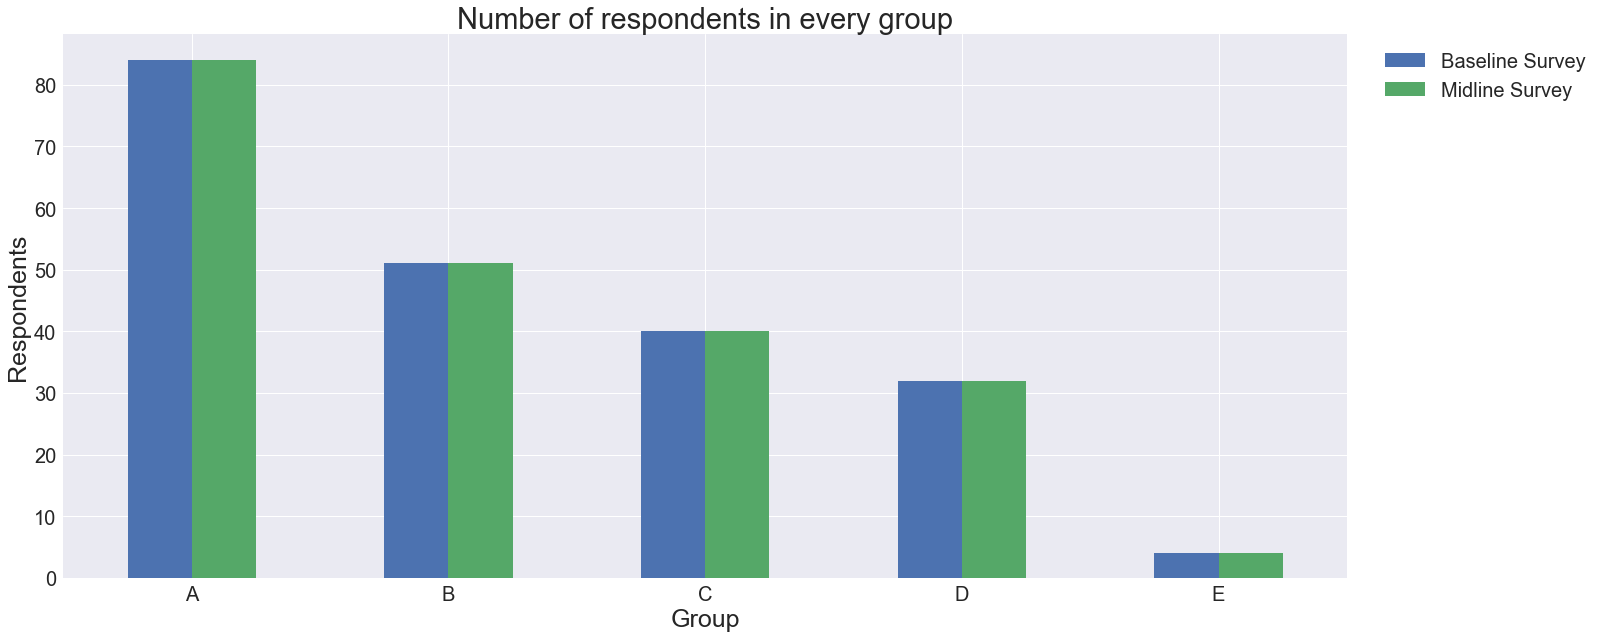

In [59]:
show_diff_between_surveys_clusters(df_cluster1_rem, 
                                   df_merged_lulembela, 
                                   'Count', 
                                   'sum', 
                                   ['Baseline Survey', 'Midline Survey'],
                                   'Number of respondents in every group',
                                   'Respondents', (1.2, 1.0))

Show chart of average water consumption for each cluster/group in Lulembela

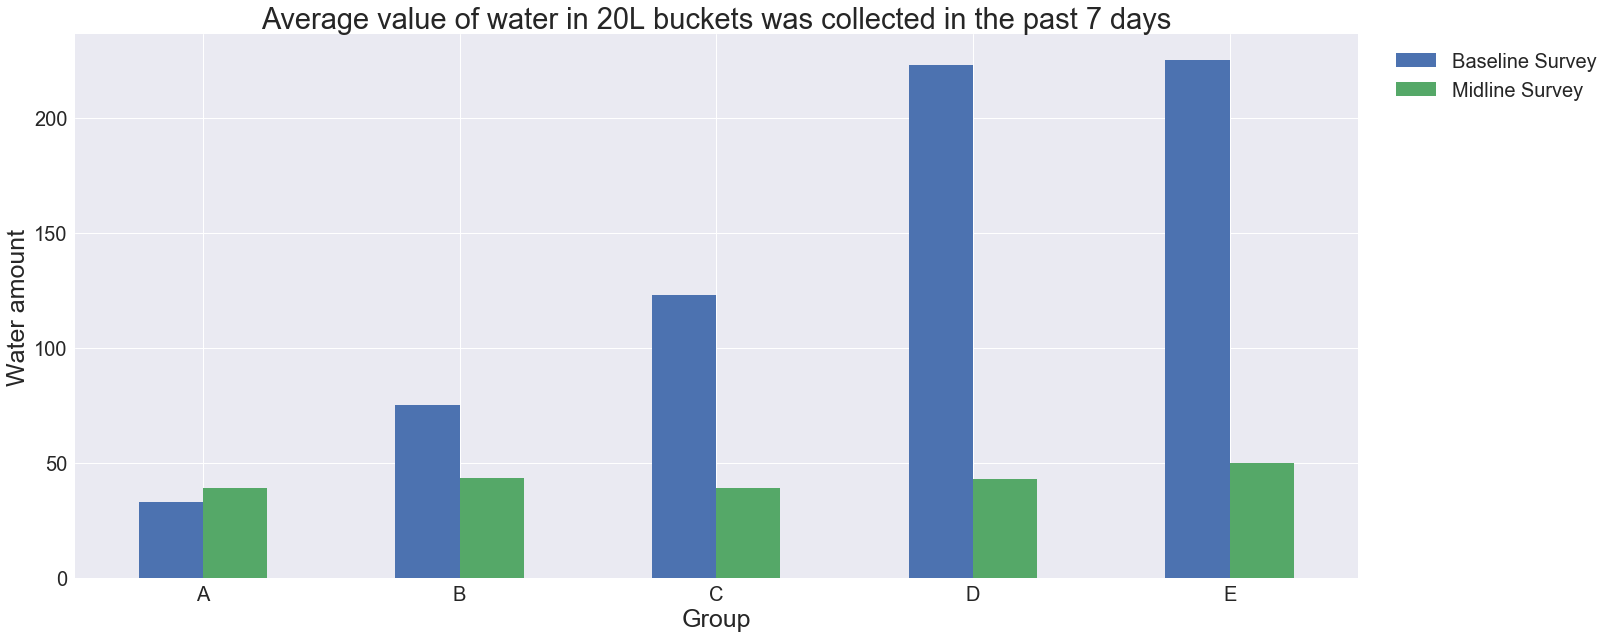

In [60]:
show_diff_between_surveys_clusters(df_cluster1_rem, 
                                   df_merged_lulembela, 
                                   'AmountOfWater', 
                                   'mean', 
                                   ['Baseline Survey', 'Midline Survey'],
                                   'Average value of water in 20L buckets was collected in the past 7 days',
                                   'Water amount', (1.2, 1.0))

Show chart of common water consumption for each cluster/group in Lulembela

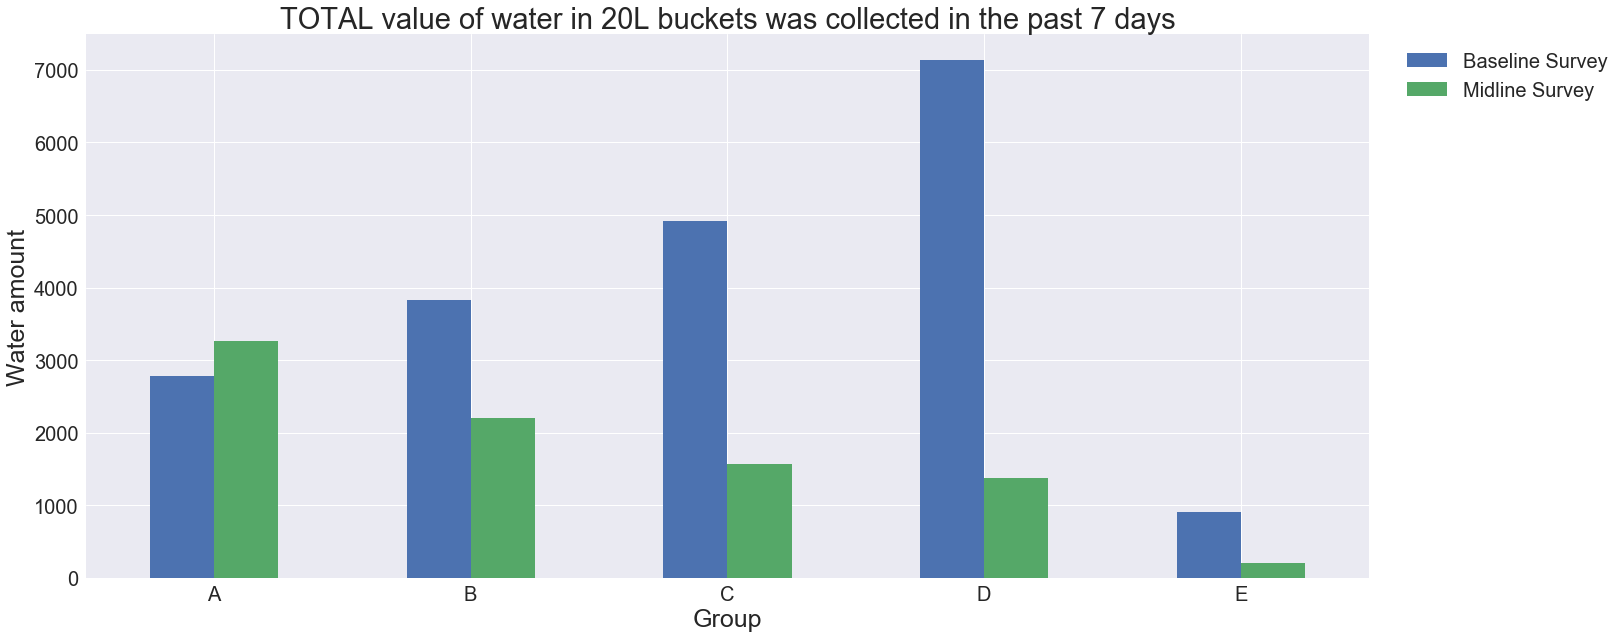

In [61]:
show_diff_between_surveys_clusters(df_cluster1_rem, 
                                   df_merged_lulembela, 
                                   'AmountOfWater', 
                                   'sum', 
                                   ['Baseline Survey', 'Midline Survey'],
                                   'TOTAL value of water in 20L buckets was collected in the past 7 days',
                                   'Water amount', (1.2, 1.0))

Show chart of average value how much money were spent on water for each cluster/group in Lulembela

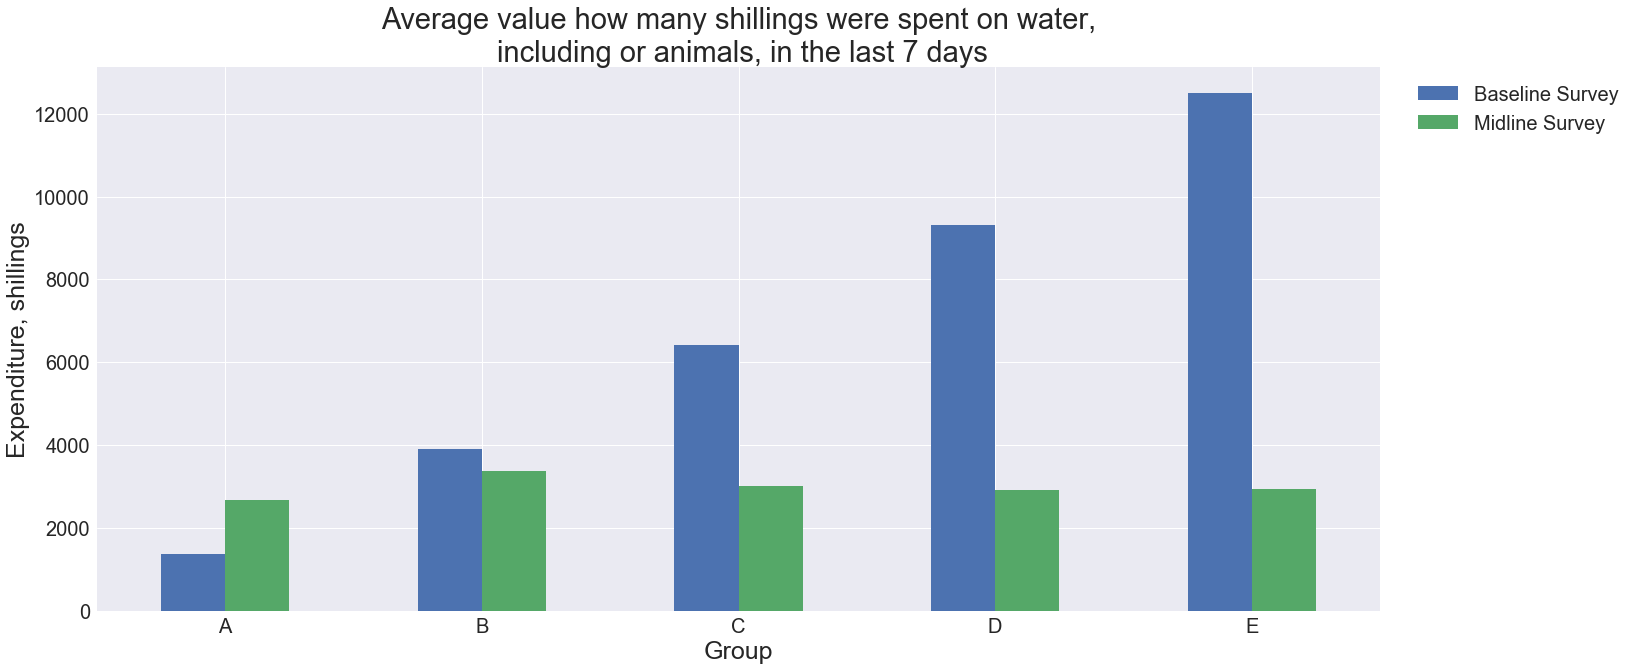

In [62]:
show_diff_between_surveys_clusters(df_cluster1_rem, 
                                   df_merged_lulembela, 
                                   'WaterExpenditure', 
                                   'mean', 
                                   ['Baseline Survey', 'Midline Survey'],
                                   'Average value how many shillings were spent on water,\n including or animals, in the last 7 days',
                                   'Expenditure, shillings', (1.2, 1.0))

Show chart of common value how much money were spent on water for each cluster/group in Lulembela

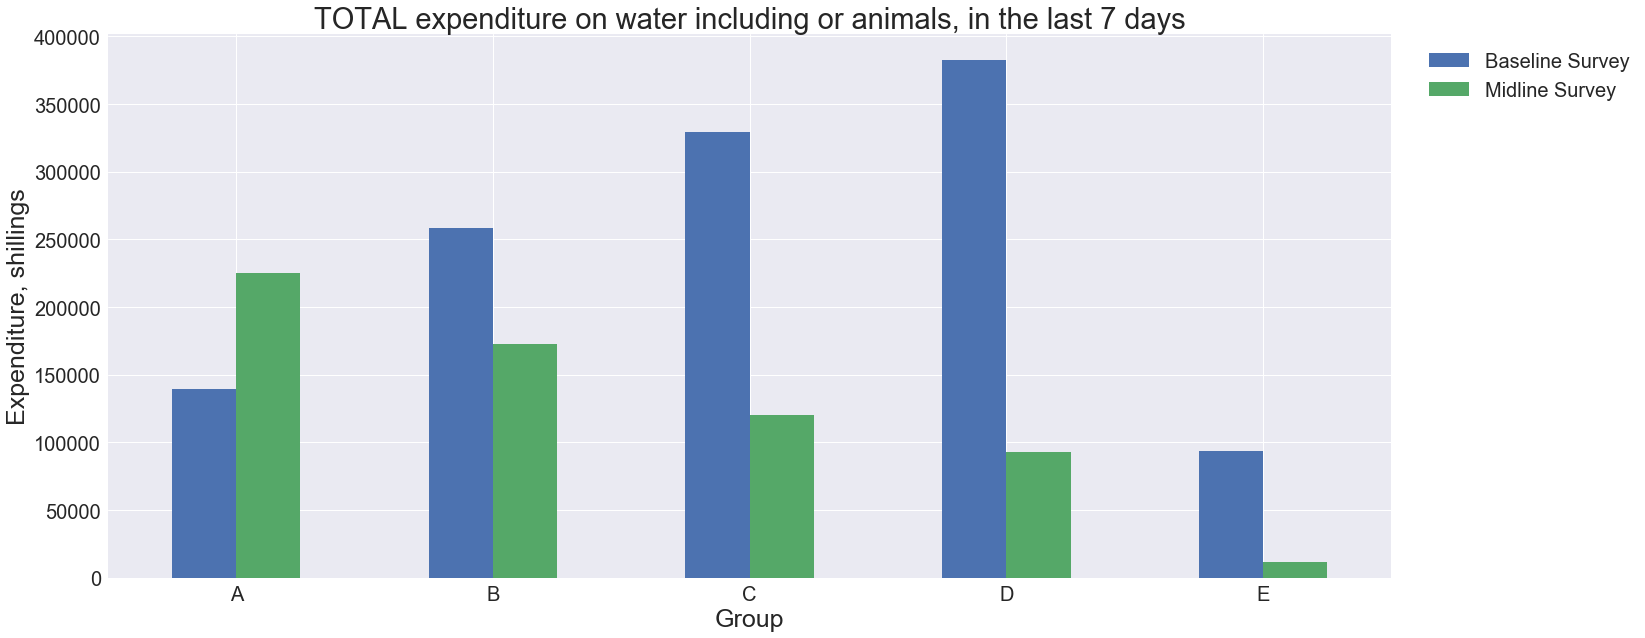

In [63]:
show_diff_between_surveys_clusters(df_cluster1, 
                                   df_merged_lulembela, 
                                   'WaterExpenditure', 
                                   'sum', 
                                   ['Baseline Survey', 'Midline Survey'],
                                   'TOTAL expenditure on water including or animals, in the last 7 days',
                                   'Expenditure, shillings', (1.2, 1.0))

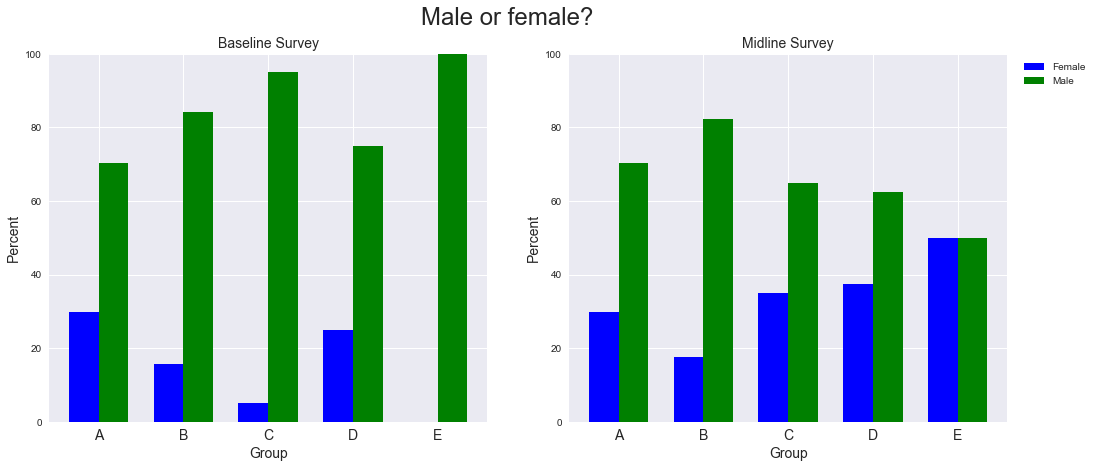

In [64]:
show_diff_for_surveys_clusters({'Baseline Survey': df_cluster1_rem, 'Midline Survey': df_merged_lulembela}, 'Gender',
                               'Male or female?', {0 : 'Female', 1: 'Male'}, (1.2, 1.0))

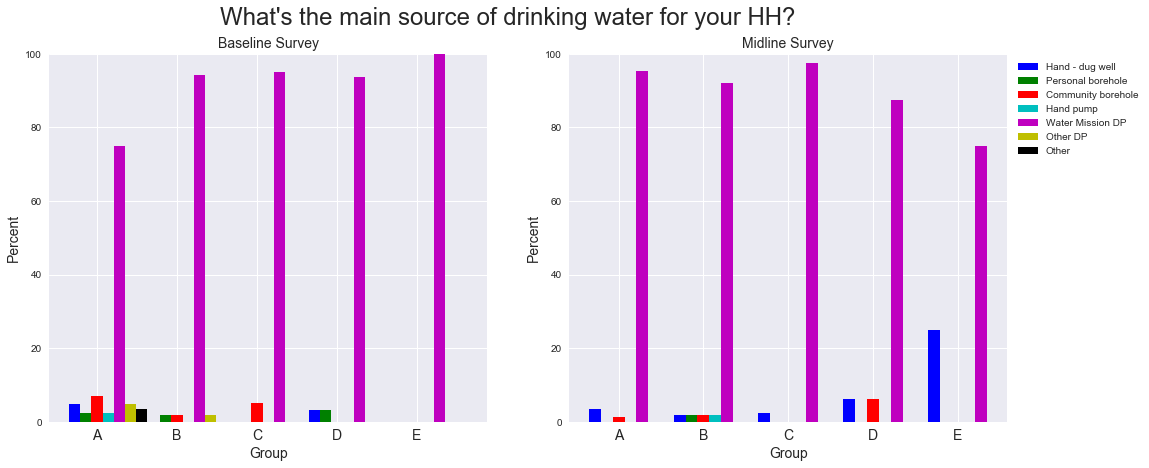

In [65]:
dict_sow ={ 1: 'Hand - dug well', 2: 'Personal borehole', 3:'Community borehole', 4:'Hand pump', 5:'Water Mission DP', 
           6: 'Other DP', 7:'Natural surface water', 8: 'Other' }
show_diff_for_surveys_clusters({'Baseline Survey': df_cluster1_rem, 'Midline Survey': df_merged_lulembela}, 'PrimarySource',
                      "What's the main source of drinking water for your HH?", dict_sow , (1.32, 1.0), width=0.14)

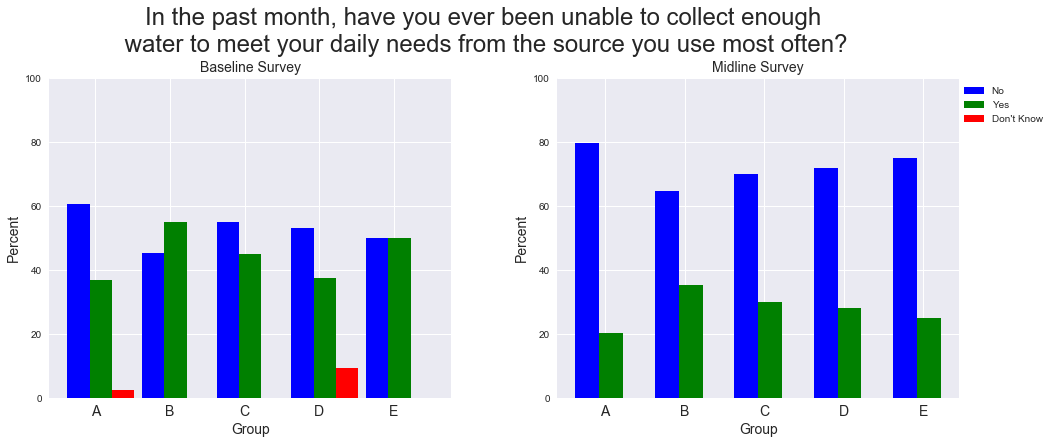

In [66]:
show_diff_for_surveys_clusters({'Baseline Survey': df_cluster1_rem, 'Midline Survey': df_merged_lulembela}, 'WaterAvailability',
                      'In the past month, have you ever been unable to collect enough\n water to meet your daily needs from the source you use most often?',
                      {0 : 'No', 1: 'Yes', 88: "Don't Know" }, (1.23, 1.0) , width=0.3, pad=4)

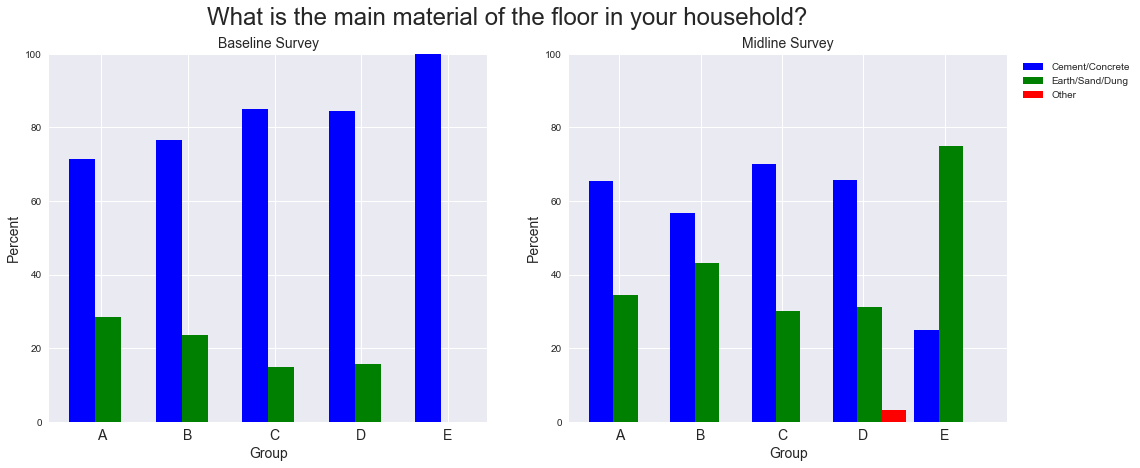

In [67]:
show_diff_for_surveys_clusters({'Baseline Survey': df_cluster1_rem, 'Midline Survey': df_merged_lulembela}, 'FloorMaterial',
                      'What is the main material of the floor in your household?',
                      {0 : 'Cement/Concrete', 1: 'Earth/Sand/Dung', 3: 'Other'}, (1.3, 1.0), width=0.3)

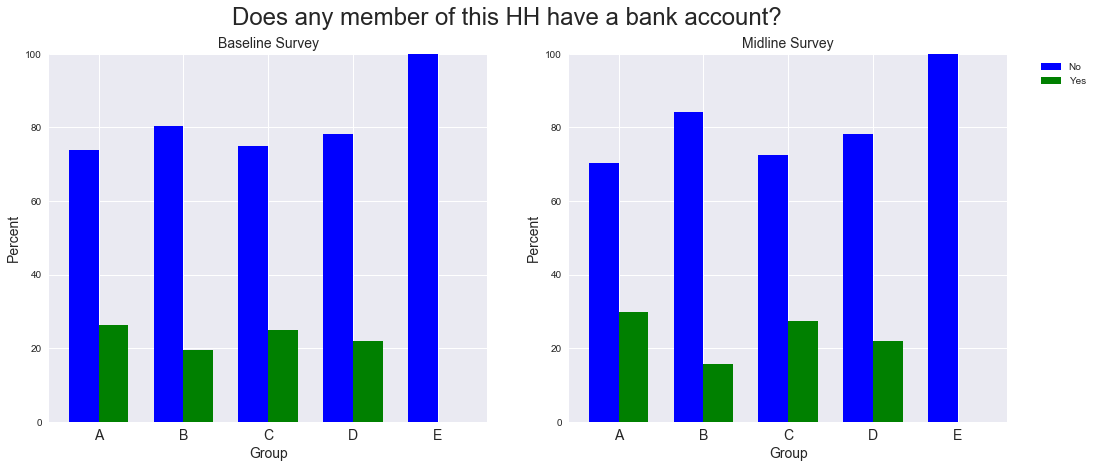

In [68]:
show_diff_for_surveys_clusters({'Baseline Survey': df_cluster1_rem, 'Midline Survey': df_merged_lulembela}, 'BankAccount',
                      'Does any member of this HH have a bank account?', {0 : 'No', 1: 'Yes'}, (1.2, 1.0))

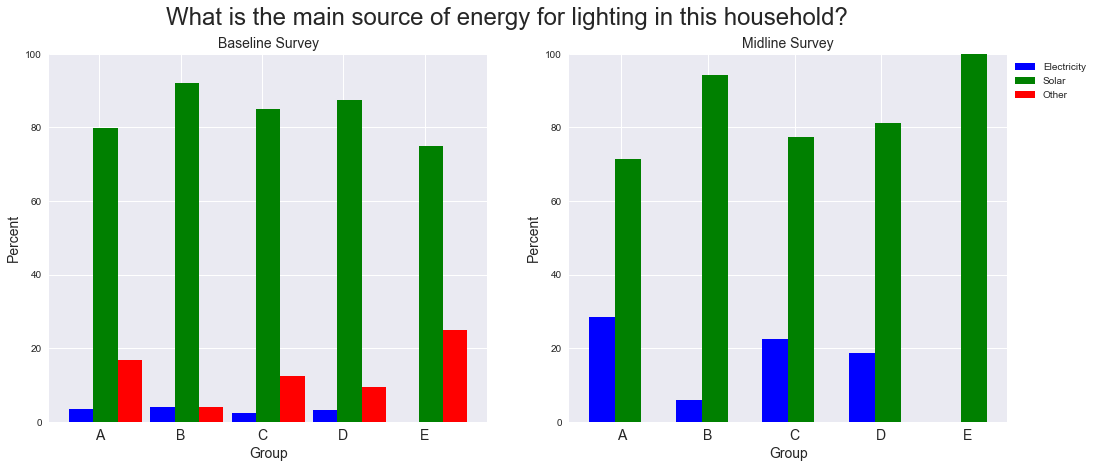

In [69]:
show_diff_for_surveys_clusters({'Baseline Survey': df_cluster1_rem, 'Midline Survey': df_merged_lulembela}, 'SourceOfLighting',
                      'What is the main source of energy for lighting in this household?',
                      {1 : 'Electricity', 2: 'Solar', 3: 'Other'}, (1.2, 1.0), width=0.3)

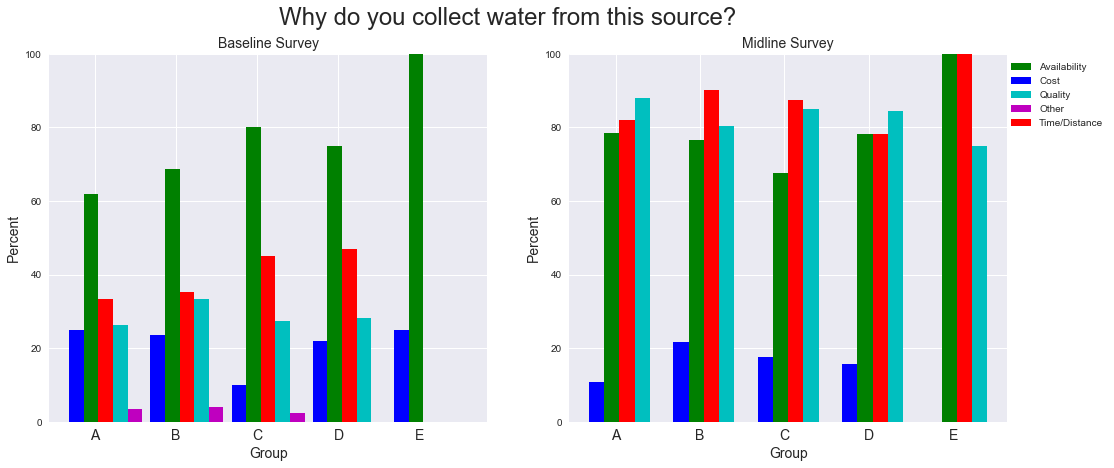

In [70]:
show_diff_props_surveys_clusters({'Baseline Survey': df_cluster1_rem, 'Midline Survey': df_merged_lulembela},
                                 {'Baseline Survey': ['Reason/Cost', 'Reason/Availability', 'Reason/Time_Distance',
                                                      'Reason/Quality', 'Reason/Other'], 
                                  'Midline Survey': ['Reason/Cost', 'Reason/Availability', 'Reason/Time_Distance',
                                                     'Reason/Quality']},
                                 'Why do you collect water from this source?',
                                 {'Reason/Cost': 'Cost', 'Reason/Availability': 'Availability', 
                                   'Reason/Time_Distance': 'Time/Distance', 'Reason/Quality': 'Quality',
                                   'Reason/Other': 'Other'},
                                 (1.24, 1.0), width=0.18)

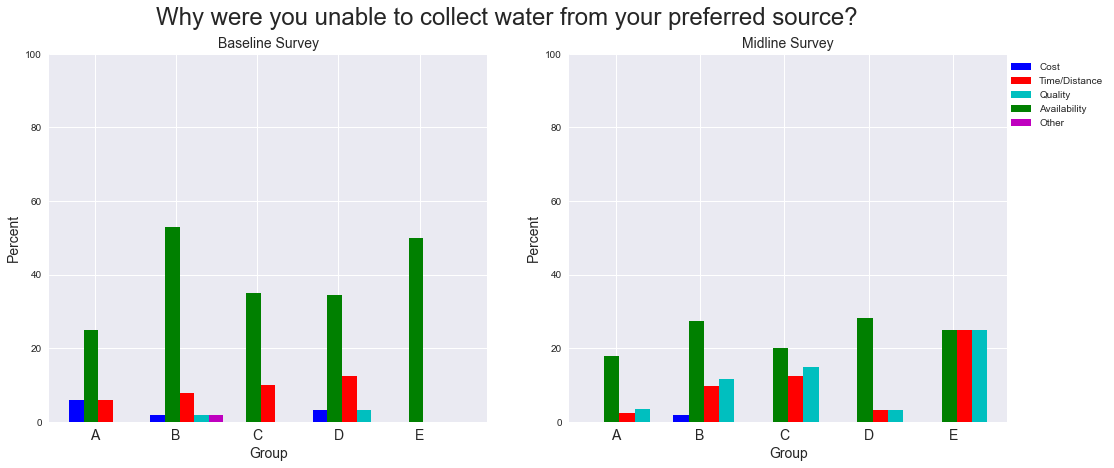

In [71]:
show_diff_props_surveys_clusters({'Baseline Survey': df_cluster1_rem, 'Midline Survey': df_merged_lulembela},
                                 {'Baseline Survey': ['AvailReason/Cost', 'AvailReason/Availability', 'AvailReason/Time_Distance',
                                                      'AvailReason/Quality', 'AvailReason/Other'], 
                                  'Midline Survey': ['AvailReason/Cost', 'AvailReason/Availability',
                                                     'AvailReason/Time_Distance', 'AvailReason/Quality']},
                                 'Why were you unable to collect water from your preferred source?',
                                 {'AvailReason/Cost': 'Cost', 'AvailReason/Availability': 'Availability', 
                                   'AvailReason/Time_Distance': 'Time/Distance', 'AvailReason/Quality': 'Quality',
                                   'AvailReason/Other': 'Other'},
                                 (1.24, 1.0), width=0.18)

<a id='comparing_lulembela_comm'></a>
### Difference  on the community level

In [72]:
df_merged_lulembela.rename(inplace=True, columns={'CommName_x': 'CommName'})

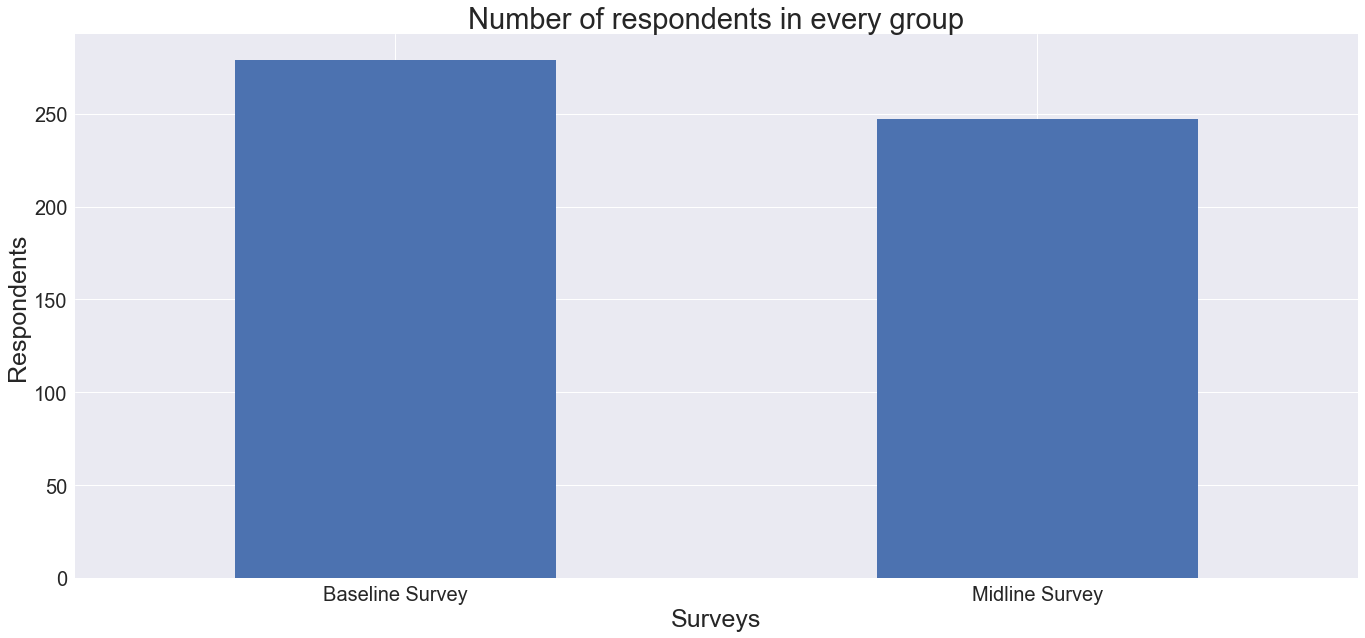

In [73]:
show_diff_between_surveys(df_Lulembela, 
                          df_Lulembela_m, 
                          'Count', 
                          np.sum, 
                          ['Baseline Survey', 'Midline Survey'],
                          'Number of respondents in every group',
                          'Respondents', (1.2, 1.0))

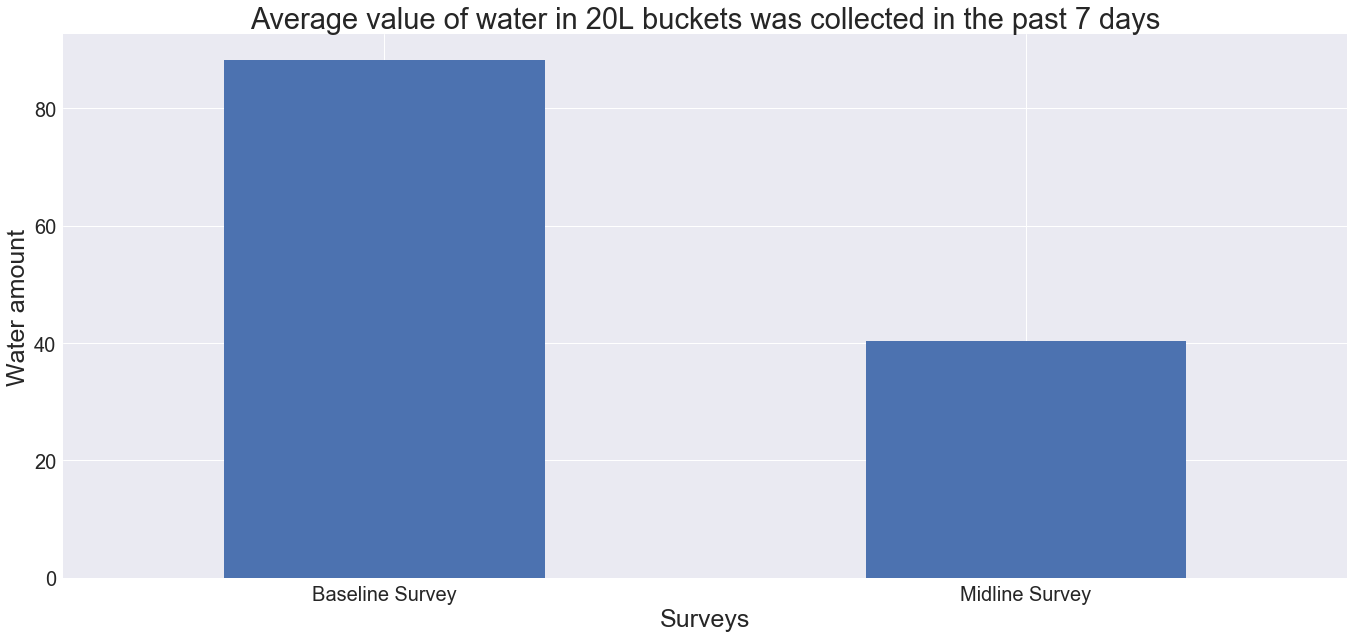

In [74]:
show_diff_between_surveys(df_Lulembela, 
                          df_Lulembela_m, 
                          'AmountOfWater', 
                          np.mean, 
                          ['Baseline Survey', 'Midline Survey'],
                          'Average value of water in 20L buckets was collected in the past 7 days',
                          'Water amount', (1.2, 1.0))

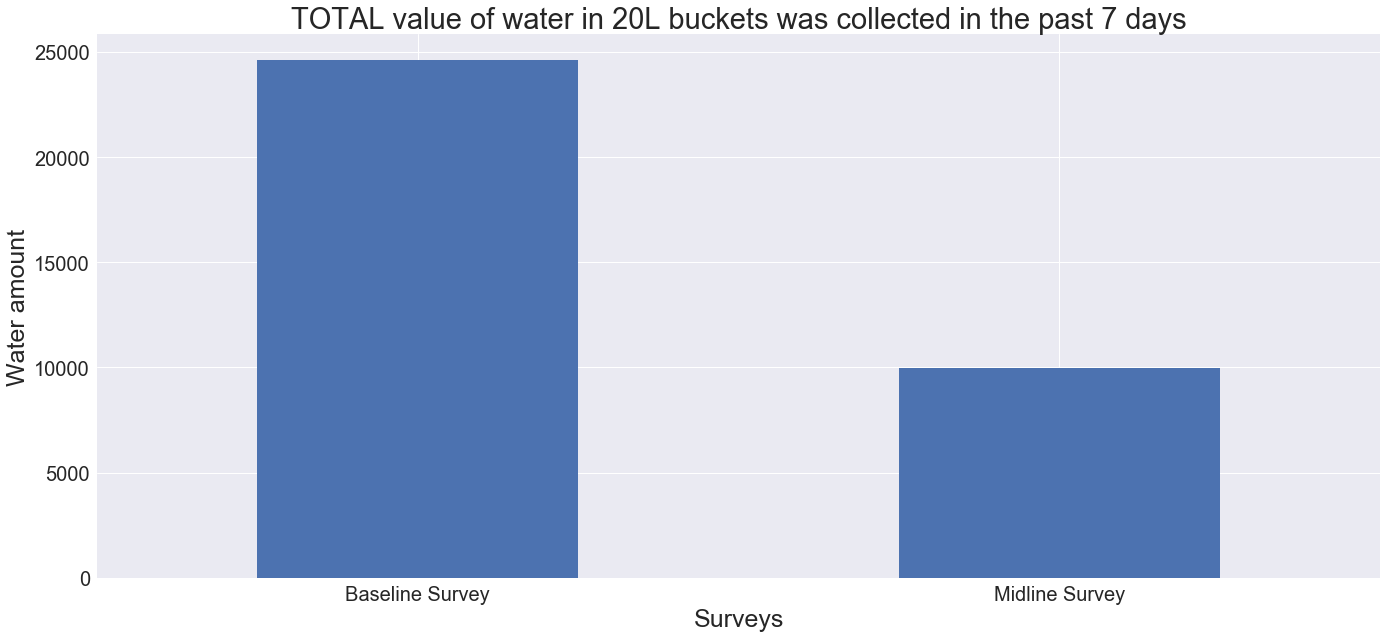

In [75]:
show_diff_between_surveys(df_Lulembela, 
                          df_Lulembela_m, 
                          'AmountOfWater', 
                          np.sum, 
                          ['Baseline Survey', 'Midline Survey'],
                          'TOTAL value of water in 20L buckets was collected in the past 7 days',
                          'Water amount', (1.2, 1.0))

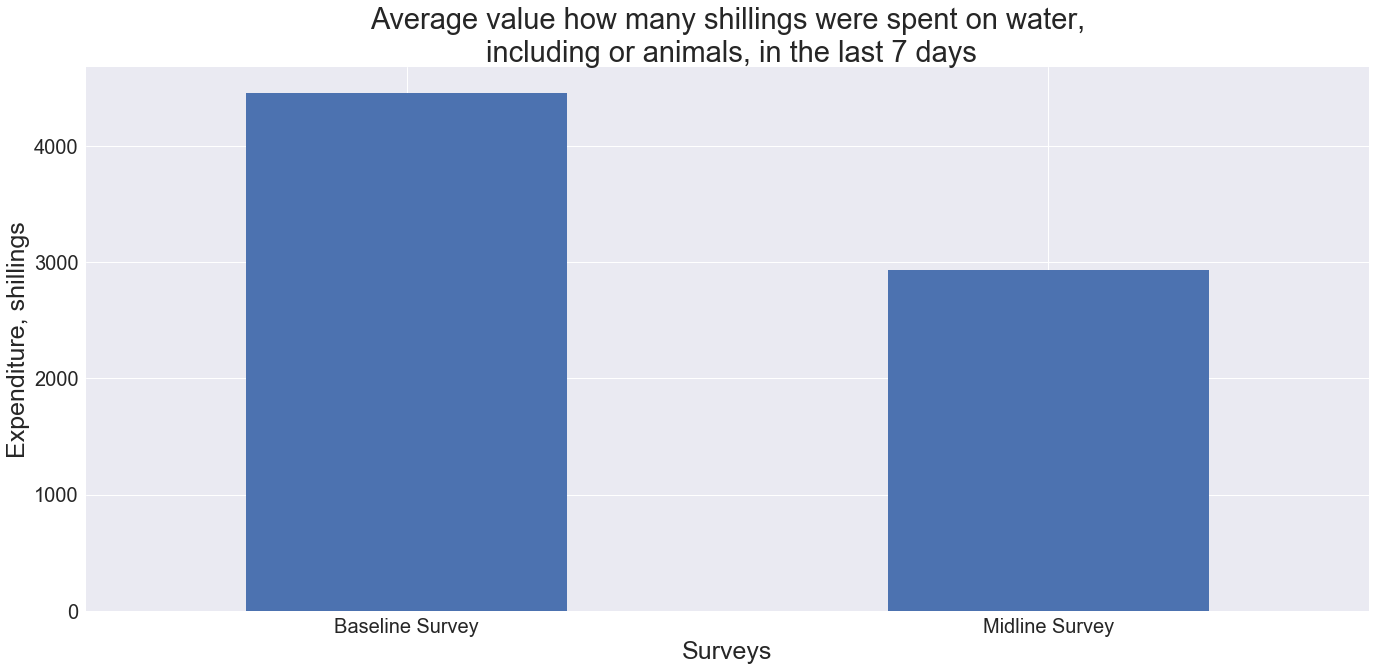

In [76]:
show_diff_between_surveys(df_Lulembela, 
                          df_Lulembela_m, 
                          'WaterExpenditure', 
                          np.mean, 
                          ['Baseline Survey', 'Midline Survey'],
                          'Average value how many shillings were spent on water,\n including or animals, in the last 7 days',
                          'Expenditure, shillings', (1.2, 1.0))

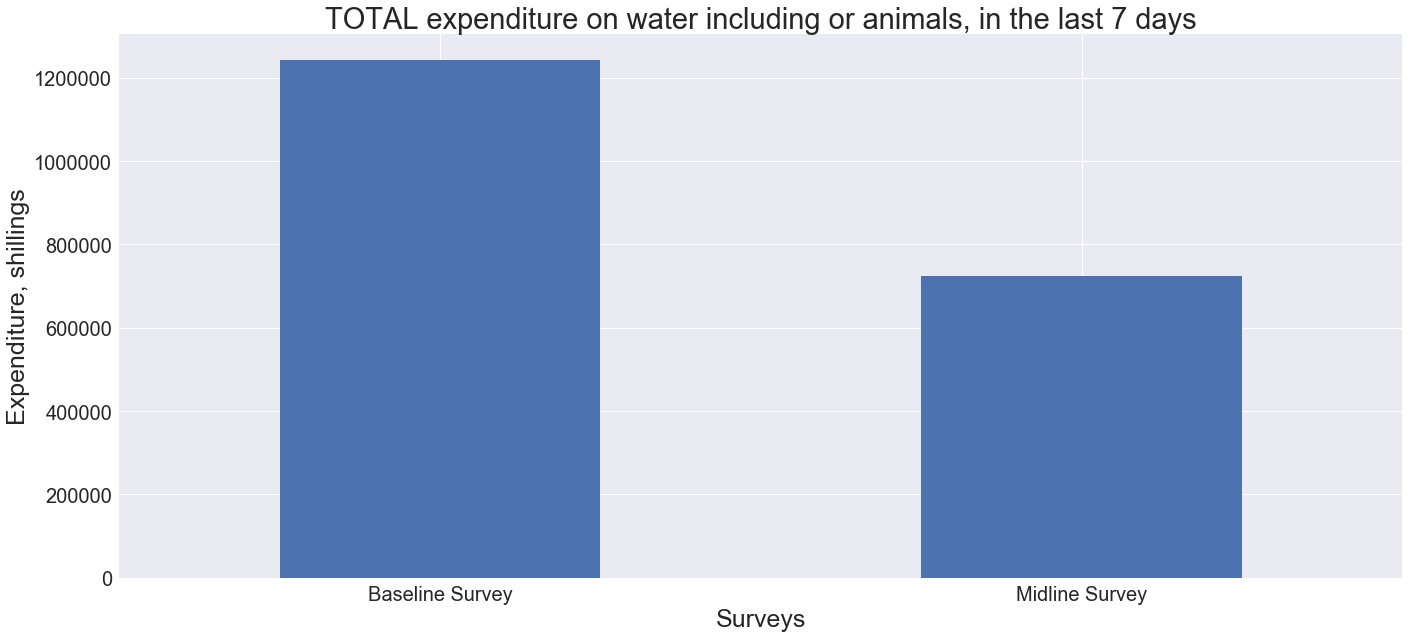

In [77]:
show_diff_between_surveys(df_Lulembela, 
                          df_Lulembela_m, 
                          'WaterExpenditure', 
                          np.sum, 
                          ['Baseline Survey', 'Midline Survey'],
                          'TOTAL expenditure on water including or animals, in the last 7 days',
                          'Expenditure, shillings', (1.2, 1.0))

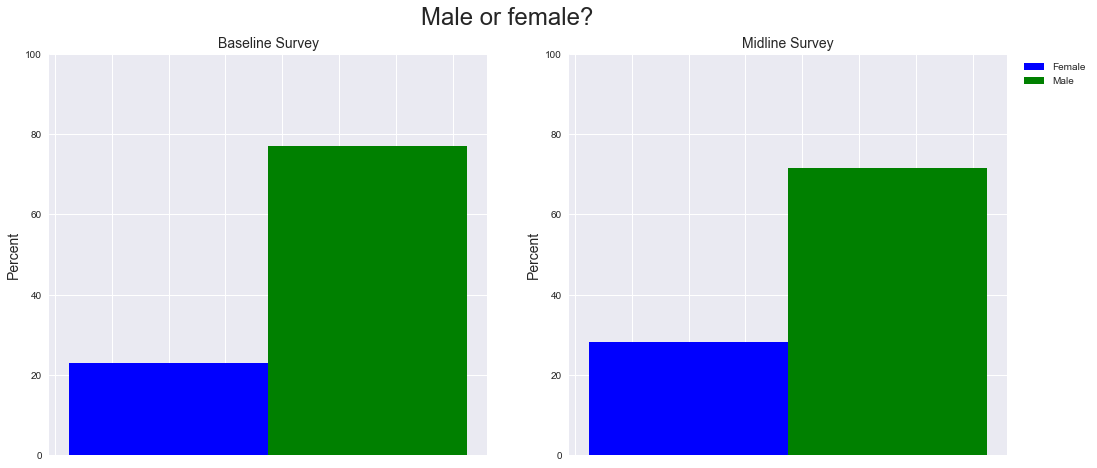

In [78]:
show_diff_for_surveys({'Baseline Survey': df_Lulembela, 'Midline Survey': df_Lulembela_m}, 'Gender',
                      'Male or female?', {0 : 'Female', 1: 'Male'}, (1.2, 1.0))

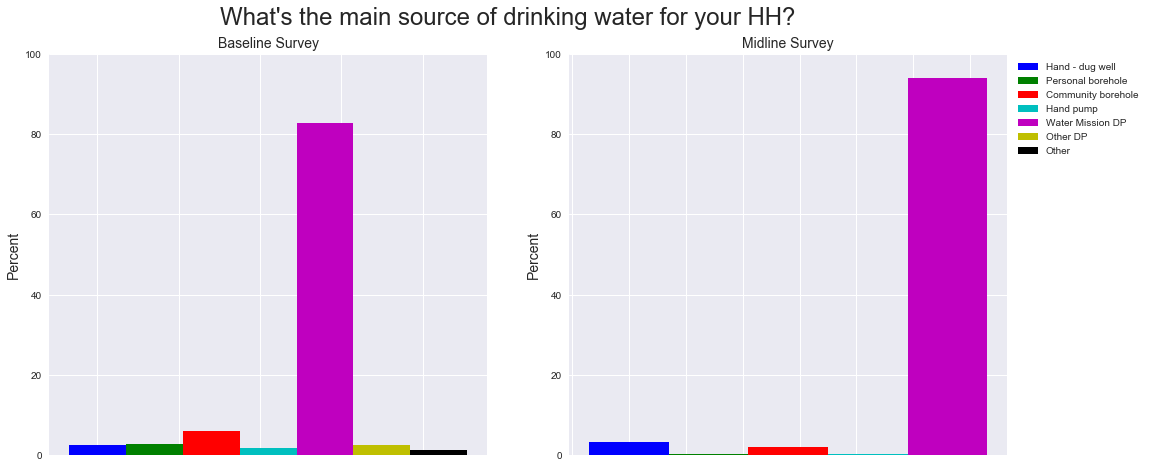

In [79]:
dict_sow ={ 1: 'Hand - dug well', 2: 'Personal borehole', 3:'Community borehole', 4:'Hand pump', 5:'Water Mission DP', 
           6: 'Other DP', 7:'Natural surface water', 8: 'Other' }
show_diff_for_surveys({'Baseline Survey': df_Lulembela, 'Midline Survey': df_Lulembela_m}, 'PrimarySource',
                      "What's the main source of drinking water for your HH?", dict_sow , (1.32, 1.0), width=0.14)

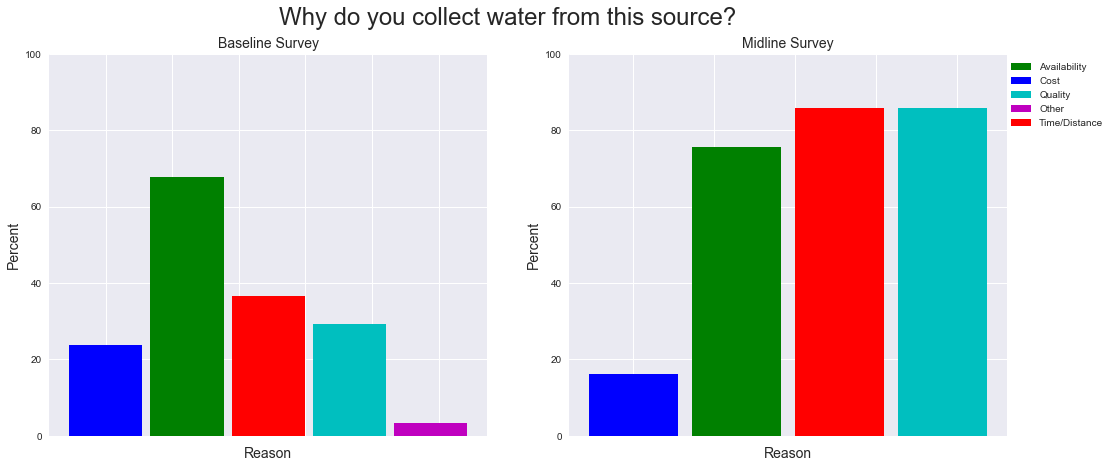

In [80]:
show_diff_props_surveys({'Baseline Survey': df_Lulembela, 'Midline Survey': df_Lulembela_m},
                                 {'Baseline Survey': ['Reason/Cost', 'Reason/Availability', 'Reason/Time_Distance',
                                                      'Reason/Quality', 'Reason/Other'], 
                                  'Midline Survey': ['Reason/Cost', 'Reason/Availability', 'Reason/Time_Distance',
                                                     'Reason/Quality']},
                                 'Why do you collect water from this source?',
                                 {'Reason/Cost': 'Cost', 'Reason/Availability': 'Availability', 
                                   'Reason/Time_Distance': 'Time/Distance', 'Reason/Quality': 'Quality',
                                   'Reason/Other': 'Other'},
                                 (1.24, 1.0), width=1.1, xlabel='Reason' )

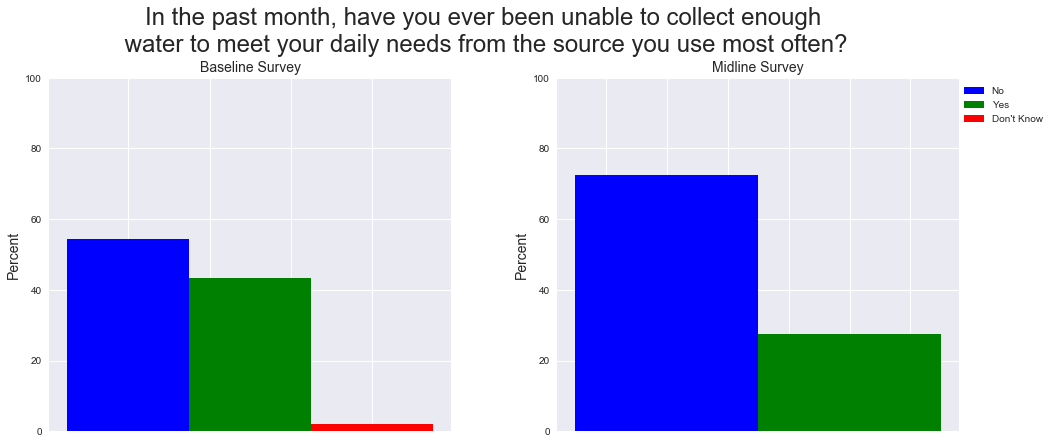

In [81]:
show_diff_for_surveys({'Baseline Survey': df_Lulembela, 'Midline Survey': df_Lulembela_m}, 'WaterAvailability',
                      'In the past month, have you ever been unable to collect enough\n water to meet your daily needs from the source you use most often?',
                      {0 : 'No', 1: 'Yes', 88: "Don't Know" }, (1.23, 1.0) , width=0.3, pad=4)

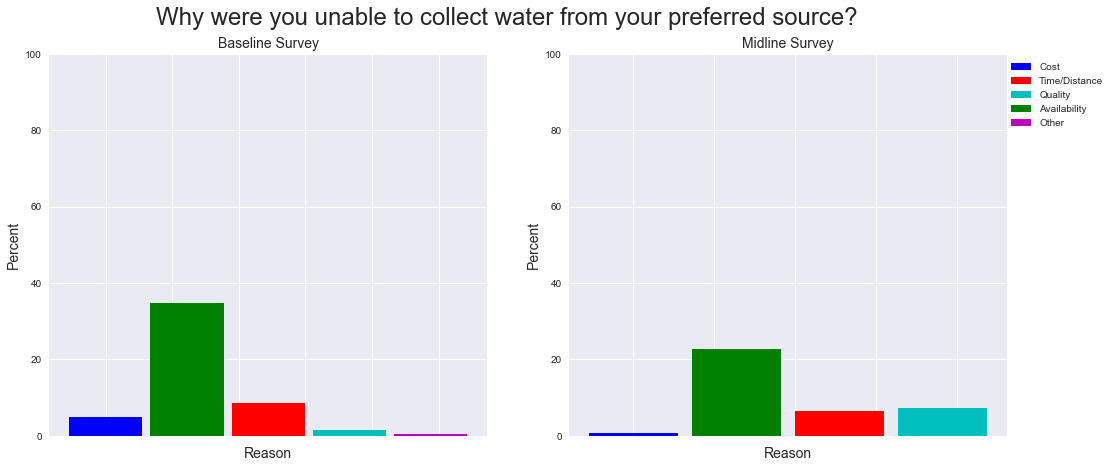

In [82]:
show_diff_props_surveys({'Baseline Survey': df_Lulembela, 'Midline Survey': df_Lulembela_m},
                                 {'Baseline Survey': ['AvailReason/Cost', 'AvailReason/Availability', 'AvailReason/Time_Distance',
                                                      'AvailReason/Quality', 'AvailReason/Other'], 
                                  'Midline Survey': ['AvailReason/Cost', 'AvailReason/Availability',
                                                     'AvailReason/Time_Distance', 'AvailReason/Quality']},
                                 'Why were you unable to collect water from your preferred source?',
                                 {'AvailReason/Cost': 'Cost', 'AvailReason/Availability': 'Availability', 
                                   'AvailReason/Time_Distance': 'Time/Distance', 'AvailReason/Quality': 'Quality',
                                   'AvailReason/Other': 'Other'},
                                 (1.24, 1.0), width=1.1, xlabel='Reason')

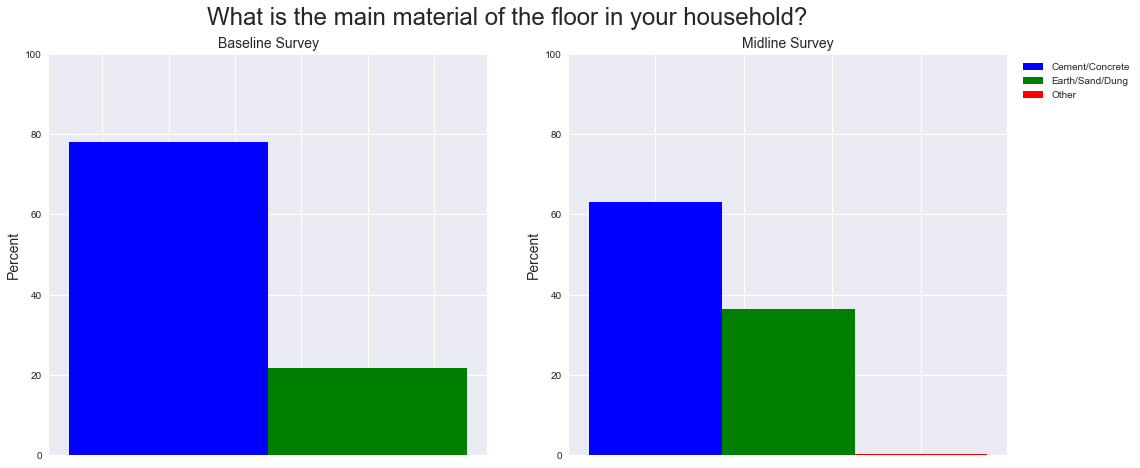

In [83]:
show_diff_for_surveys({'Baseline Survey': df_Lulembela, 'Midline Survey': df_Lulembela_m}, 'FloorMaterial',
                      'What is the main material of the floor in your household?',
                      {0 : 'Cement/Concrete', 1: 'Earth/Sand/Dung', 3: 'Other'}, (1.3, 1.0), width=0.3)

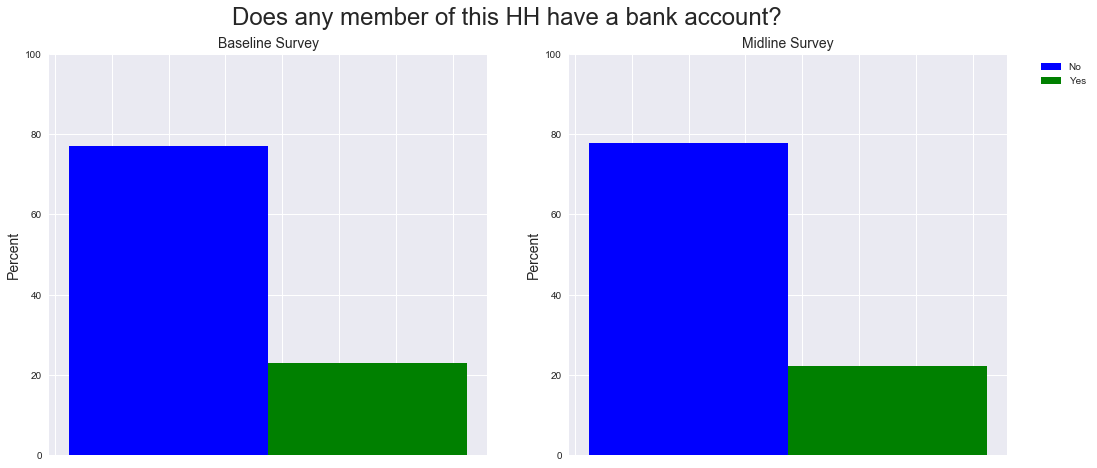

In [84]:
show_diff_for_surveys({'Baseline Survey': df_Lulembela, 'Midline Survey': df_Lulembela_m}, 'BankAccount',
                      'Does any member of this HH have a bank account?', {0 : 'No', 1: 'Yes'}, (1.2, 1.0))

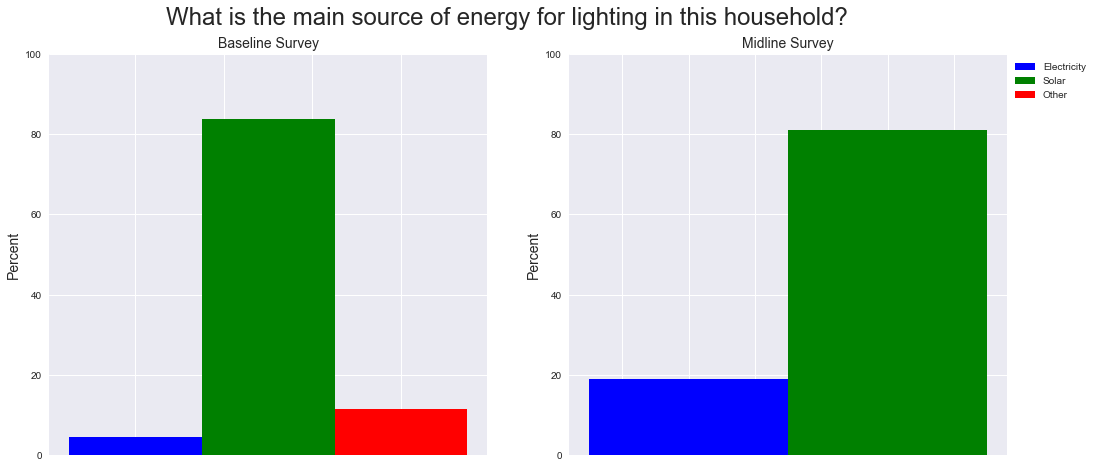

In [85]:
show_diff_for_surveys({'Baseline Survey': df_Lulembela, 'Midline Survey': df_Lulembela_m}, 'SourceOfLighting',
                      'What is the main source of energy for lighting in this household?',
                      {1 : 'Electricity', 2: 'Solar', 3: 'Other'}, (1.2, 1.0), width=0.3)

<a id='comparing_chanhomba'></a>
## Baseline/Midline surveys comparison in Chanhomba

<a id='comparing_chanhomba_groups'></a>
### Difference on the clusters/groups level

Show chart of number of respondents in every group

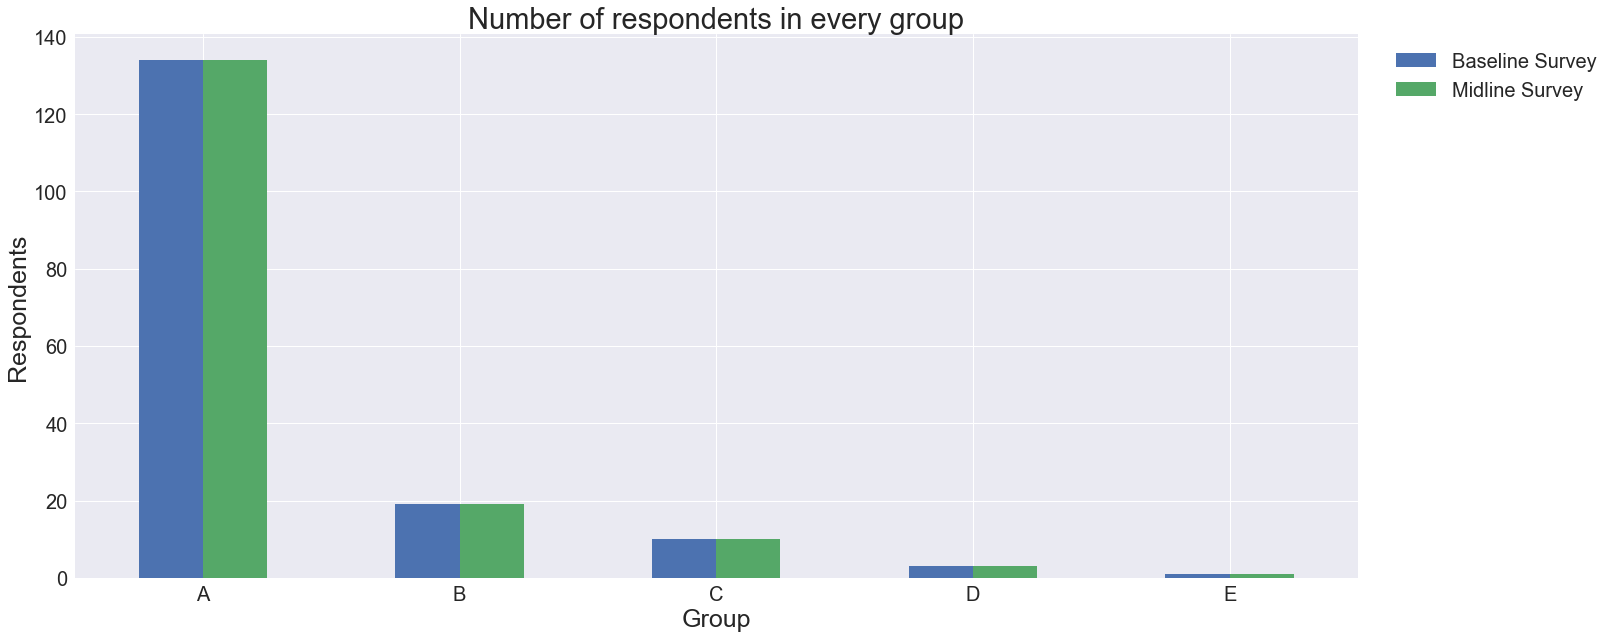

In [86]:
show_diff_between_surveys_clusters(df_cluster2_rem, 
                                   df_merged_chanhomba, 
                                   'Count', 
                                   'sum', 
                                   ['Baseline Survey', 'Midline Survey'],
                                   'Number of respondents in every group',
                                   'Respondents', (1.2, 1.0))

Show chart of average water consumption for each cluster/group in Chanhomba

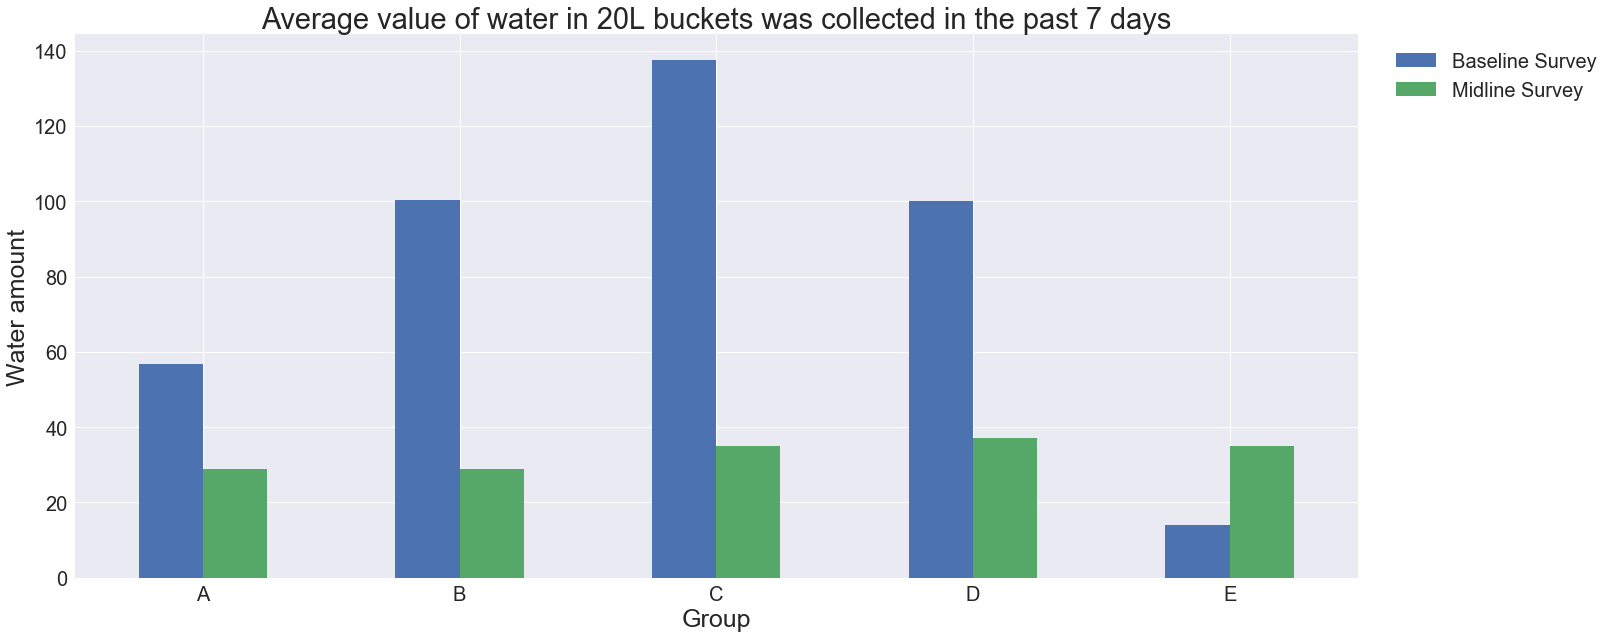

In [87]:
show_diff_between_surveys_clusters(df_cluster2_rem, 
                                   df_merged_chanhomba, 
                                   'AmountOfWater', 
                                   'mean', 
                                   ['Baseline Survey', 'Midline Survey'],
                                   'Average value of water in 20L buckets was collected in the past 7 days',
                                   'Water amount', (1.2, 1.0))

Show chart of common water consumption for each cluster/group in Chanhomba

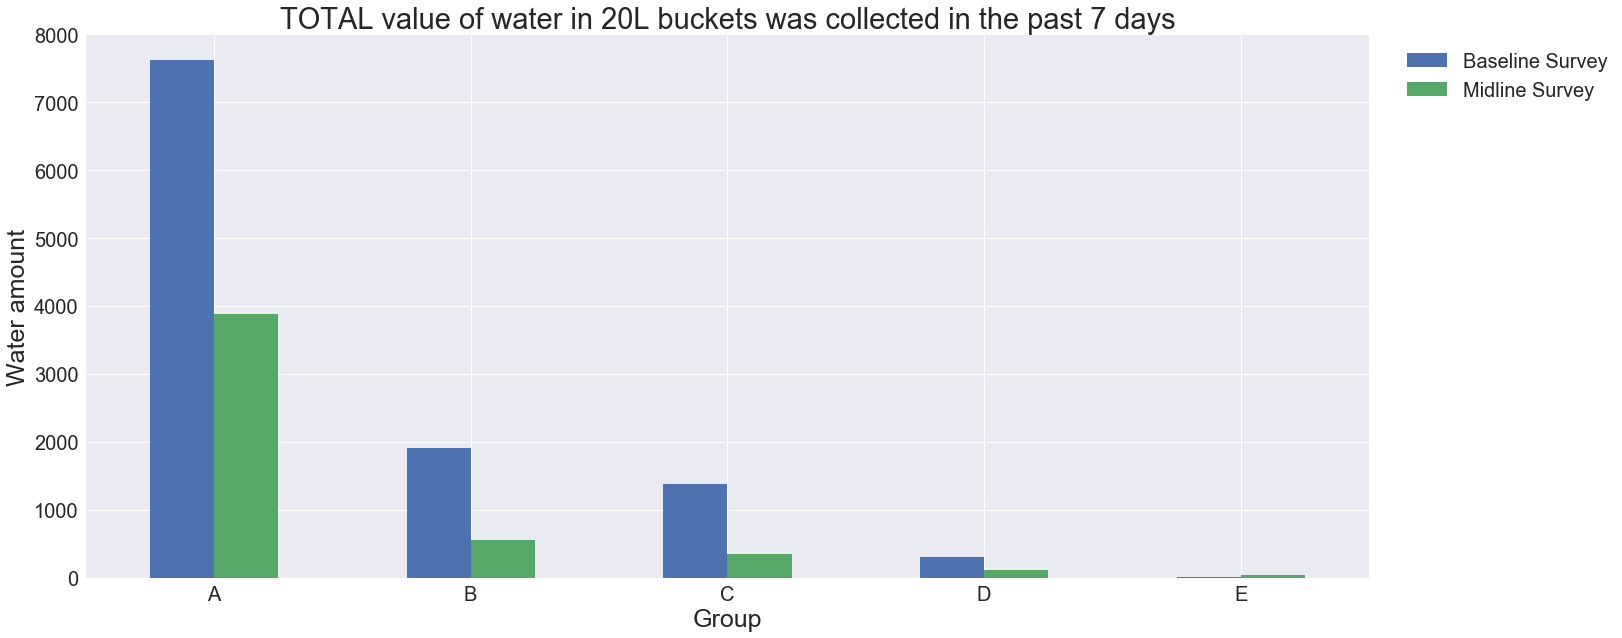

In [88]:
show_diff_between_surveys_clusters(df_cluster2_rem, 
                                   df_merged_chanhomba, 
                                   'AmountOfWater', 
                                   'sum', 
                                   ['Baseline Survey', 'Midline Survey'],
                                   'TOTAL value of water in 20L buckets was collected in the past 7 days',
                                   'Water amount', (1.2, 1.0))

Show chart of average value how much money were spent on water for each cluster/group in Chanhomba

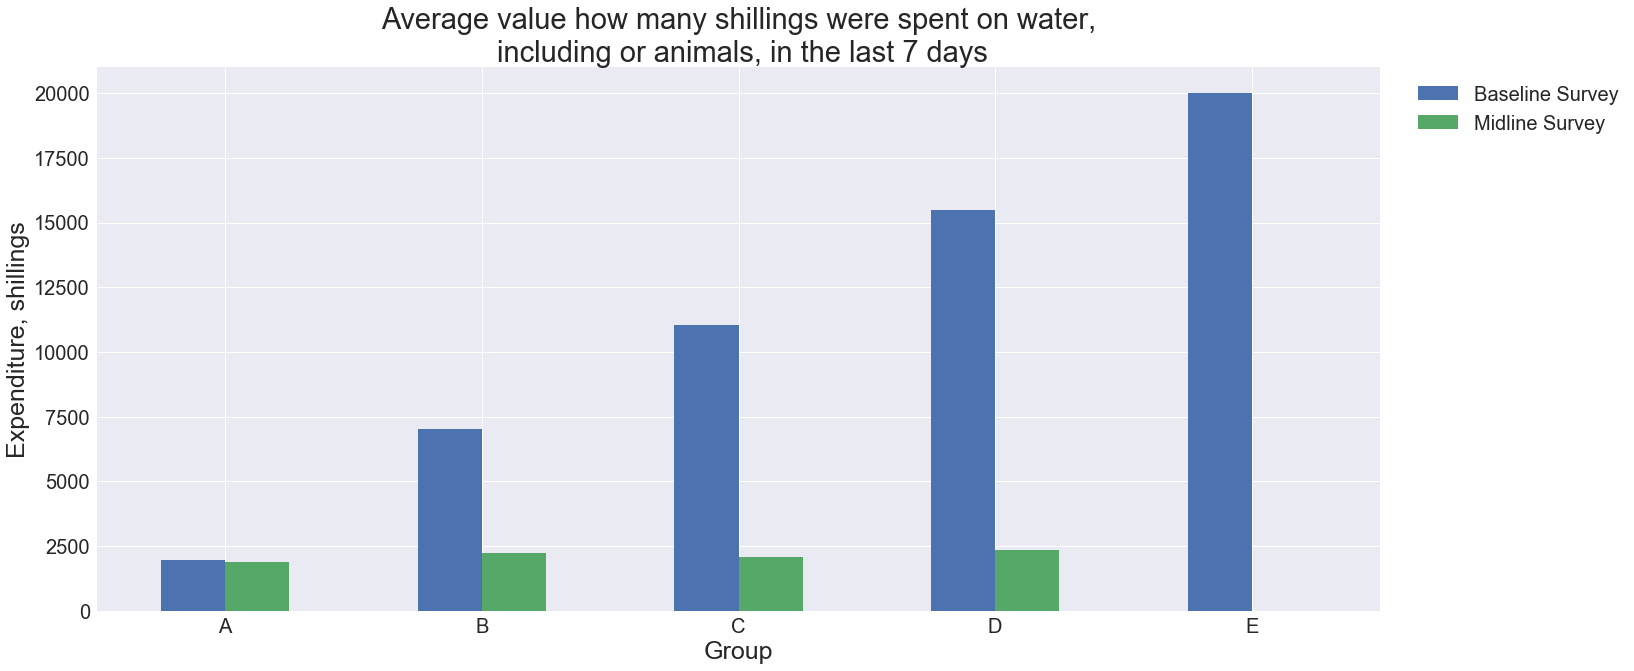

In [89]:
show_diff_between_surveys_clusters(df_cluster2_rem, 
                                   df_merged_chanhomba, 
                                   'WaterExpenditure', 
                                   'mean', 
                                   ['Baseline Survey', 'Midline Survey'],
                                   'Average value how many shillings were spent on water,\n including or animals, in the last 7 days',
                                   'Expenditure, shillings', (1.2, 1.0))

Show chart of common value how much money were spent on water for each cluster/group in Chanhomba

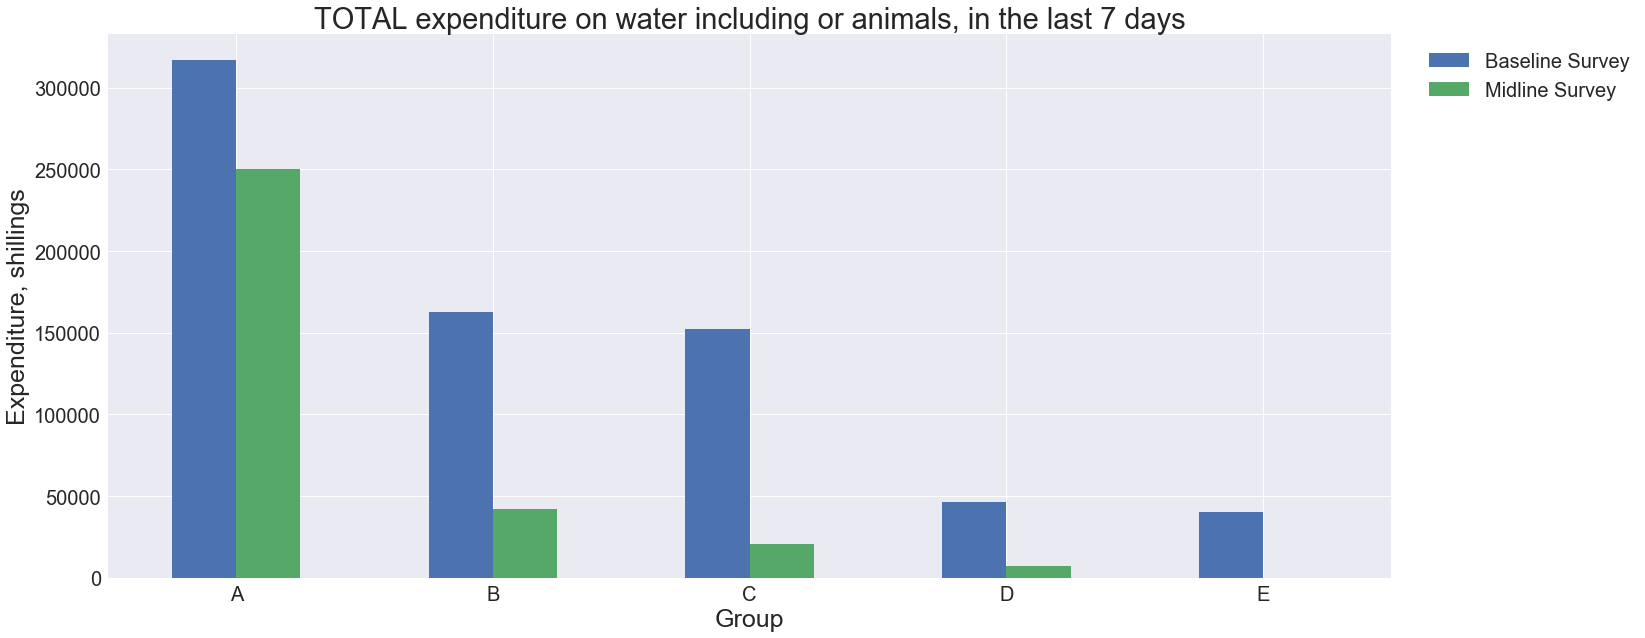

In [90]:
show_diff_between_surveys_clusters(df_cluster2, 
                                   df_merged_chanhomba, 
                                   'WaterExpenditure', 
                                   'sum', 
                                   ['Baseline Survey', 'Midline Survey'],
                                   'TOTAL expenditure on water including or animals, in the last 7 days',
                                   'Expenditure, shillings', (1.2, 1.0))

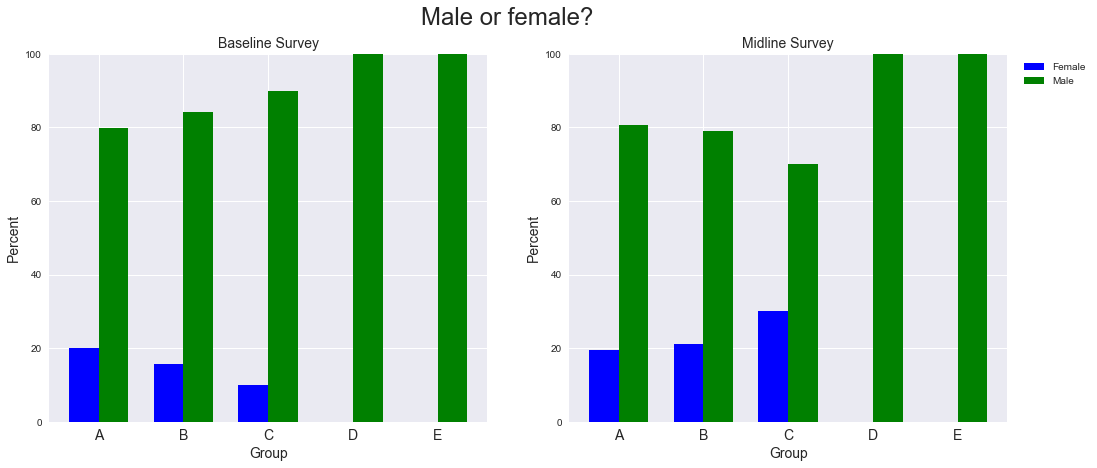

In [91]:
show_diff_for_surveys_clusters({'Baseline Survey': df_cluster2_rem, 'Midline Survey': df_merged_chanhomba}, 'Gender',
                               'Male or female?', {0 : 'Female', 1: 'Male'}, (1.2, 1.0))

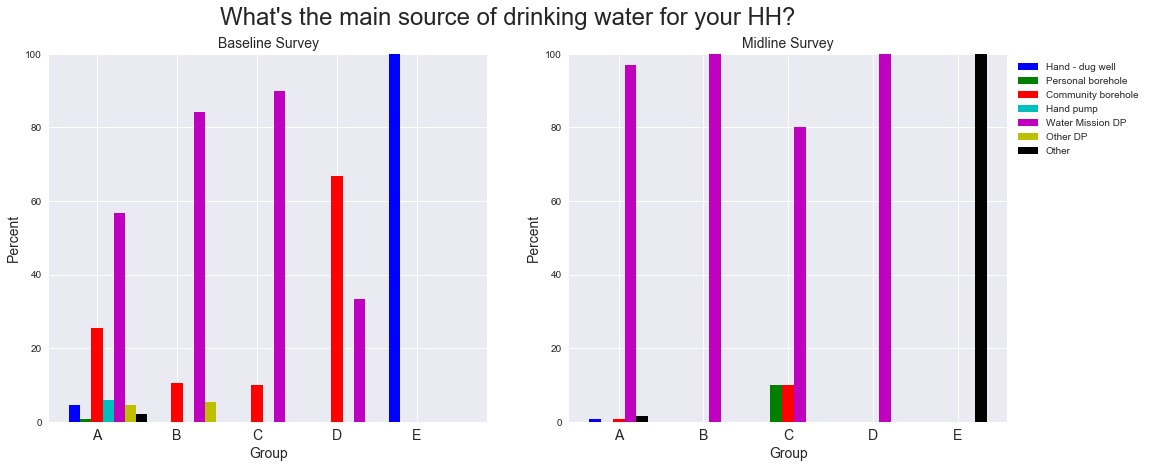

In [92]:
dict_sow ={ 1: 'Hand - dug well', 2: 'Personal borehole', 3:'Community borehole', 4:'Hand pump', 5:'Water Mission DP', 
           6: 'Other DP', 7:'Natural surface water', 8: 'Other' }
show_diff_for_surveys_clusters({'Baseline Survey': df_cluster2_rem, 'Midline Survey': df_merged_chanhomba}, 'PrimarySource',
                               "What's the main source of drinking water for your HH?", dict_sow , (1.32, 1.0), width=0.14)

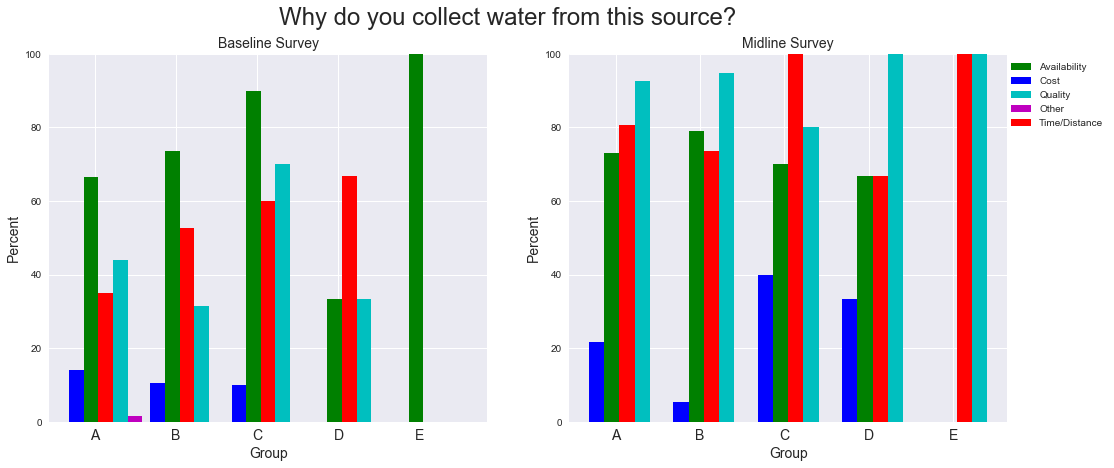

In [93]:
show_diff_props_surveys_clusters({'Baseline Survey': df_cluster2_rem, 'Midline Survey': df_merged_chanhomba},
                                 {'Baseline Survey': ['Reason/Cost', 'Reason/Availability', 'Reason/Time_Distance',
                                                      'Reason/Quality', 'Reason/Other'], 
                                  'Midline Survey': ['Reason/Cost', 'Reason/Availability', 'Reason/Time_Distance',
                                                     'Reason/Quality']},
                                 'Why do you collect water from this source?',
                                 {'Reason/Cost': 'Cost', 'Reason/Availability': 'Availability', 
                                   'Reason/Time_Distance': 'Time/Distance', 'Reason/Quality': 'Quality',
                                   'Reason/Other': 'Other'},
                                 (1.24, 1.0), width=0.18)

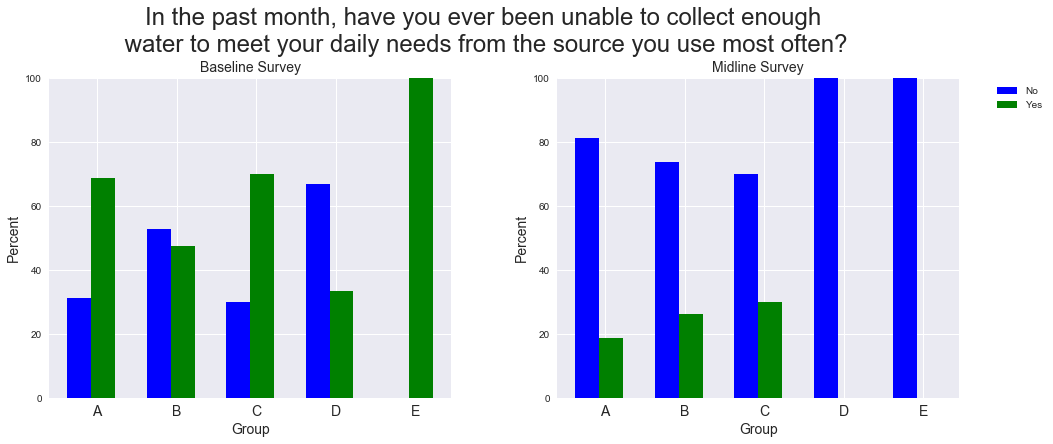

In [94]:
show_diff_for_surveys_clusters({'Baseline Survey': df_cluster2_rem, 'Midline Survey': df_merged_chanhomba}, 'WaterAvailability',
                               'In the past month, have you ever been unable to collect enough\n water to meet your daily needs from the source you use most often?',
                               {0 : 'No', 1: 'Yes', 88: "Don't Know" }, (1.23, 1.0) , width=0.3, pad=4)

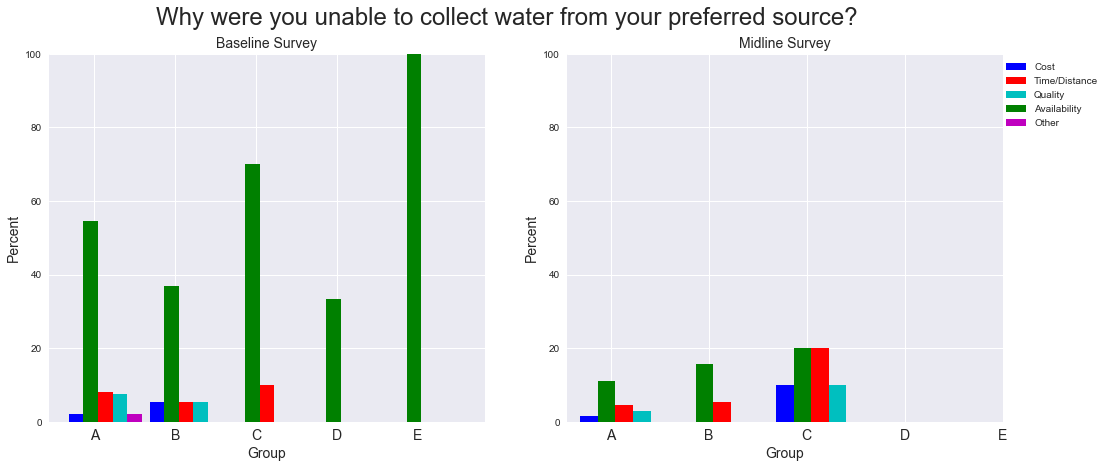

In [95]:
show_diff_props_surveys_clusters({'Baseline Survey': df_cluster2_rem, 'Midline Survey': df_merged_chanhomba},
                                 {'Baseline Survey': ['AvailReason/Cost', 'AvailReason/Availability', 'AvailReason/Time_Distance',
                                                      'AvailReason/Quality', 'AvailReason/Other'], 
                                  'Midline Survey': ['AvailReason/Cost', 'AvailReason/Availability',
                                                     'AvailReason/Time_Distance', 'AvailReason/Quality']},
                                 'Why were you unable to collect water from your preferred source?',
                                 {'AvailReason/Cost': 'Cost', 'AvailReason/Availability': 'Availability', 
                                   'AvailReason/Time_Distance': 'Time/Distance', 'AvailReason/Quality': 'Quality',
                                   'AvailReason/Other': 'Other'},
                                 (1.24, 1.0), width=0.18)

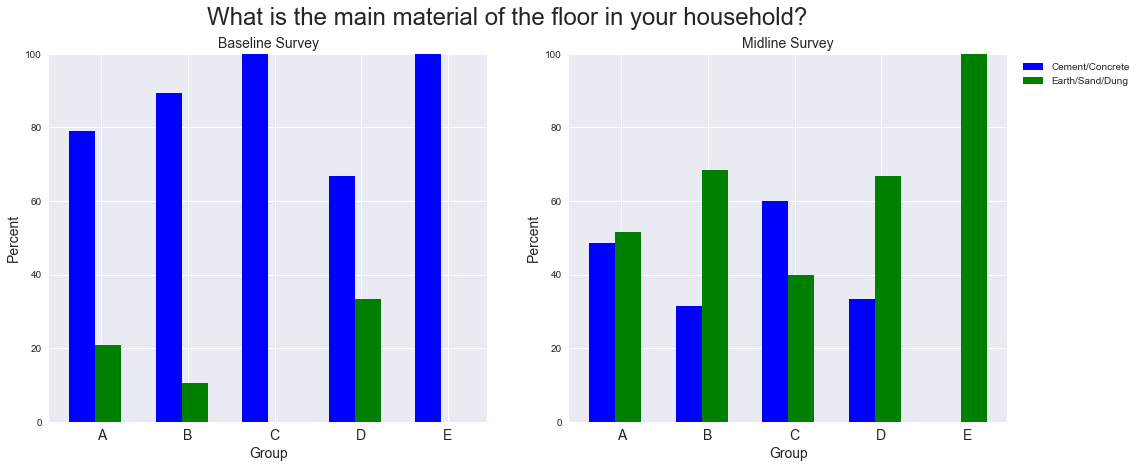

In [96]:
show_diff_for_surveys_clusters({'Baseline Survey': df_cluster2_rem, 'Midline Survey': df_merged_chanhomba}, 'FloorMaterial',
                               'What is the main material of the floor in your household?',
                               {0 : 'Cement/Concrete', 1: 'Earth/Sand/Dung', 3: 'Other'}, (1.3, 1.0), width=0.3)

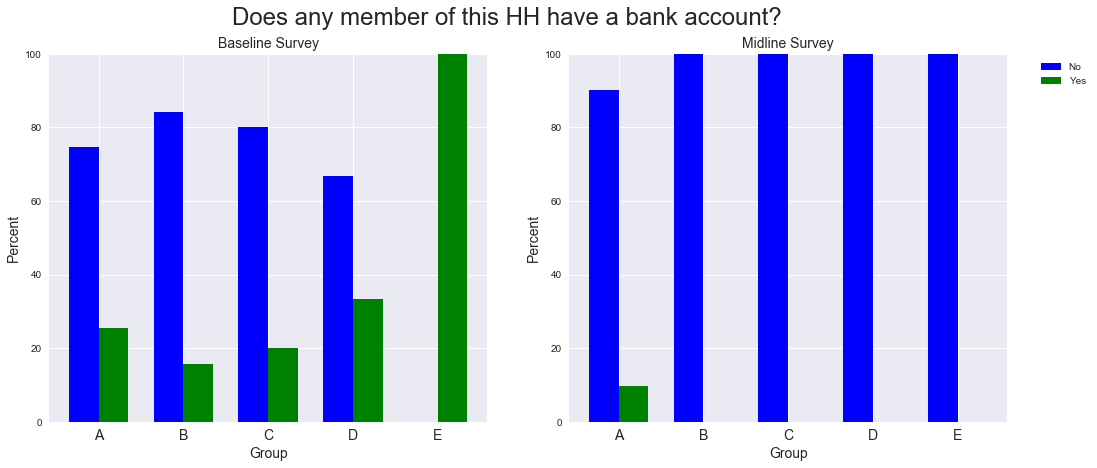

In [97]:
show_diff_for_surveys_clusters({'Baseline Survey': df_cluster2_rem, 'Midline Survey': df_merged_chanhomba}, 'BankAccount',
                               'Does any member of this HH have a bank account?', {0 : 'No', 1: 'Yes'}, (1.2, 1.0))

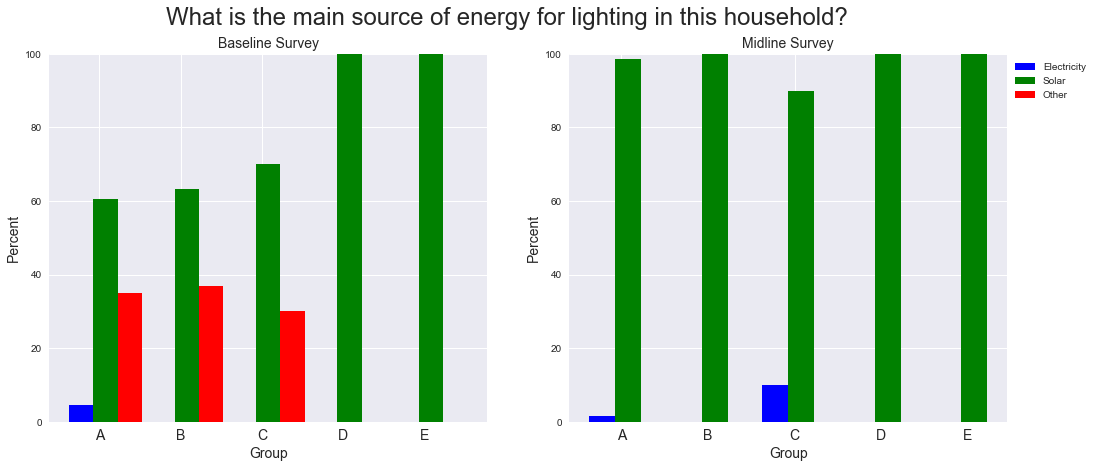

In [98]:
show_diff_for_surveys_clusters({'Baseline Survey': df_cluster2_rem, 'Midline Survey': df_merged_chanhomba}, 'SourceOfLighting',
                               'What is the main source of energy for lighting in this household?',
                               {1 : 'Electricity', 2: 'Solar', 3: 'Other'}, (1.2, 1.0), width=0.3)

<a id='comparing_chanhomba_comm'></a>
### Difference on the community level

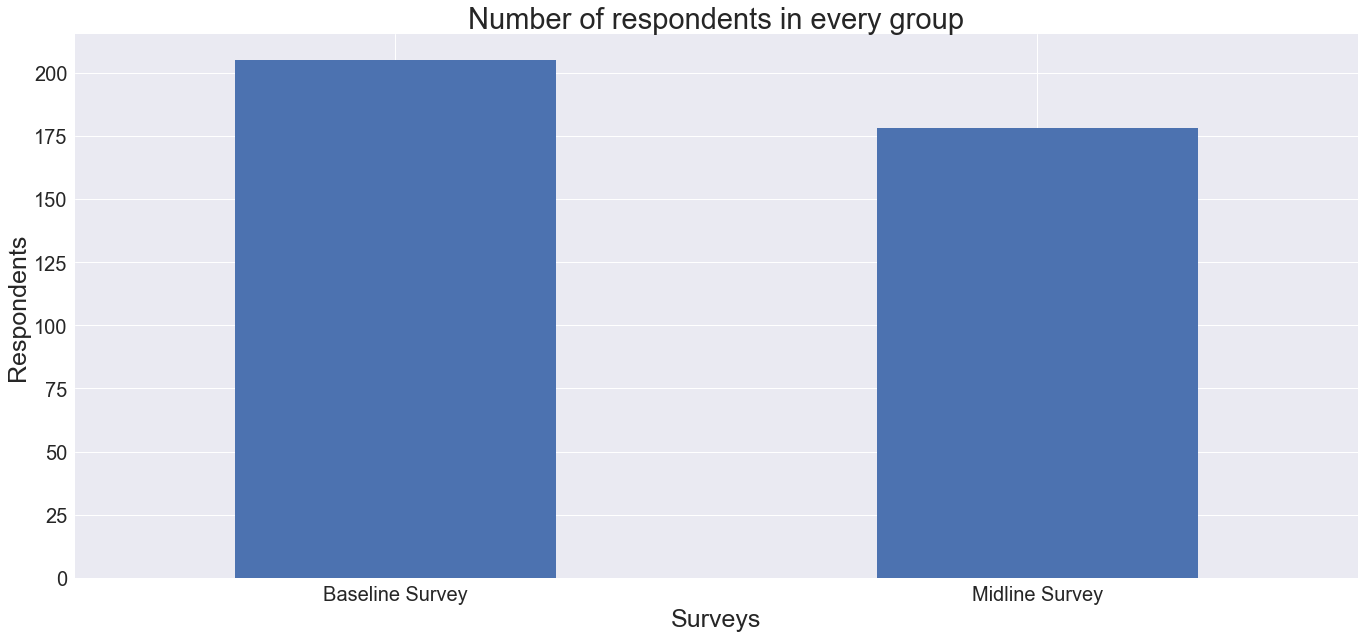

In [99]:
show_diff_between_surveys(df_Chanhomba, 
                          df_Chanhomba_m, 
                          'Count', 
                          np.sum, 
                          ['Baseline Survey', 'Midline Survey'],
                          'Number of respondents in every group',
                          'Respondents', (1.2, 1.0))

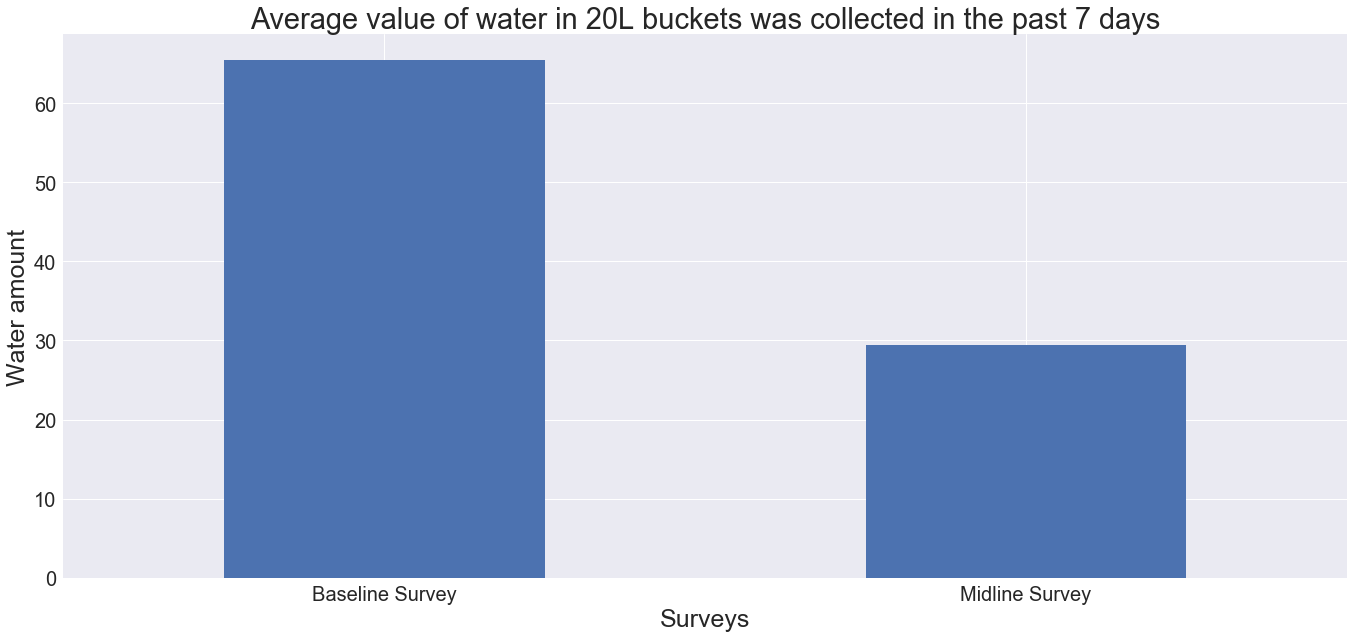

In [100]:
show_diff_between_surveys(df_Chanhomba, 
                          df_Chanhomba_m, 
                          'AmountOfWater', 
                          np.mean, 
                          ['Baseline Survey', 'Midline Survey'],
                          'Average value of water in 20L buckets was collected in the past 7 days',
                          'Water amount', (1.2, 1.0))

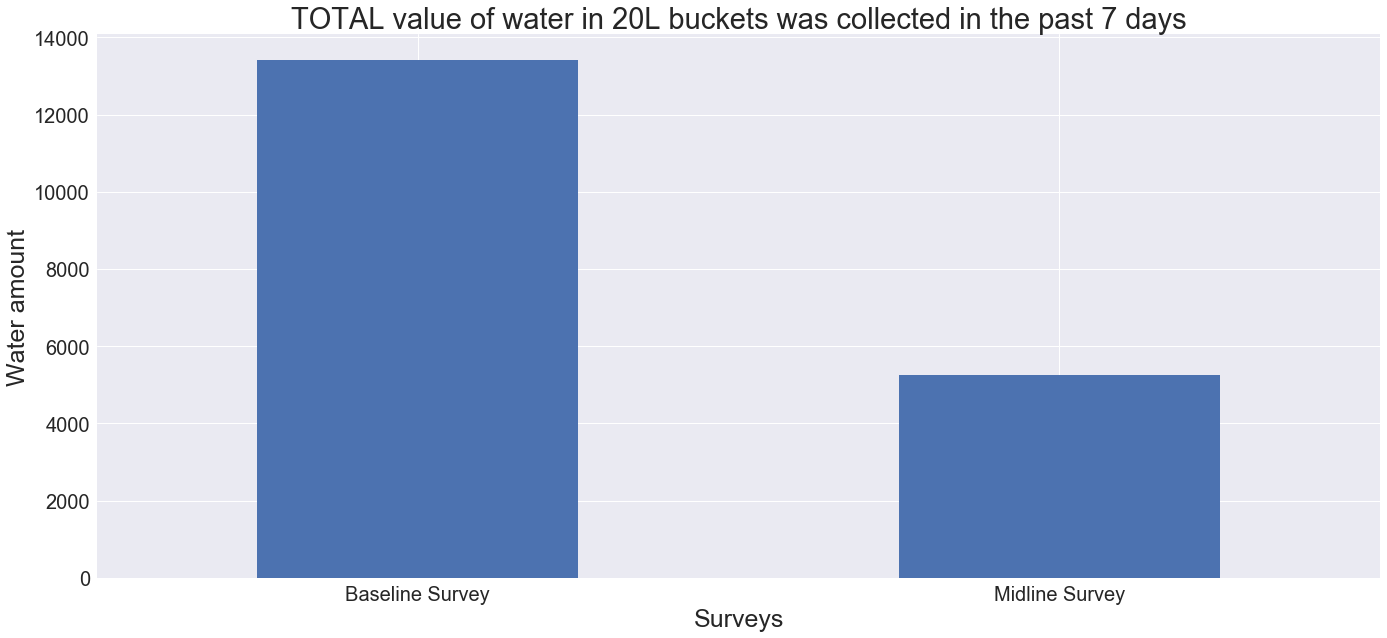

In [101]:
show_diff_between_surveys(df_Chanhomba, 
                          df_Chanhomba_m, 
                          'AmountOfWater', 
                          np.sum, 
                          ['Baseline Survey', 'Midline Survey'],
                          'TOTAL value of water in 20L buckets was collected in the past 7 days',
                          'Water amount', (1.2, 1.0))

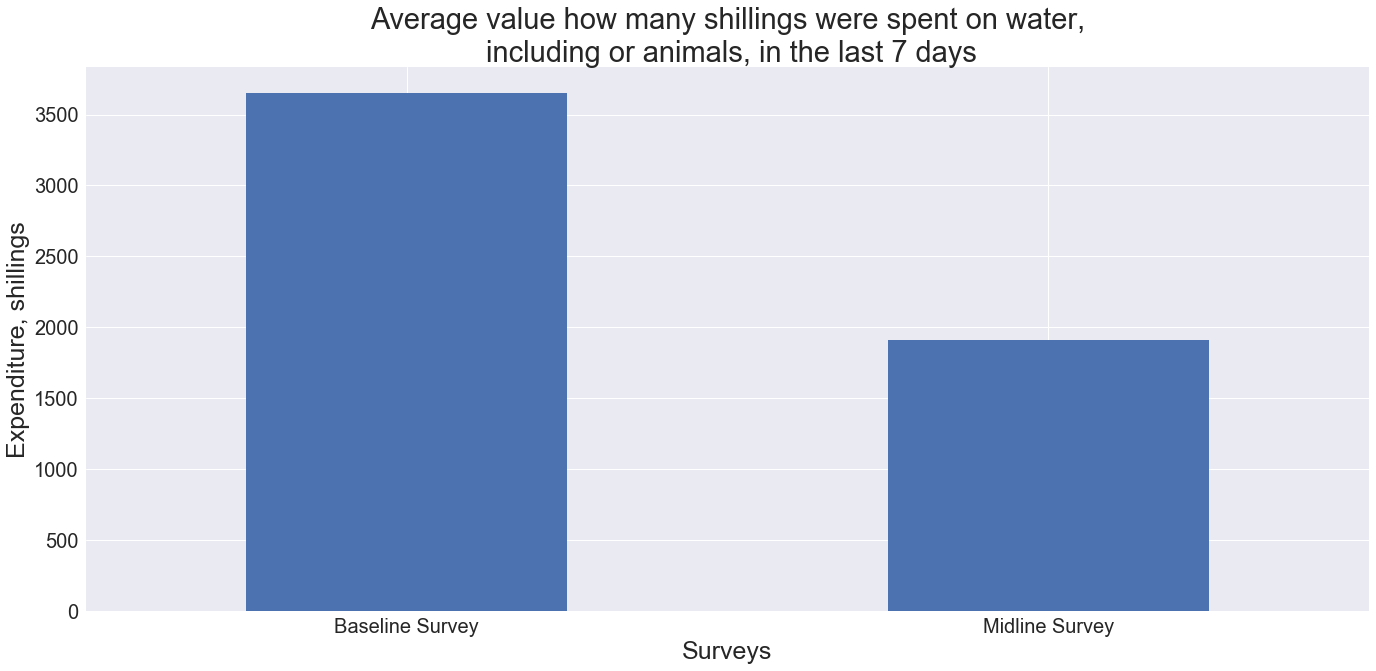

In [102]:
show_diff_between_surveys(df_Chanhomba, 
                          df_Chanhomba_m, 
                          'WaterExpenditure', 
                          np.mean, 
                          ['Baseline Survey', 'Midline Survey'],
                          'Average value how many shillings were spent on water,\n including or animals, in the last 7 days',
                          'Expenditure, shillings', (1.2, 1.0))

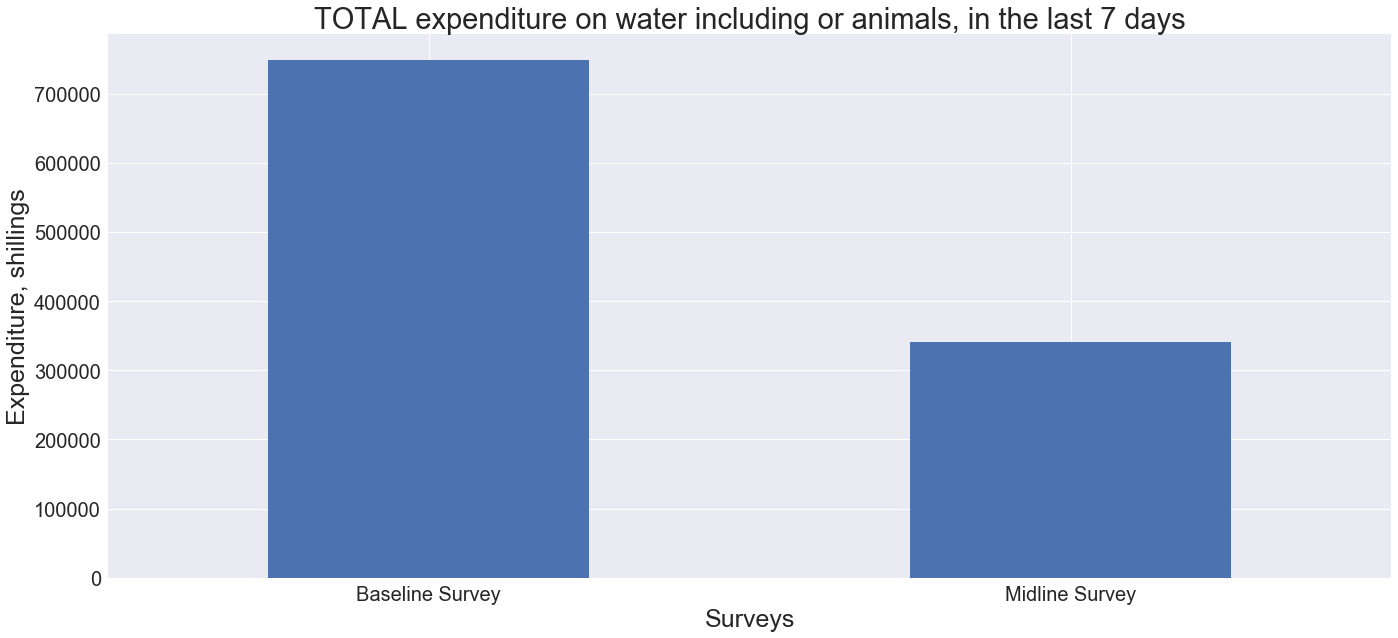

In [103]:
show_diff_between_surveys(df_Chanhomba, 
                          df_Chanhomba_m, 
                          'WaterExpenditure', 
                          np.sum, 
                          ['Baseline Survey', 'Midline Survey'],
                          'TOTAL expenditure on water including or animals, in the last 7 days',
                          'Expenditure, shillings', (1.2, 1.0))

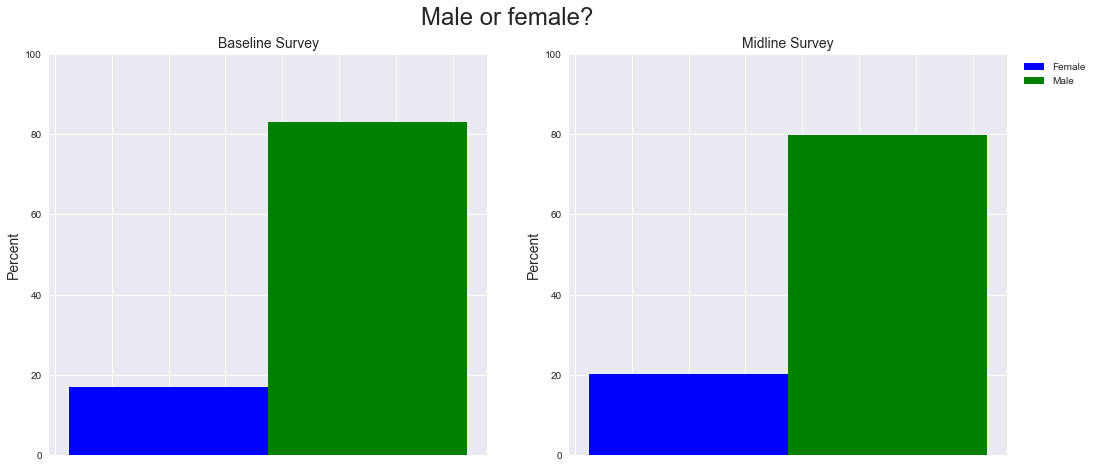

In [104]:
show_diff_for_surveys({'Baseline Survey': df_Chanhomba, 'Midline Survey': df_Chanhomba_m}, 'Gender',
                      'Male or female?', {0 : 'Female', 1: 'Male'}, (1.2, 1.0))

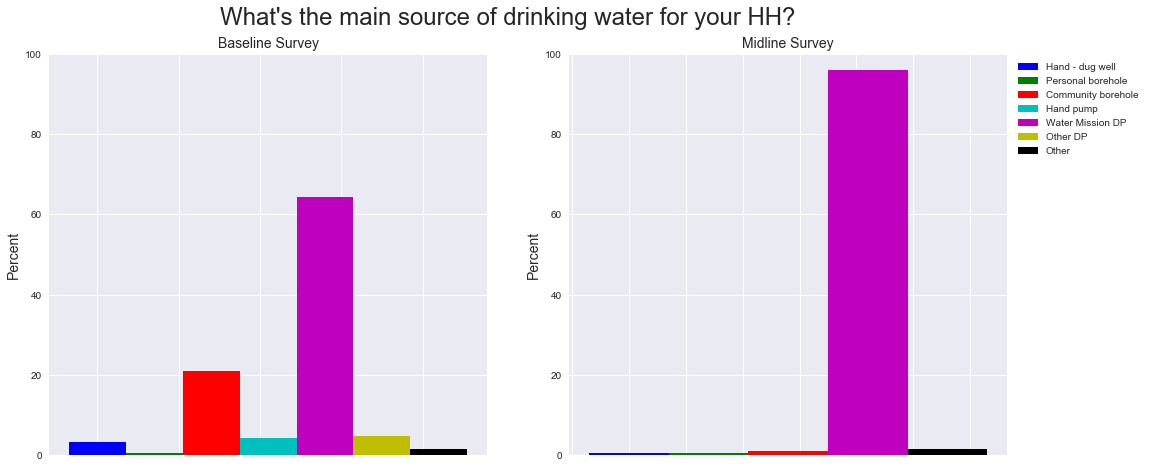

In [105]:
dict_sow ={ 1: 'Hand - dug well', 2: 'Personal borehole', 3:'Community borehole', 4:'Hand pump', 5:'Water Mission DP', 
           6: 'Other DP', 7:'Natural surface water', 8: 'Other' }
show_diff_for_surveys({'Baseline Survey': df_Chanhomba, 'Midline Survey': df_Chanhomba_m}, 'PrimarySource',
                      "What's the main source of drinking water for your HH?", dict_sow , (1.32, 1.0), width=0.14)

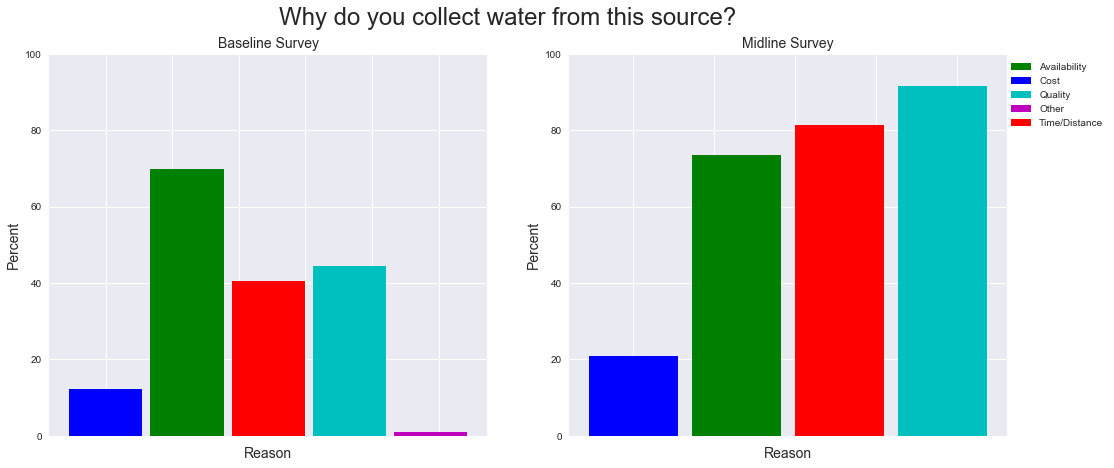

In [106]:
show_diff_props_surveys({'Baseline Survey': df_Chanhomba, 'Midline Survey': df_Chanhomba_m},
                                 {'Baseline Survey': ['Reason/Cost', 'Reason/Availability', 'Reason/Time_Distance',
                                                      'Reason/Quality', 'Reason/Other'], 
                                  'Midline Survey': ['Reason/Cost', 'Reason/Availability', 'Reason/Time_Distance',
                                                     'Reason/Quality']},
                                 'Why do you collect water from this source?',
                                 {'Reason/Cost': 'Cost', 'Reason/Availability': 'Availability', 
                                   'Reason/Time_Distance': 'Time/Distance', 'Reason/Quality': 'Quality',
                                   'Reason/Other': 'Other'},
                                 (1.24, 1.0), width=1.1, xlabel='Reason' )

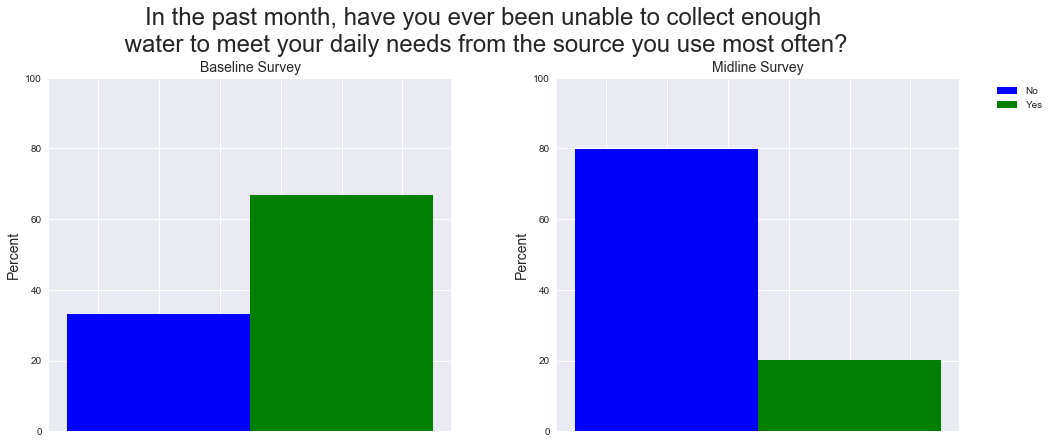

In [107]:
show_diff_for_surveys({'Baseline Survey': df_Chanhomba, 'Midline Survey': df_Chanhomba_m}, 'WaterAvailability',
                      'In the past month, have you ever been unable to collect enough\n water to meet your daily needs from the source you use most often?',
                      {0 : 'No', 1: 'Yes', 88: "Don't Know" }, (1.23, 1.0) , width=0.3, pad=4)

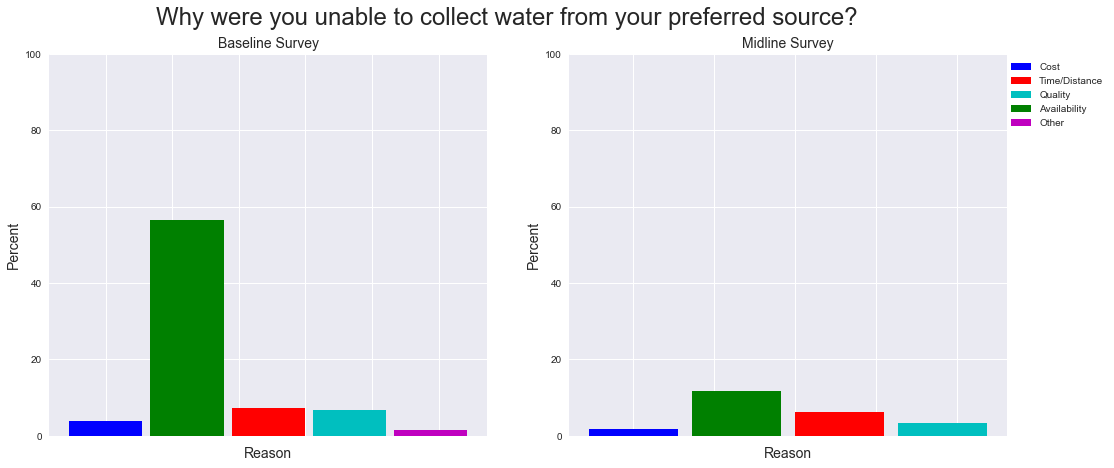

In [108]:
show_diff_props_surveys({'Baseline Survey': df_Chanhomba, 'Midline Survey': df_Chanhomba_m},
                                 {'Baseline Survey': ['AvailReason/Cost', 'AvailReason/Availability', 'AvailReason/Time_Distance',
                                                      'AvailReason/Quality', 'AvailReason/Other'], 
                                  'Midline Survey': ['AvailReason/Cost', 'AvailReason/Availability',
                                                     'AvailReason/Time_Distance', 'AvailReason/Quality']},
                                 'Why were you unable to collect water from your preferred source?',
                                 {'AvailReason/Cost': 'Cost', 'AvailReason/Availability': 'Availability', 
                                   'AvailReason/Time_Distance': 'Time/Distance', 'AvailReason/Quality': 'Quality',
                                   'AvailReason/Other': 'Other'},
                                 (1.24, 1.0), width=1.1, xlabel='Reason')

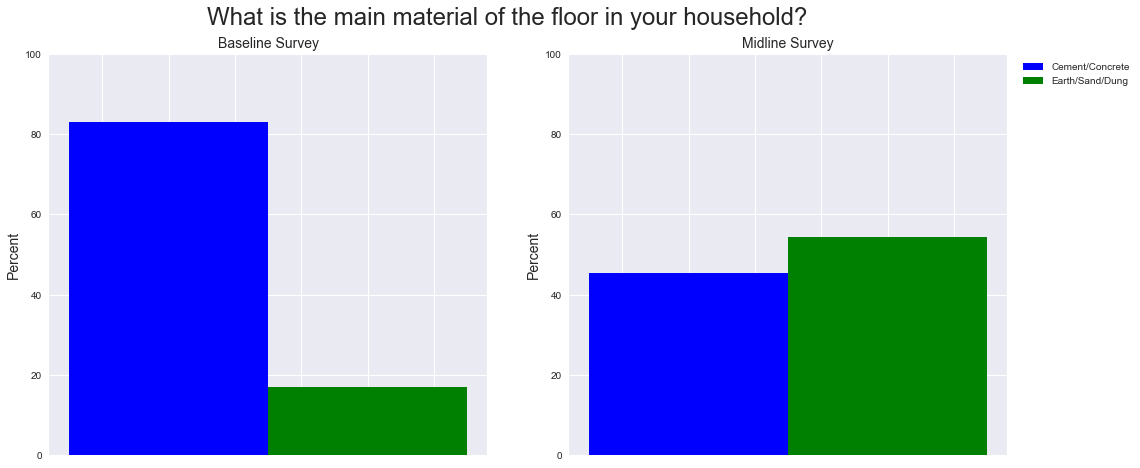

In [109]:
show_diff_for_surveys({'Baseline Survey': df_Chanhomba, 'Midline Survey': df_Chanhomba_m}, 'FloorMaterial',
                      'What is the main material of the floor in your household?',
                      {0 : 'Cement/Concrete', 1: 'Earth/Sand/Dung', 3: 'Other'}, (1.3, 1.0), width=0.3)

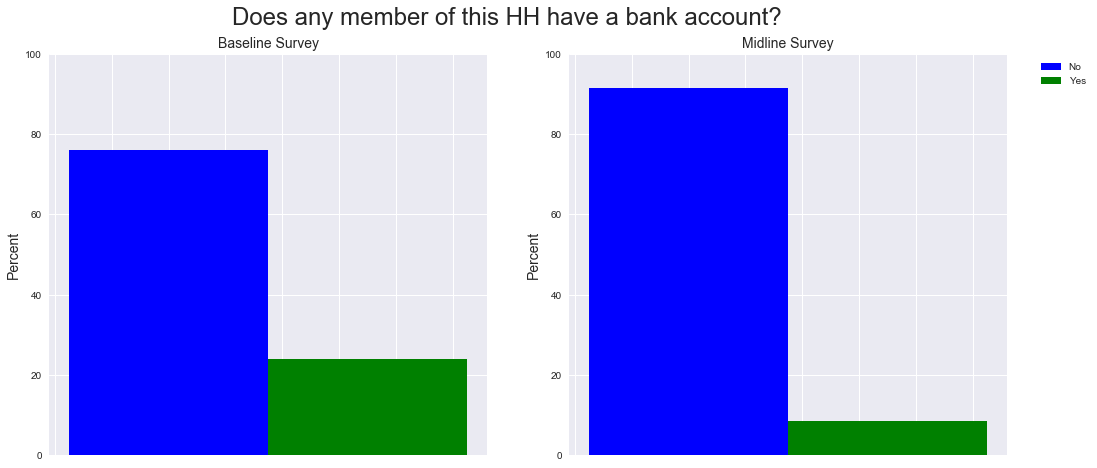

In [110]:
show_diff_for_surveys({'Baseline Survey': df_Chanhomba, 'Midline Survey': df_Chanhomba_m}, 'BankAccount',
                      'Does any member of this HH have a bank account?', {0 : 'No', 1: 'Yes'}, (1.2, 1.0))

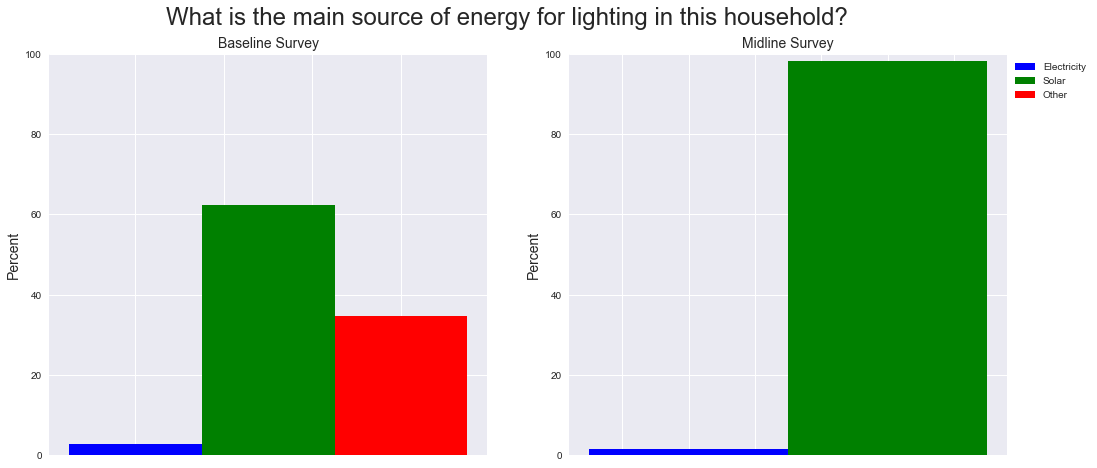

In [111]:
show_diff_for_surveys({'Baseline Survey': df_Chanhomba, 'Midline Survey': df_Chanhomba_m}, 'SourceOfLighting',
                      'What is the main source of energy for lighting in this household?',
                      {1 : 'Electricity', 2: 'Solar', 3: 'Other'}, (1.2, 1.0), width=0.3)

<a id='comparing_gidewari'></a>
## Baseline/Midline surveys comparison in Gidewari

<a id='comparing_gidewari_groups'></a>
### Difference on the clusters/groups level

Show chart of number of respondents in every group

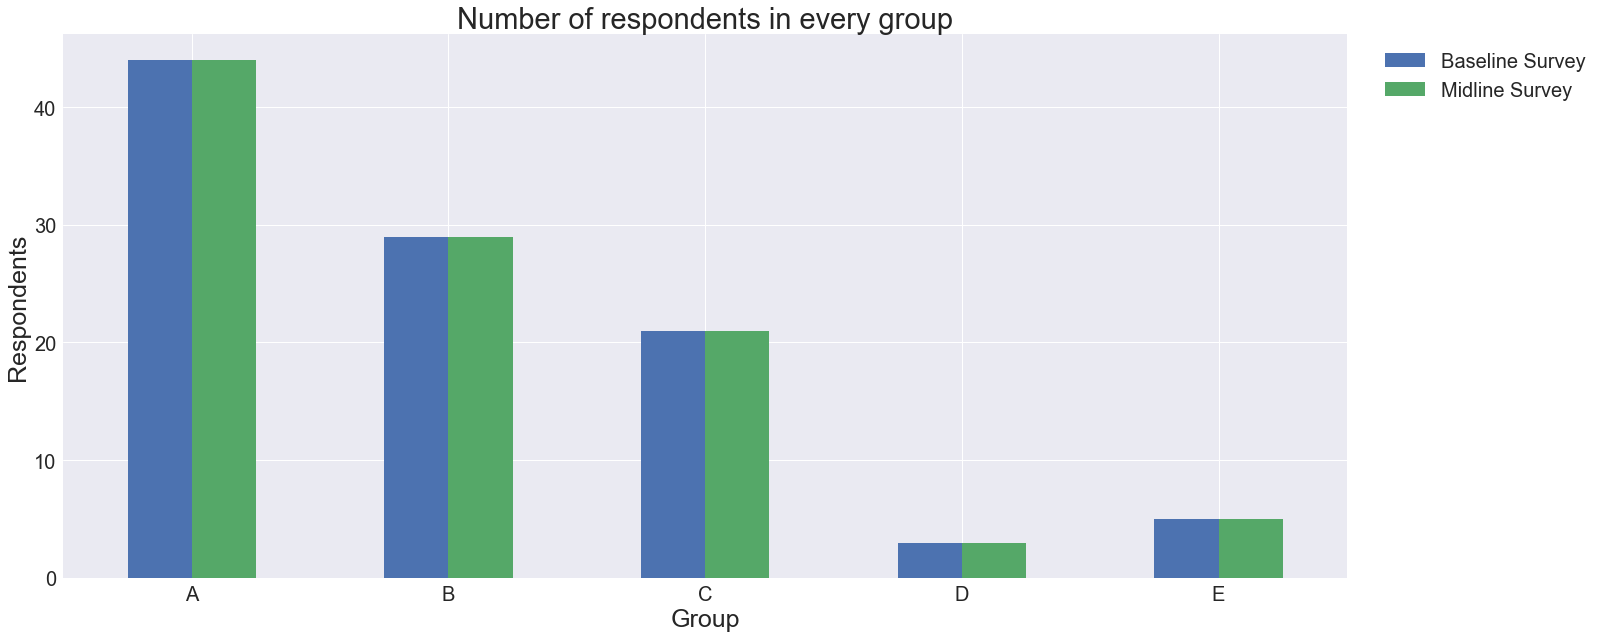

In [112]:
show_diff_between_surveys_clusters(df_cluster3_rem, 
                                   df_merged_gidewari, 
                                   'Count', 
                                   'sum', 
                                   ['Baseline Survey', 'Midline Survey'],
                                   'Number of respondents in every group',
                                   'Respondents', (1.2, 1.0))

Show chart of average water consumption for each cluster/group in Gidewari

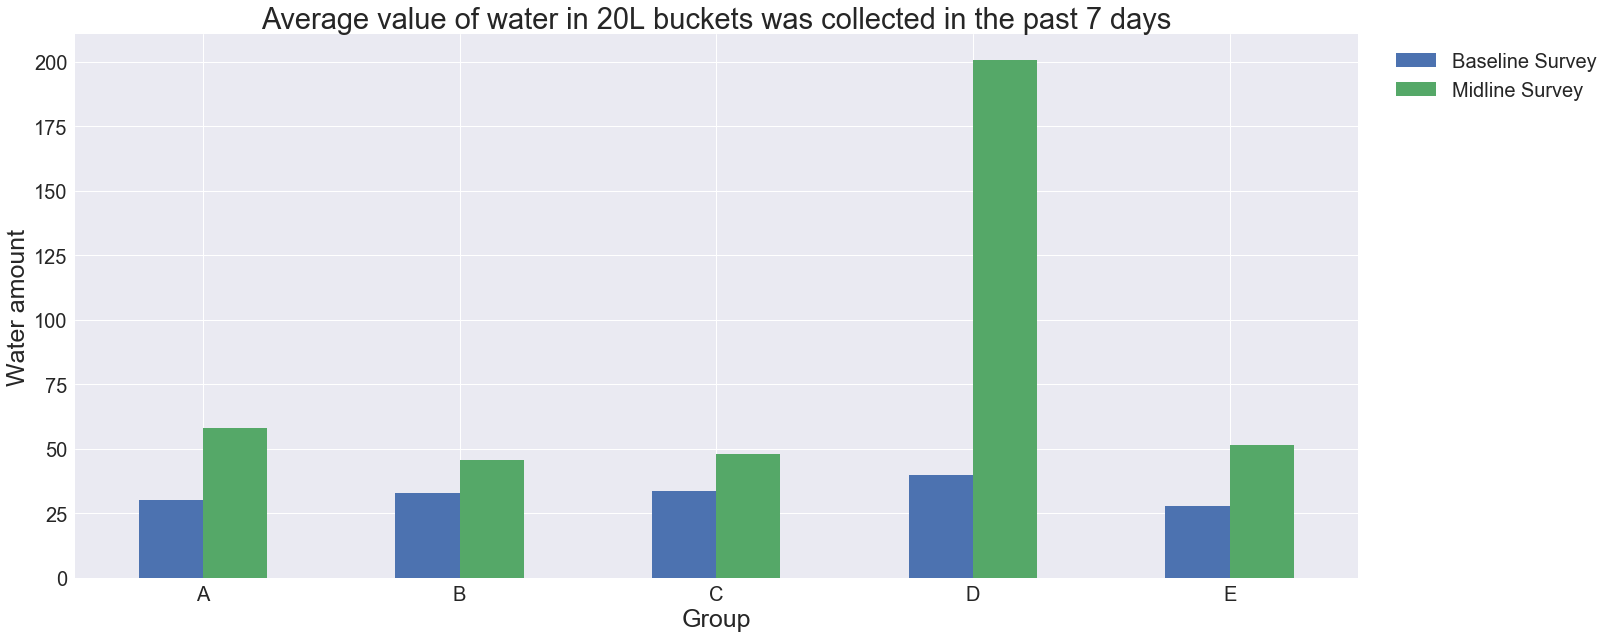

In [113]:
show_diff_between_surveys_clusters(df_cluster3_rem, 
                                   df_merged_gidewari, 
                                   'AmountOfWater', 
                                   'mean', 
                                   ['Baseline Survey', 'Midline Survey'],
                                   'Average value of water in 20L buckets was collected in the past 7 days',
                                   'Water amount', (1.2, 1.0))

Show chart of common water consumption for each cluster/group in Gidewari

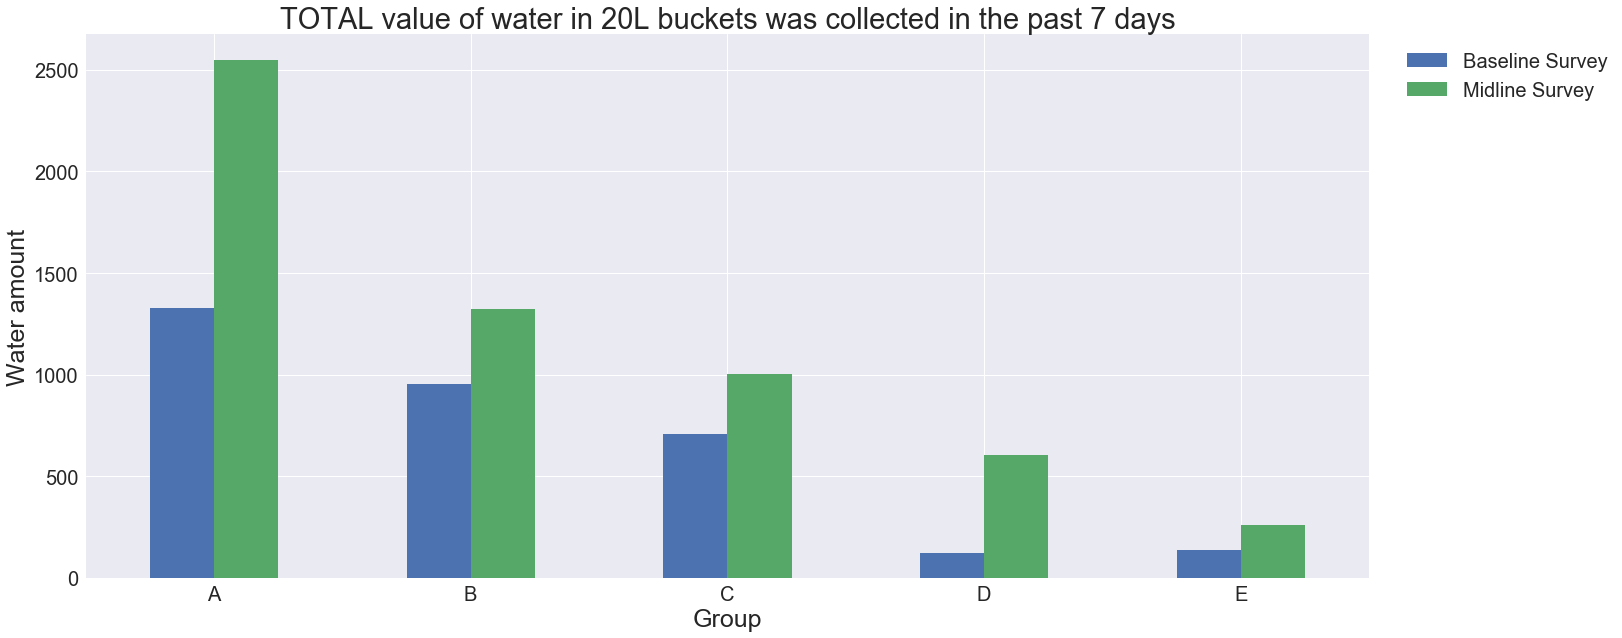

In [114]:
show_diff_between_surveys_clusters(df_cluster3_rem, 
                                   df_merged_gidewari, 
                                   'AmountOfWater', 
                                   'sum', 
                                   ['Baseline Survey', 'Midline Survey'],
                                   'TOTAL value of water in 20L buckets was collected in the past 7 days',
                                   'Water amount', (1.2, 1.0))

Show chart of average value how much money were spent on water for each cluster/group in Gidewari

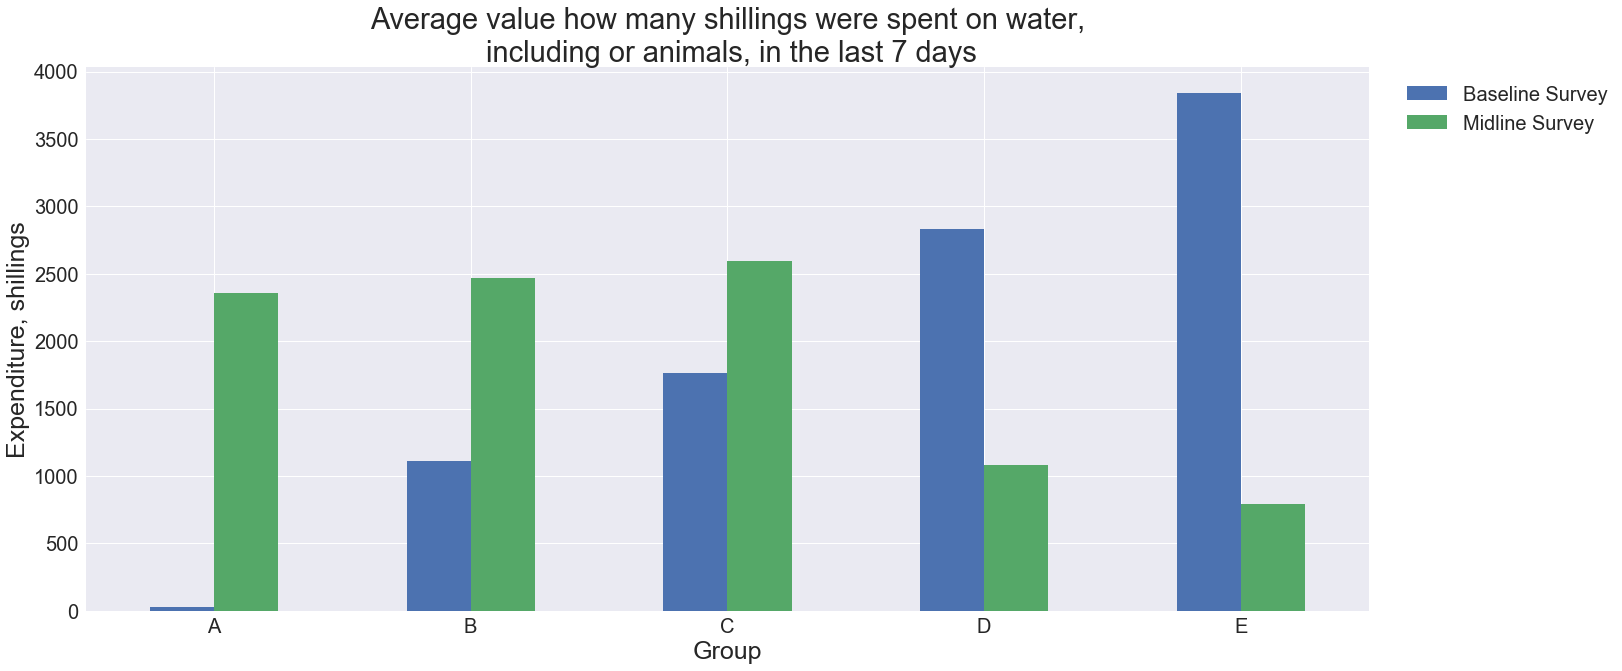

In [115]:
show_diff_between_surveys_clusters(df_cluster3_rem, 
                                   df_merged_gidewari, 
                                   'WaterExpenditure', 
                                   'mean', 
                                   ['Baseline Survey', 'Midline Survey'],
                                   'Average value how many shillings were spent on water,\n including or animals, in the last 7 days',
                                   'Expenditure, shillings', (1.2, 1.0))

Show chart of common value how much money were spent on water for each cluster/group in Gidewari

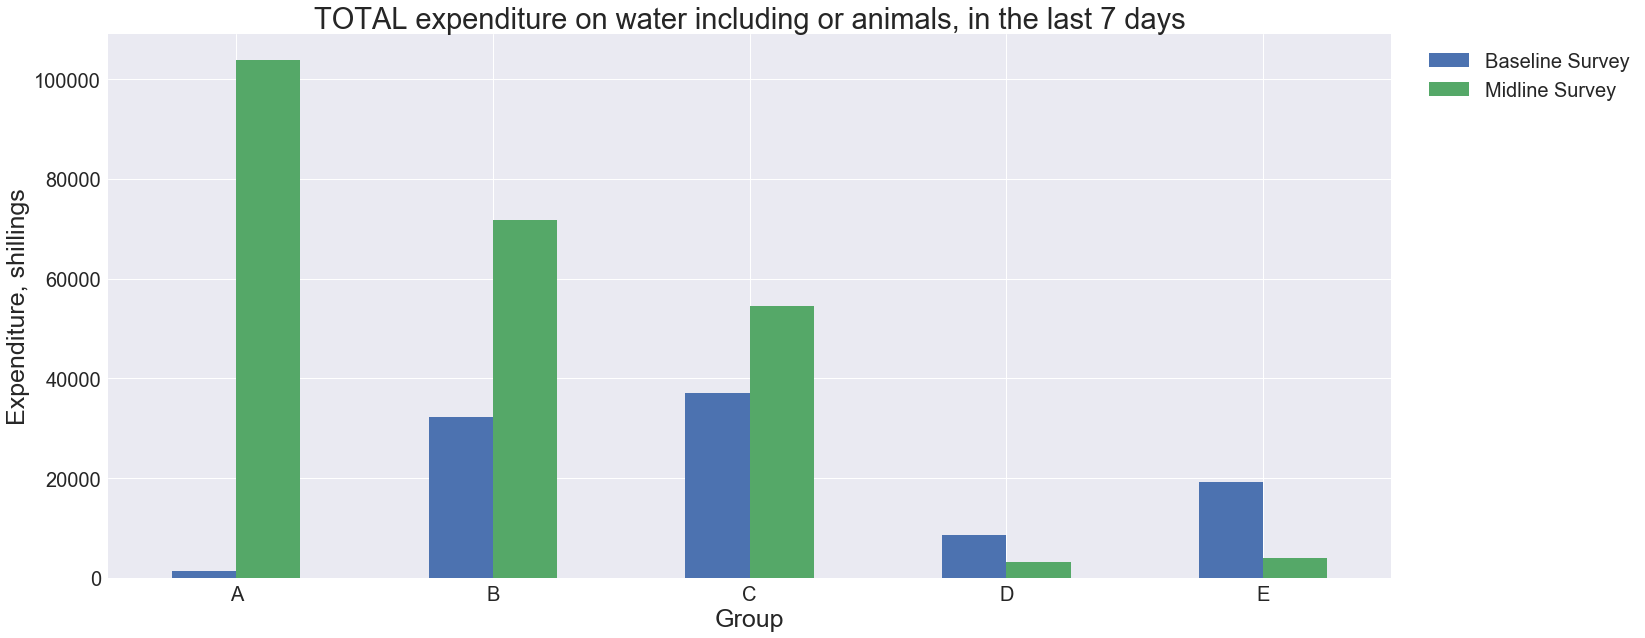

In [116]:
show_diff_between_surveys_clusters(df_cluster3_rem, 
                                   df_merged_gidewari, 
                                   'WaterExpenditure', 
                                   'sum', 
                                   ['Baseline Survey', 'Midline Survey'],
                                   'TOTAL expenditure on water including or animals, in the last 7 days',
                                   'Expenditure, shillings', (1.2, 1.0))

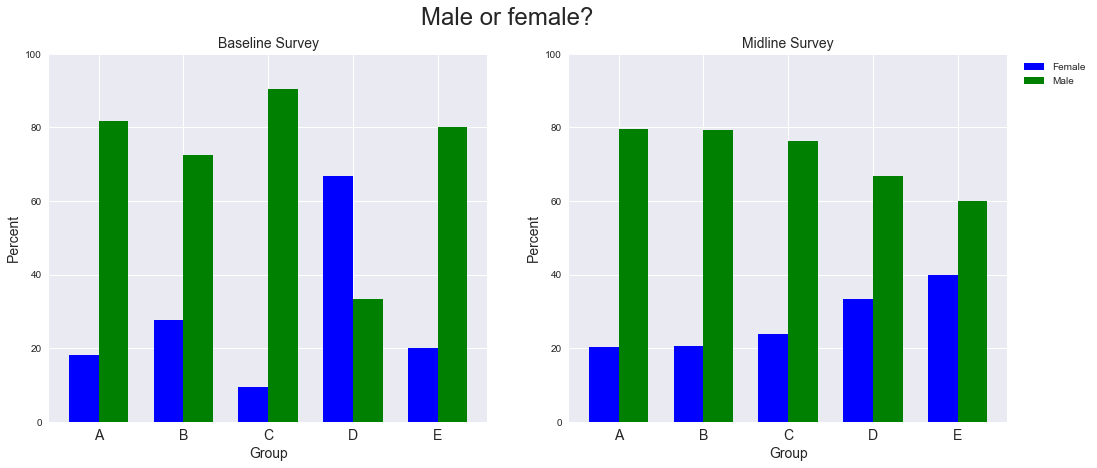

In [117]:
show_diff_for_surveys_clusters({'Baseline Survey': df_cluster3_rem, 'Midline Survey': df_merged_gidewari}, 'Gender',
                               'Male or female?', {0 : 'Female', 1: 'Male'}, (1.2, 1.0))

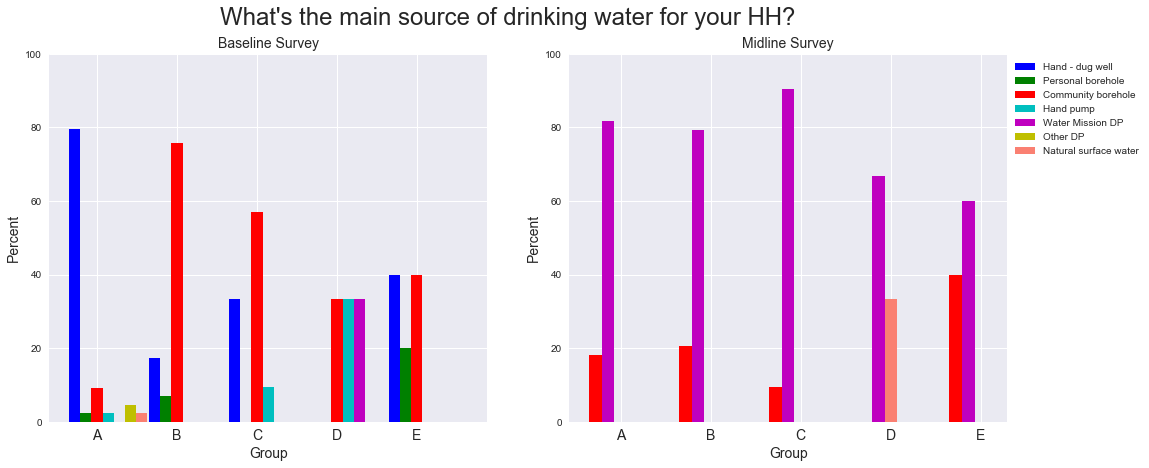

In [118]:
dict_sow ={ 1: 'Hand - dug well', 2: 'Personal borehole', 3:'Community borehole', 4:'Hand pump', 5:'Water Mission DP', 
           6: 'Other DP', 7:'Natural surface water', 8: 'Other' }
show_diff_for_surveys_clusters({'Baseline Survey': df_cluster3_rem, 'Midline Survey': df_merged_gidewari}, 'PrimarySource',
                               "What's the main source of drinking water for your HH?", dict_sow , (1.32, 1.0), width=0.14)

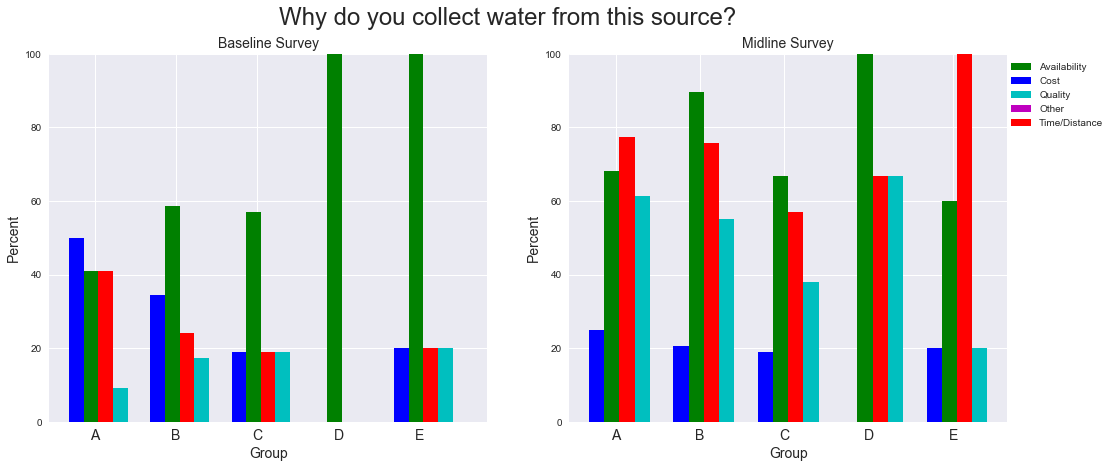

In [119]:
show_diff_props_surveys_clusters({'Baseline Survey': df_cluster3_rem, 'Midline Survey': df_merged_gidewari},
                                 {'Baseline Survey': ['Reason/Cost', 'Reason/Availability', 'Reason/Time_Distance',
                                                      'Reason/Quality', 'Reason/Other'], 
                                  'Midline Survey': ['Reason/Cost', 'Reason/Availability', 'Reason/Time_Distance',
                                                     'Reason/Quality']},
                                 'Why do you collect water from this source?',
                                 {'Reason/Cost': 'Cost', 'Reason/Availability': 'Availability', 
                                   'Reason/Time_Distance': 'Time/Distance', 'Reason/Quality': 'Quality',
                                   'Reason/Other': 'Other'},
                                 (1.24, 1.0), width=0.18)

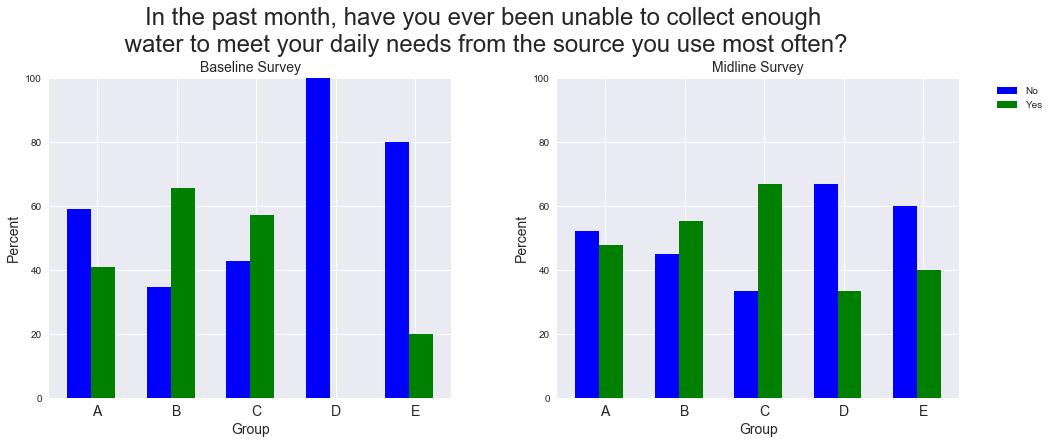

In [120]:
show_diff_for_surveys_clusters({'Baseline Survey': df_cluster3_rem, 'Midline Survey': df_merged_gidewari}, 'WaterAvailability',
                               'In the past month, have you ever been unable to collect enough\n water to meet your daily needs from the source you use most often?',
                               {0 : 'No', 1: 'Yes', 88: "Don't Know" }, (1.23, 1.0) , width=0.3, pad=4)

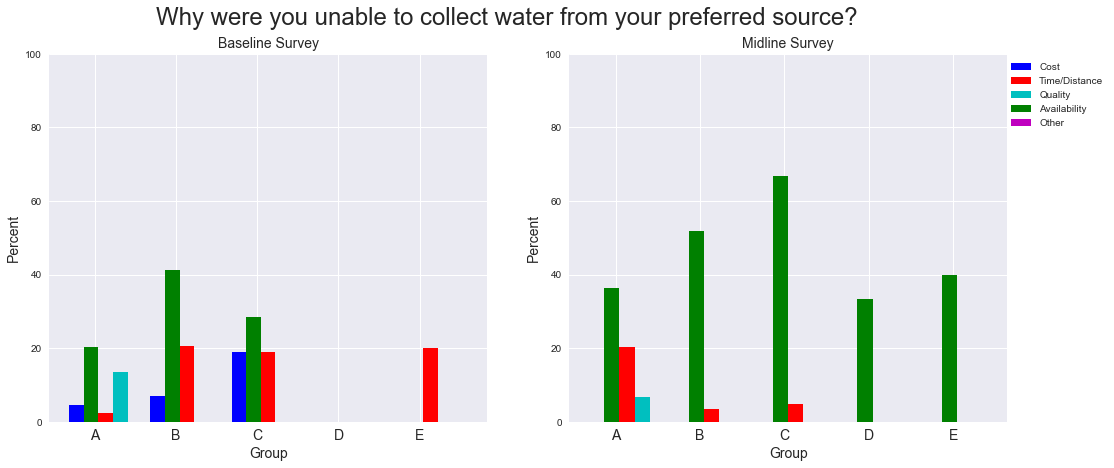

In [121]:
show_diff_props_surveys_clusters({'Baseline Survey': df_cluster3_rem, 'Midline Survey': df_merged_gidewari},
                                 {'Baseline Survey': ['AvailReason/Cost', 'AvailReason/Availability', 'AvailReason/Time_Distance',
                                                      'AvailReason/Quality', 'AvailReason/Other'], 
                                  'Midline Survey': ['AvailReason/Cost', 'AvailReason/Availability',
                                                     'AvailReason/Time_Distance', 'AvailReason/Quality']},
                                 'Why were you unable to collect water from your preferred source?',
                                 {'AvailReason/Cost': 'Cost', 'AvailReason/Availability': 'Availability', 
                                   'AvailReason/Time_Distance': 'Time/Distance', 'AvailReason/Quality': 'Quality',
                                   'AvailReason/Other': 'Other'},
                                 (1.24, 1.0), width=0.18)

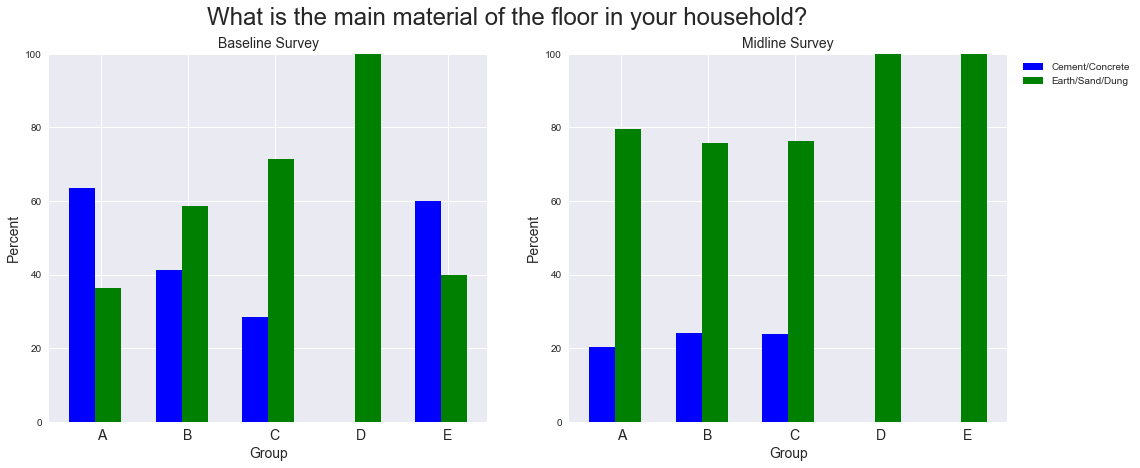

In [122]:
show_diff_for_surveys_clusters({'Baseline Survey': df_cluster3_rem, 'Midline Survey': df_merged_gidewari}, 'FloorMaterial',
                               'What is the main material of the floor in your household?',
                               {0 : 'Cement/Concrete', 1: 'Earth/Sand/Dung', 3: 'Other'}, (1.3, 1.0), width=0.3)

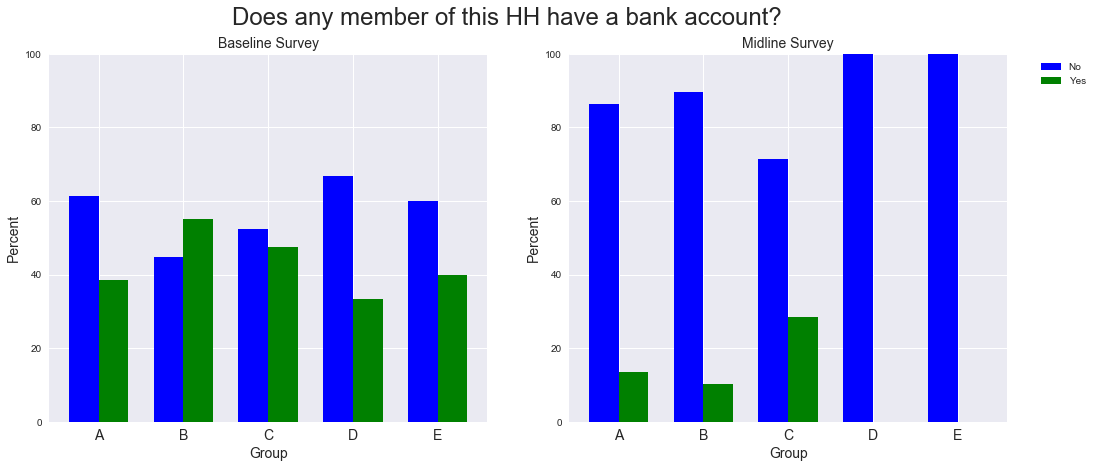

In [123]:
show_diff_for_surveys_clusters({'Baseline Survey': df_cluster3_rem, 'Midline Survey': df_merged_gidewari}, 'BankAccount',
                               'Does any member of this HH have a bank account?', {0 : 'No', 1: 'Yes'}, (1.2, 1.0))

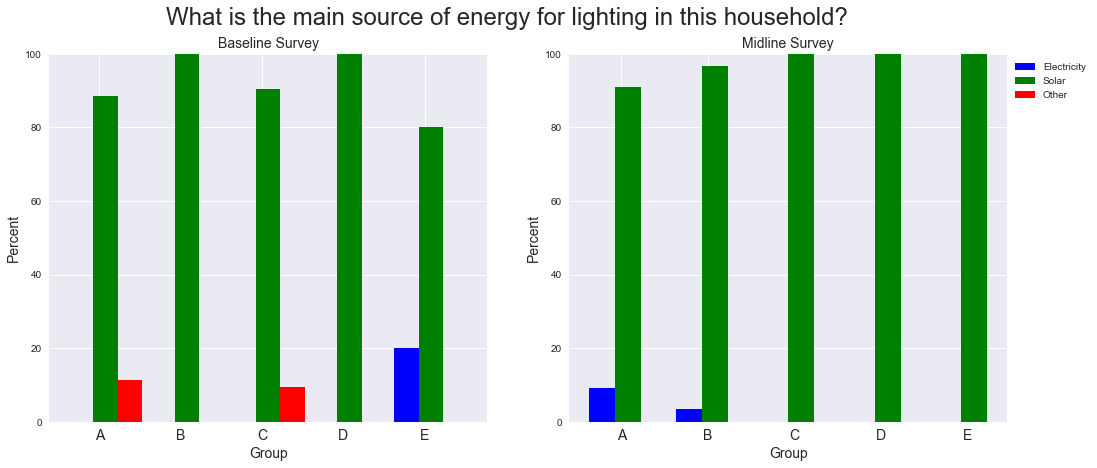

In [124]:
show_diff_for_surveys_clusters({'Baseline Survey': df_cluster3_rem, 'Midline Survey': df_merged_gidewari}, 'SourceOfLighting',
                               'What is the main source of energy for lighting in this household?',
                               {1 : 'Electricity', 2: 'Solar', 3: 'Other'}, (1.2, 1.0), width=0.3)

<a id='comparing_gidewari_comm'></a> 
### Difference on the community level

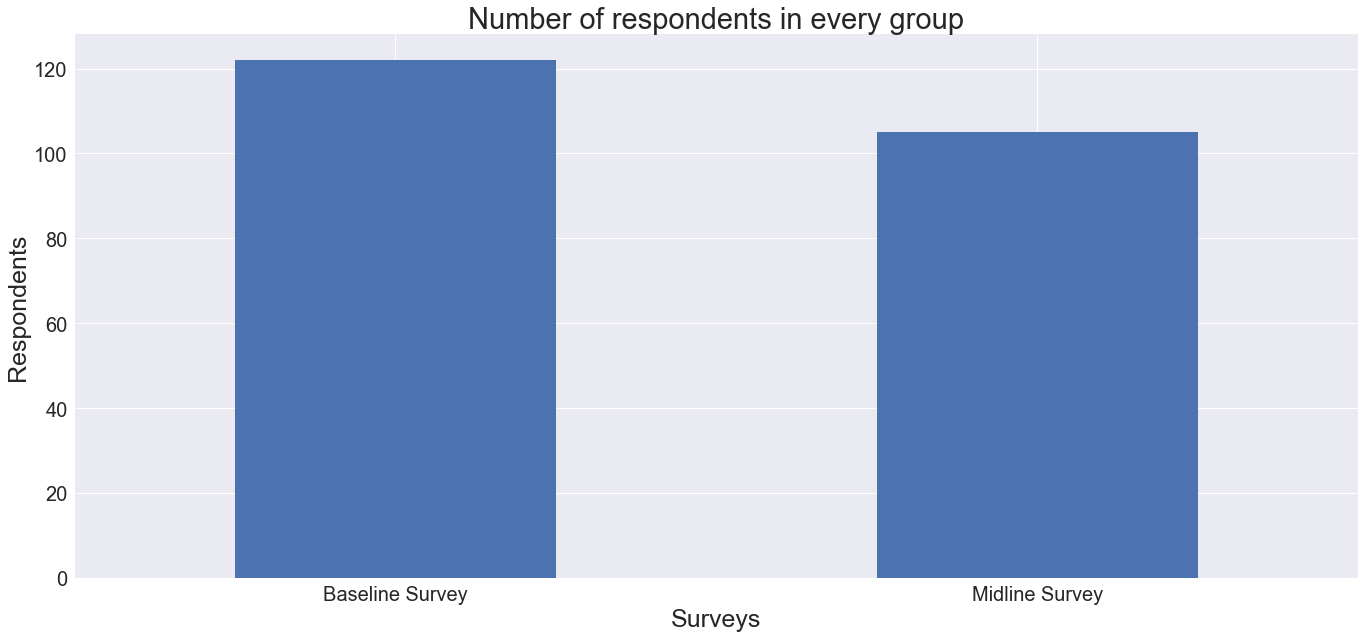

In [125]:
show_diff_between_surveys(df_Gidewari, 
                          df_Gidewari_m, 
                          'Count', 
                          np.sum, 
                          ['Baseline Survey', 'Midline Survey'],
                          'Number of respondents in every group',
                          'Respondents', (1.2, 1.0))

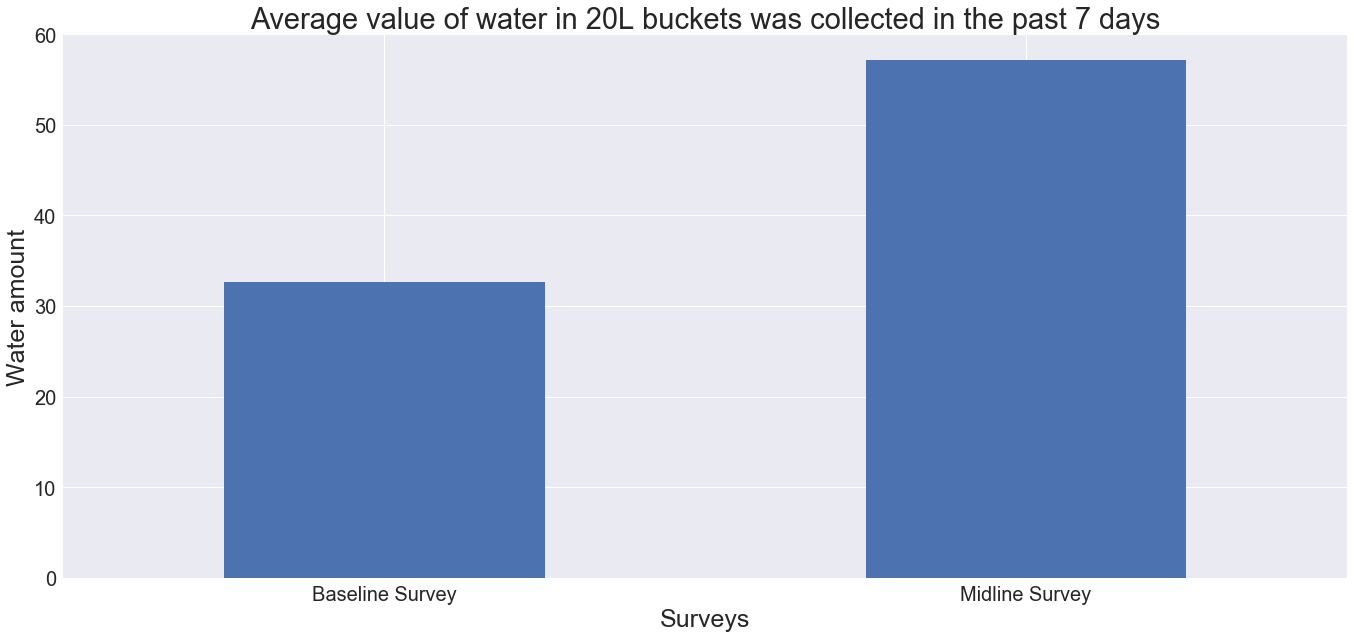

In [126]:
show_diff_between_surveys(df_Gidewari, 
                          df_Gidewari_m, 
                          'AmountOfWater', 
                          np.mean, 
                          ['Baseline Survey', 'Midline Survey'],
                          'Average value of water in 20L buckets was collected in the past 7 days',
                          'Water amount', (1.2, 1.0))

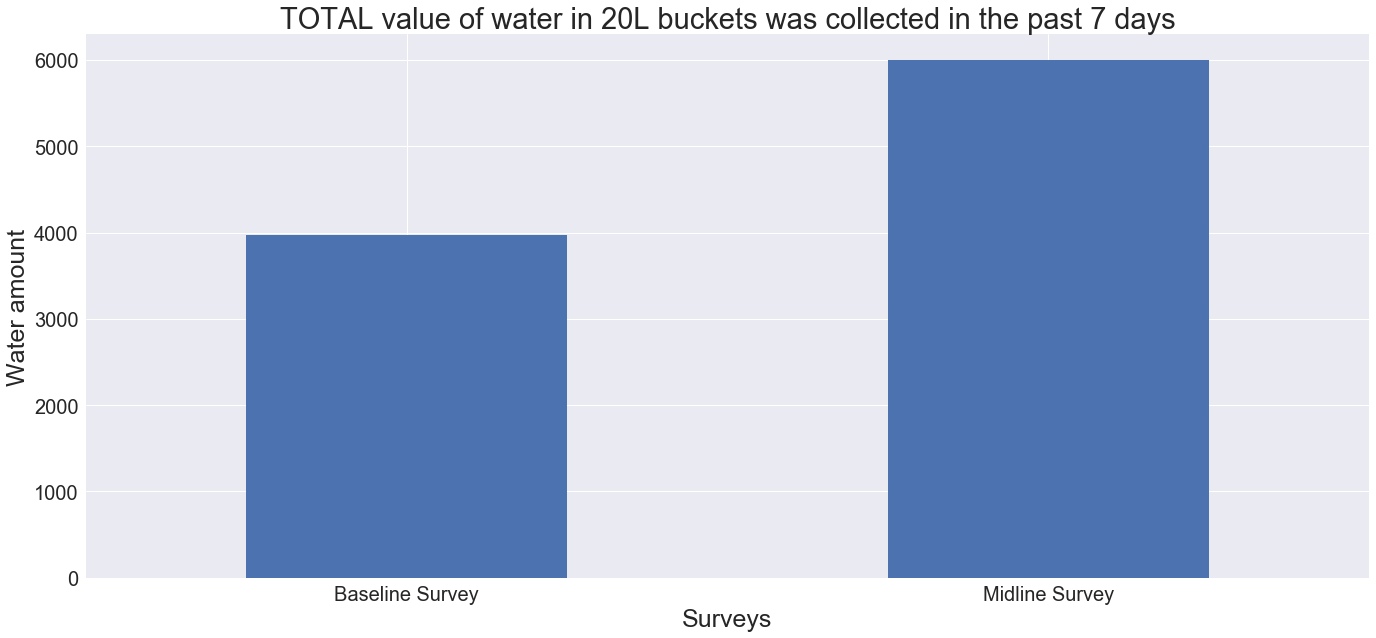

In [127]:
show_diff_between_surveys(df_Gidewari, 
                          df_Gidewari_m, 
                          'AmountOfWater', 
                          np.sum, 
                          ['Baseline Survey', 'Midline Survey'],
                          'TOTAL value of water in 20L buckets was collected in the past 7 days',
                          'Water amount', (1.2, 1.0))

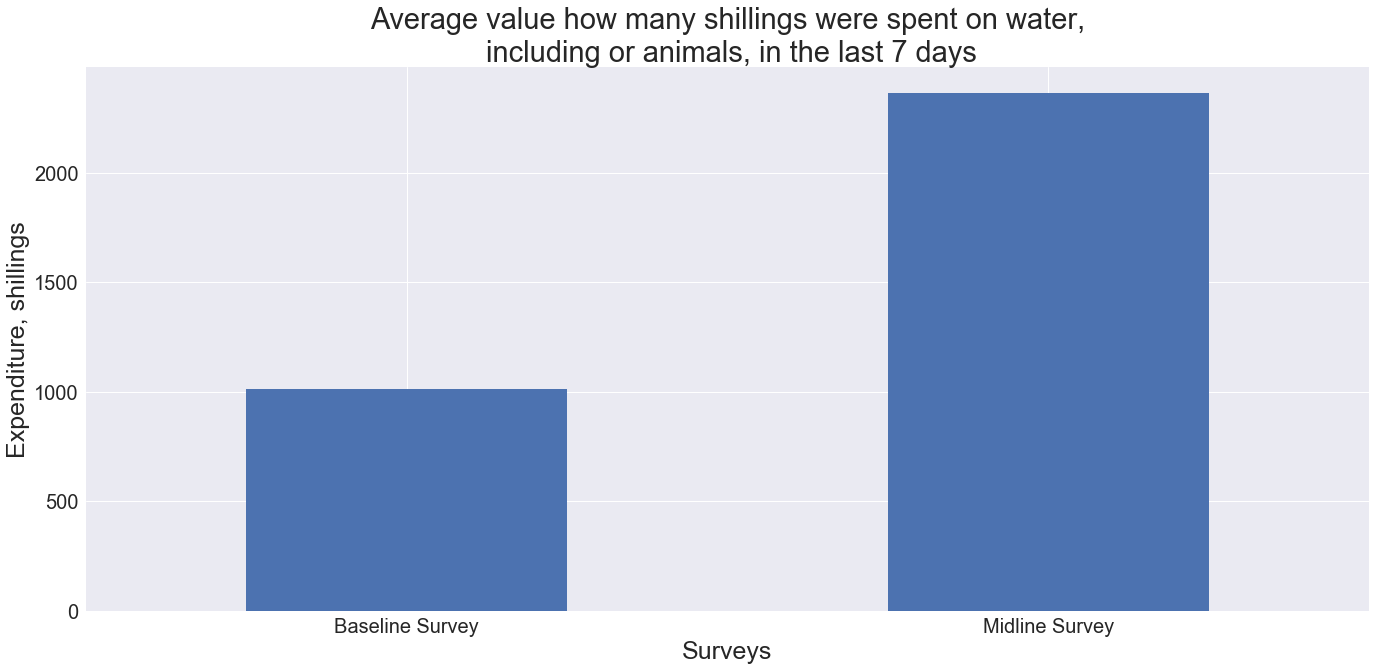

In [128]:
show_diff_between_surveys(df_Gidewari, 
                          df_Gidewari_m, 
                          'WaterExpenditure', 
                          np.mean, 
                          ['Baseline Survey', 'Midline Survey'],
                          'Average value how many shillings were spent on water,\n including or animals, in the last 7 days',
                          'Expenditure, shillings', (1.2, 1.0))

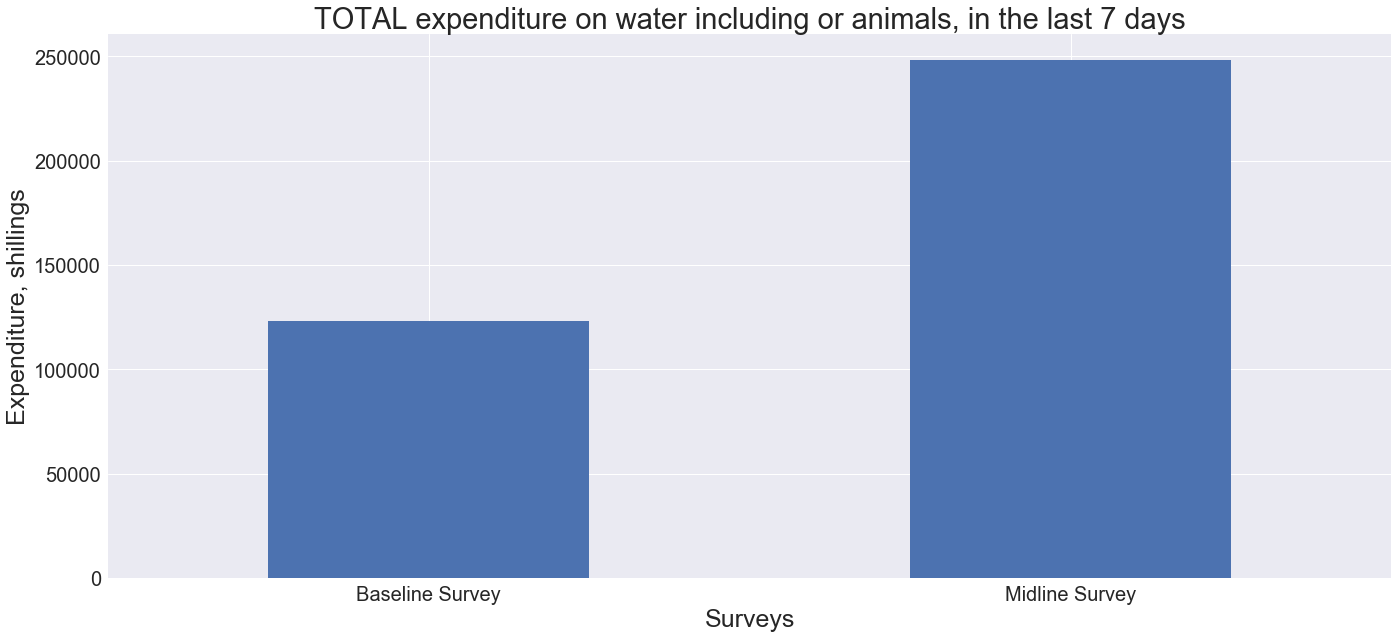

In [129]:
show_diff_between_surveys(df_Gidewari, 
                          df_Gidewari_m, 
                          'WaterExpenditure', 
                          np.sum, 
                          ['Baseline Survey', 'Midline Survey'],
                          'TOTAL expenditure on water including or animals, in the last 7 days',
                          'Expenditure, shillings', (1.2, 1.0))

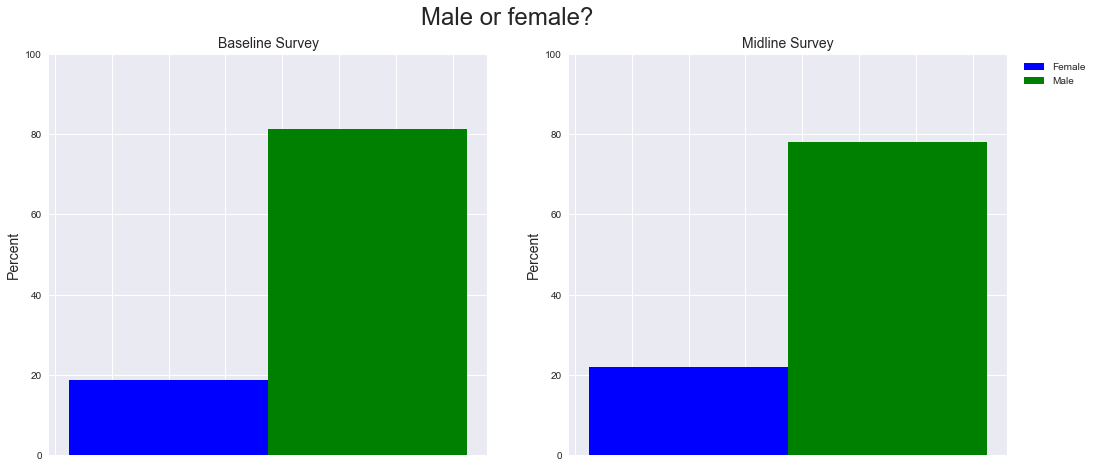

In [130]:
show_diff_for_surveys({'Baseline Survey': df_Gidewari, 'Midline Survey': df_Gidewari_m}, 'Gender',
                      'Male or female?', {0 : 'Female', 1: 'Male'}, (1.2, 1.0))

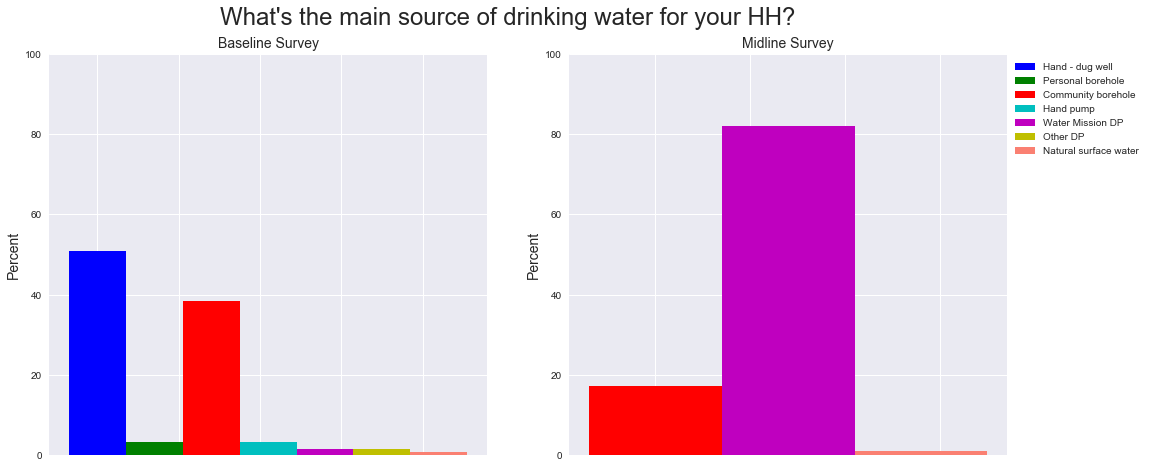

In [131]:
dict_sow ={ 1: 'Hand - dug well', 2: 'Personal borehole', 3:'Community borehole', 4:'Hand pump', 5:'Water Mission DP', 
           6: 'Other DP', 7:'Natural surface water', 8: 'Other' }
show_diff_for_surveys({'Baseline Survey': df_Gidewari, 'Midline Survey': df_Gidewari_m}, 'PrimarySource',
                      "What's the main source of drinking water for your HH?", dict_sow , (1.32, 1.0), width=0.14)

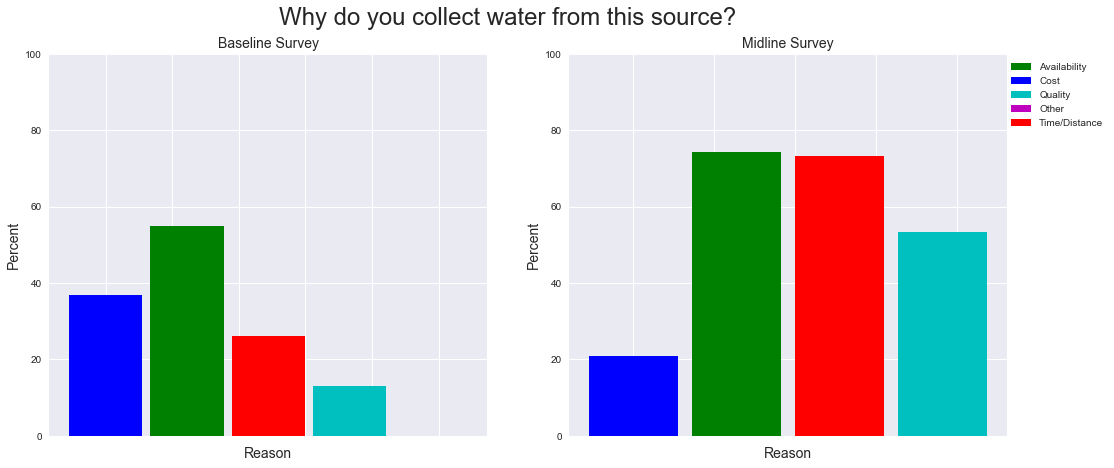

In [132]:
show_diff_props_surveys({'Baseline Survey': df_Gidewari, 'Midline Survey': df_Gidewari_m},
                                 {'Baseline Survey': ['Reason/Cost', 'Reason/Availability', 'Reason/Time_Distance',
                                                      'Reason/Quality', 'Reason/Other'], 
                                  'Midline Survey': ['Reason/Cost', 'Reason/Availability', 'Reason/Time_Distance',
                                                     'Reason/Quality']},
                                 'Why do you collect water from this source?',
                                 {'Reason/Cost': 'Cost', 'Reason/Availability': 'Availability', 
                                   'Reason/Time_Distance': 'Time/Distance', 'Reason/Quality': 'Quality',
                                   'Reason/Other': 'Other'},
                                 (1.24, 1.0), width=1.1, xlabel='Reason' )

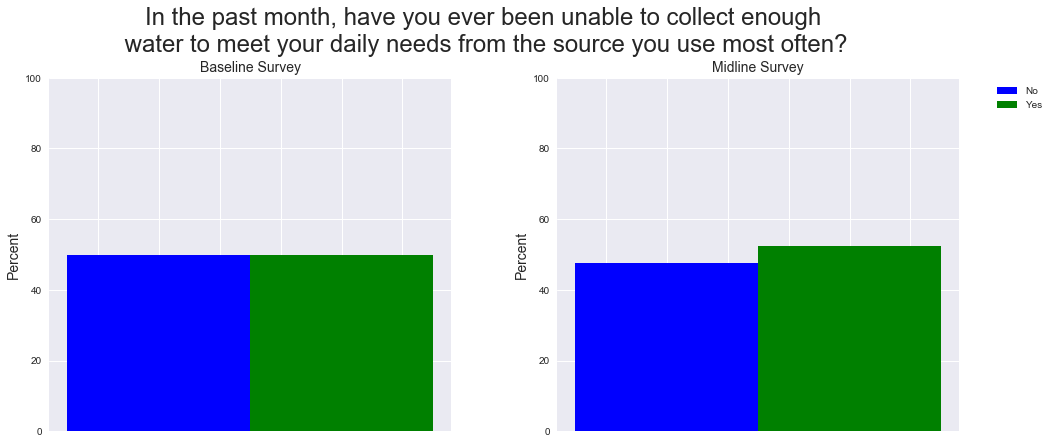

In [133]:
show_diff_for_surveys({'Baseline Survey': df_Gidewari, 'Midline Survey': df_Gidewari_m}, 'WaterAvailability',
                      'In the past month, have you ever been unable to collect enough\n water to meet your daily needs from the source you use most often?',
                      {0 : 'No', 1: 'Yes', 88: "Don't Know" }, (1.23, 1.0) , width=0.3, pad=4)

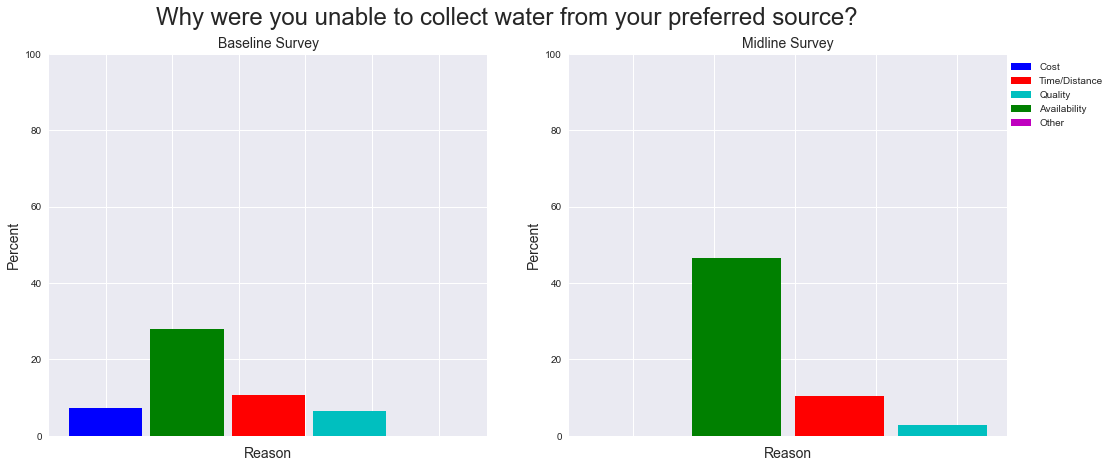

In [134]:
show_diff_props_surveys({'Baseline Survey': df_Gidewari, 'Midline Survey': df_Gidewari_m},
                                 {'Baseline Survey': ['AvailReason/Cost', 'AvailReason/Availability', 'AvailReason/Time_Distance',
                                                      'AvailReason/Quality', 'AvailReason/Other'], 
                                  'Midline Survey': ['AvailReason/Cost', 'AvailReason/Availability',
                                                     'AvailReason/Time_Distance', 'AvailReason/Quality']},
                                 'Why were you unable to collect water from your preferred source?',
                                 {'AvailReason/Cost': 'Cost', 'AvailReason/Availability': 'Availability', 
                                   'AvailReason/Time_Distance': 'Time/Distance', 'AvailReason/Quality': 'Quality',
                                   'AvailReason/Other': 'Other'},
                                 (1.24, 1.0), width=1.1, xlabel='Reason')

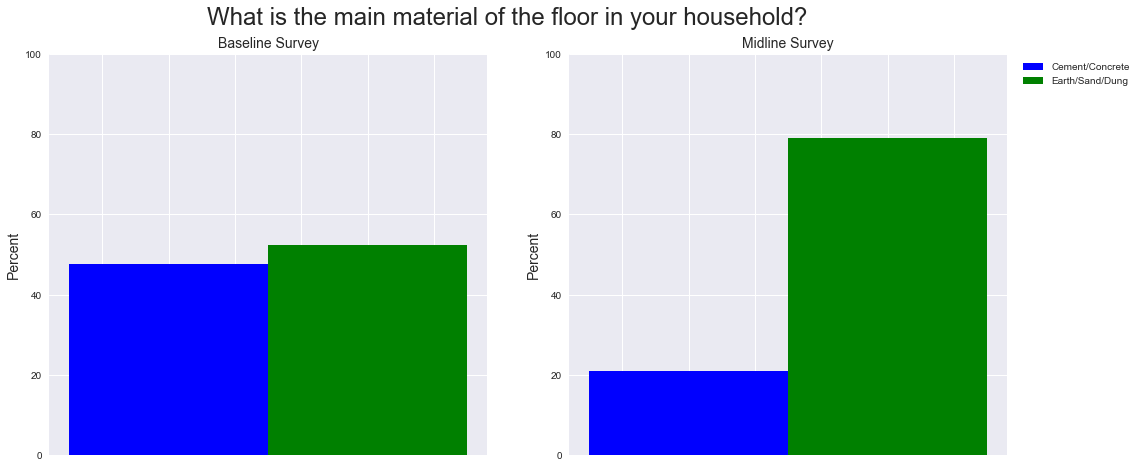

In [135]:
show_diff_for_surveys({'Baseline Survey': df_Gidewari, 'Midline Survey': df_Gidewari_m}, 'FloorMaterial',
                      'What is the main material of the floor in your household?',
                      {0 : 'Cement/Concrete', 1: 'Earth/Sand/Dung', 3: 'Other'}, (1.3, 1.0), width=0.3)

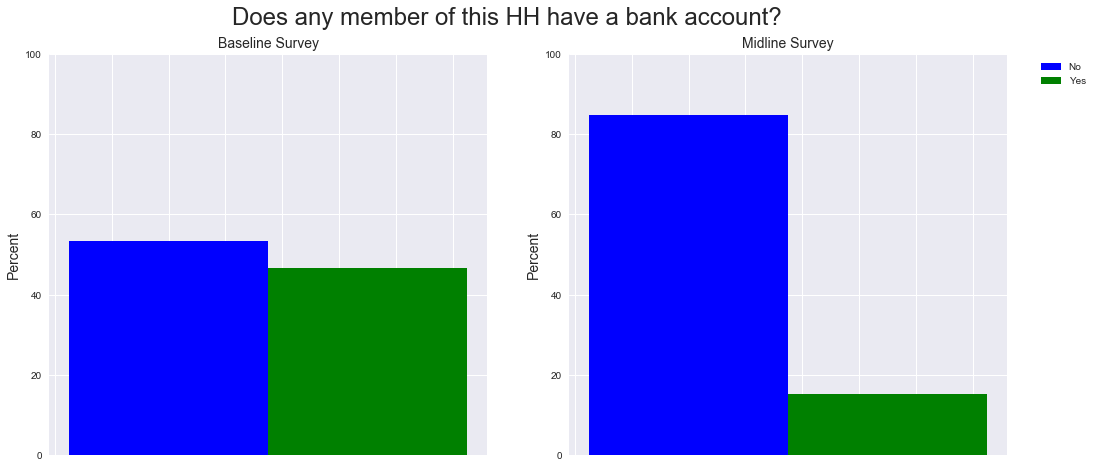

In [136]:
show_diff_for_surveys({'Baseline Survey': df_Gidewari, 'Midline Survey': df_Gidewari_m}, 'BankAccount',
                      'Does any member of this HH have a bank account?', {0 : 'No', 1: 'Yes'}, (1.2, 1.0))

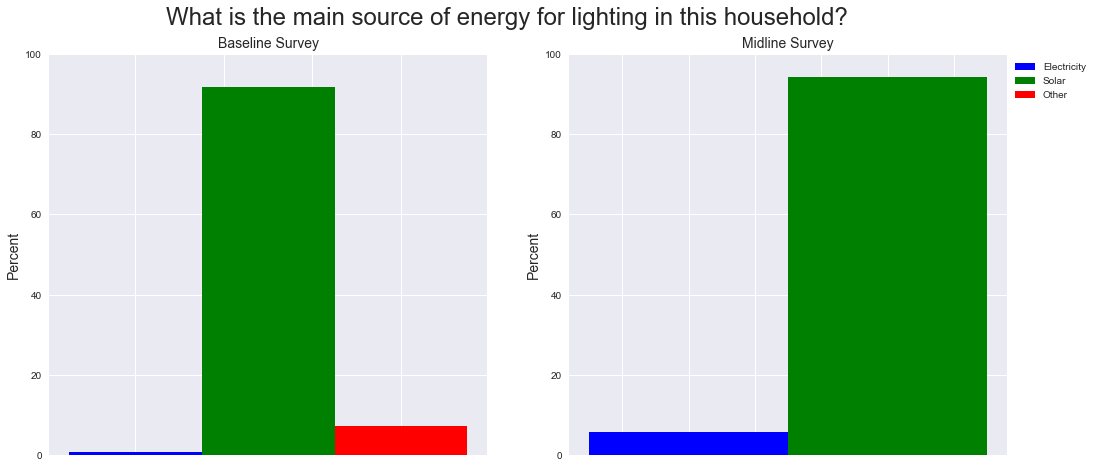

In [137]:
show_diff_for_surveys({'Baseline Survey': df_Gidewari, 'Midline Survey': df_Gidewari_m}, 'SourceOfLighting',
                      'What is the main source of energy for lighting in this household?',
                      {1 : 'Electricity', 2: 'Solar', 3: 'Other'}, (1.2, 1.0), width=0.3)

In [138]:

df = df_survey_apr[(df_survey_apr.CommName == 'Chanhumba')]
df = df[['CommName', 'WaterExpenditure', 'AmountOfWater', 'calculate_water']]
df.WaterExpenditure.mean()/7/2.5

109.26966292134833

In [139]:
df.AmountOfWater.mean()/7*20

84.17335473515249

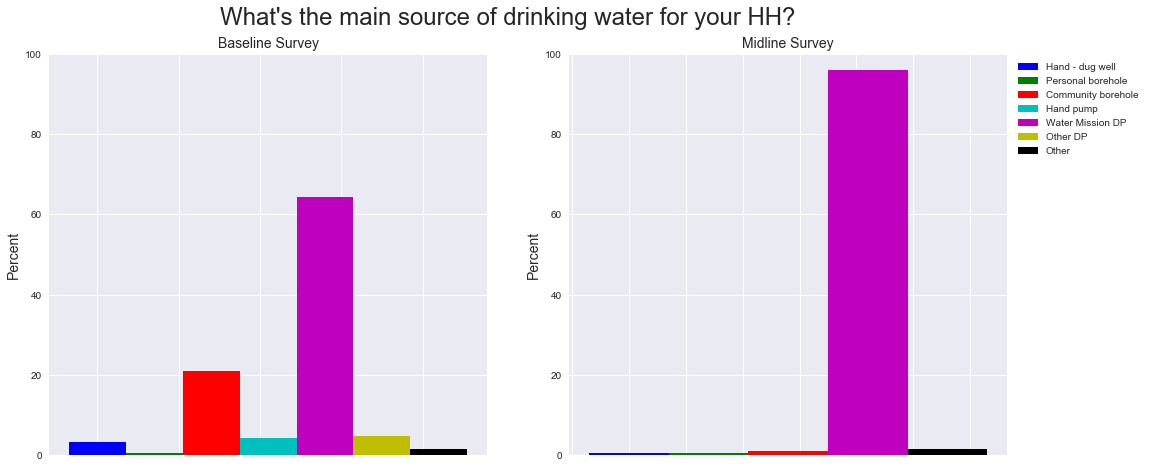

In [140]:
dict_sow ={ 1: 'Hand - dug well', 2: 'Personal borehole', 3:'Community borehole', 4:'Hand pump', 5:'Water Mission DP', 
           6: 'Other DP', 7:'Natural surface water', 8: 'Other' }
show_diff_for_surveys({'Baseline Survey': df_Chanhomba, 'Midline Survey': df_Chanhomba_m}, 'PrimarySource',
                      "What's the main source of drinking water for your HH?", dict_sow , (1.32, 1.0), width=0.14)